## WARNING !
All the questionable decisions i have marked with comment #TODO
to think about them and discuss.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pylab
import cvxpy as cp
from scipy.linalg import eigh
from collections import OrderedDict
import pandas as pd
import pickle
import scipy as sp
import seaborn as sns
import scipy.stats as stats
import random
import argparse
from time import time
import os
#from google.colab import files
from scipy.sparse import coo_matrix
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)

## Parameters of experiment

In [3]:
nodes = 10#int(input(" NODES in the graph : "  )) #number of arms
super_arm_sparsity = 4 #int(input(" number of chosen arms in the super arm is : "  )) #number of chosen arms
rounds = 5000 #int(input(" rounds of observation (decision making) : "  )) # number of rounds of data we create

In [4]:
#change points
change_points = [0, 1000, 2500, 4000]

In [5]:
# Reasonable parameters I have found xi = 5e-08, gamma = 0.99
# Tuning resulted in xi = 1e-09, gamma = 0.97

In [6]:
xi = 1e-10 # larger -> more exploration
s = super_arm_sparsity
gamma = 0.985 # smaller -> more forgetting / more exploration

In [7]:
Delay = 50 #10
skiped = 0
best_lambda = 0.1

In [8]:
start_ts = time()

## Useful functions


### Create graph

In [9]:
# 12 

In [10]:
def create_graph(n):
    # This value is chosen so that resulting density of DAG is 0.15
    prob_of_edge = 0.25 #float(input("* Please enter the probability of having an edge in your random graph:"  ))
    
    G = nx.gnp_random_graph(n=n, p=prob_of_edge, directed=True, seed=6)
    
    # Make the graph directed and acyclic
#     DAG = nx.DiGraph([(u, v, {'weight': np.random.uniform(low=0.9, high=0.95)}) for (u, v) in G.edges() if u < v])
    DAG = nx.DiGraph([(u, v) for (u, v) in G.edges() if u < v])
    print('* Is the graph a DAG? ', nx.is_directed_acyclic_graph(DAG))
    
    # building the adjacency numpy matrix of the graph
    edge_list = list(DAG.edges())
    number_of_edges = len(edge_list)
    
    w = np.zeros((n, n)) # the numpy adjacency matrix with all edge weights equal to 1    
    for edge in edge_list:
        w[edge[0], edge[1]] = np.random.uniform(low=0.4, high=0.7)
    
    if np.count_nonzero(w) == number_of_edges:
        print('The adjacency matrix is correctly set as a randomly picked DAG!')
        
    temp1 = np.eye(w.shape[0]) - w
    C = np.linalg.inv(temp1)
    C_axis_0_sum = np.sum(C, axis=0)
    
    print('the elements of the vector C are:  ', np.transpose(C_axis_0_sum))
    return w , C

In [11]:
def change_point_index(time_point):
    """Return index of last happened change point by the time `time_point`"""
    global change_points
    global rounds
    assert time_point >= change_points[0], f"Time point smaller than first change point {change_points[0]}"
    assert time_point <= rounds, f"Time point larger than total num of rounds {rounds}"
    
    for ind, ch_p in enumerate(change_points):
        if time_point < ch_p:
            return ind - 1
    else:
        return len(change_points) - 1

### Rewards

In [12]:
	#       B
# def instantaneous_Gaussian_rewards(maxx, minn):
#     mean_b_gt_Gauss = np.zeros((len(change_points), nodes, 1))
#     B = np.zeros((nodes, rounds))
#     variance = 0.2#float(input(" The variance for all reward distributions is : "  ))
#     for i in range(0, len(change_points)):
#         mean_b_gt_Gauss[i, :, :] = np.random.uniform(low=minn, high=maxx, size=nodes) #uniformally at random the means
#         for j in range(rounds):
#             if j == change_points[i]:
# #                 print(j)
#                 if j == change_points[len(change_points)-1]:
                    
#                     for k in range(nodes):
#                         B[k,j:rounds] = variance * np.random.randn(1,rounds-j) + mean_b_gt_Gauss[i,k] # create the samples
#                 else:
# #                     print(j)
# #                     print(change_points[i+1])
# #                     print(B[1,j:change_points[i+1]].shape)
#                     for k in range(nodes):
#                         B[k,j:change_points[i+1]] = variance * np.random.randn(1,change_points[i+1]-j) + mean_b_gt_Gauss[i,k] # create the samples
# #     for i in range(1,nodes):
# #         temporary_1 = variance * np.random.randn(1,rounds) + mean_b_gt_Gauss[i]
# #         B = np.concatenate((B,temporary_1),axis=0)
#     return B, mean_b_gt_Gauss;

# def instantaneous_Gaussian_rewards_with_gap(maxx, minn):
#     mean_b_gt_Gauss = np.zeros((len(change_points), nodes, 1))
#     B = np.zeros((nodes, rounds))
    
#     variance = 0.1#float(input(" The variance for all reward distributions is : "  ))
    
#     for i in range(0, len(change_points)):
#         # For s nodes chose mean values higher than for others.
#         high_reward_nodes = np.random.choice(a=range(nodes), size=s, replace=False)
        
#         high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
#         print(high_reward_nodes)
#         low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
#         interval_size = maxx - minn
#         # Chose means uniformly at random
#         mean_b_gt_Gauss[i, high_reward_nodes, :] = np.random.uniform(
#             low=maxx - interval_size / 4, high=maxx, size=(len(high_reward_nodes), 1)
#         ) 
#         mean_b_gt_Gauss[i, low_reward_nodes, :] = np.random.uniform(
#             low=minn, high=minn + interval_size / 4, size=(len(low_reward_nodes), 1)
#         ) 
        
#     for j in range(rounds):
#         ch_p_ind = change_point_index(j)
#         for k in range(nodes):
#             B[k, j] = variance * np.random.randn(1) + mean_b_gt_Gauss[ch_p_ind, k]
    
#     return B, mean_b_gt_Gauss;

def instantaneous_Bernoulli_rewards(high_interval, low_interval):
    mean_b_gt_Bern = np.zeros((len(change_points), nodes, 1))
    B = np.zeros((nodes, rounds))
    

    for i in range(0, len(change_points)):
        # For s nodes chose mean values higher than for others.
        high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
        
        print(high_reward_nodes)
        low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
        # Chose means uniformly at random
        mean_b_gt_Bern[i, high_reward_nodes, :] = np.random.uniform(
            low=high_interval[0], high=high_interval[1], size=(len(high_reward_nodes), 1)
        ) 
        
        
        mean_b_gt_Bern[i, low_reward_nodes, :] = np.random.uniform(
            low=low_interval[0], high=low_interval[1], size=(len(low_reward_nodes), 1)
        )
        
        # Make sure one of the base arms almost reaches high and low ends.
        mean_b_gt_Bern[
            i, np.random.choice(high_reward_nodes), :
        ] = high_interval[1] - np.random.normal(scale=(high_interval[1] - high_interval[0])/20)
        
        mean_b_gt_Bern[
            i, np.random.choice(low_reward_nodes), :
        ] = low_interval[0] + np.random.normal(scale=(low_interval[1] - low_interval[0])/20)
        
    for j in range(rounds):
        ch_p_ind = change_point_index(j)
        for k in range(nodes):
            B[k, j] = np.random.binomial(n=1, p=mean_b_gt_Bern[ch_p_ind, k])
    
    return B, mean_b_gt_Bern;
	
#   function to create the random action X

def rand_binary_array(number_of_chosen_arms=super_arm_sparsity, n=nodes): 
    
    arr = np.zeros((n,1))
    arr[:(number_of_chosen_arms)] = 1
    np.random.shuffle(arr)
    return arr

def create_random_action(number_of_chosen_arms=super_arm_sparsity, n=rounds):

    X = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
    for i in range(n-1):
        temp2 = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
        X = np.concatenate((X,temp2),axis=1)
    return X
	
def f_measure_func(x, xgt): #Not read yet
    
    x=np.where(x!=0,1,0)
    xgt=np.where(xgt!=0,1,0)
    true_pos = np.count_nonzero(np.multiply(x,xgt))
    fals_pos = np.count_nonzero(np.where((x-xgt)>0,1,0))
    fals_neg = np.count_nonzero(np.where((xgt-x)>0,1,0))
    true_neg = nodes**2 - true_pos - fals_neg - fals_pos
    f_measure=true_pos/(true_pos+0.5*(fals_neg+fals_pos))
    
    return f_measure

### Graph learning

In [13]:
#................................SEM + L1 graph learning
def graph_learning(
    current_time, A_gt, observ, perturb, nodes = nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay
):

    if skiped == 0: 
        lambda_params = np.array([0.00001,0.0001,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10\
                          ,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9\
                          ,10,20,30,40,50,60,70,80,90,100,1000,10000,100000,1000000])
    elif skiped == 1:
        lambda_params = np.asarray([best_lambda])
    
    # If no current time < Delay then agent has no observations yet. 
    # Must be > 0 because otherwise indexing works wrong, starts from the end.
    time_up_to_delay = max(0, current_time - Delay)
    observ = observ[:,:time_up_to_delay] #!
    perturb = perturb[:,:time_up_to_delay] #!

    error_SEM_L1 = np.ones([lambda_params.shape[0],1])*10000000000000000000
    for k in range (lambda_params.shape[0]):
        A        = cp.Variable((nodes,nodes))
        #TODO When no observations - just minimize the regularizer term.
        cost     = (
            cp.sum_squares(observ - (A @ observ) - perturb) + lambda_params[k] * cp.atoms.norm1(A) 
            if time_up_to_delay > 0 
            else lambda_params[k]*cp.atoms.norm1(A) 
        )
        obj      = cp.Minimize(cost)
        constr   = [cp.diag(A) == 0 , A[:,:] >= 0]
        prob     = cp.Problem(obj, constr)
        opt_val  = prob.solve()
        solution_L1Norm = A.value

        error_SEM_L1[k] = np.sum(np.power((A_gt - A.value),2)) / (nodes*nodes) 
    
        if error_SEM_L1[k] <= np.amin(error_SEM_L1):
            The_final_solution_SEM_L1 = A.value
            
            # Enforce constraints post-hoc (numerical solver does not enforce them)
#             The_final_solution_SEM_L1 = np.triu(The_final_solution_SEM_L1, k=1)
#             The_final_solution_SEM_L1 = np.maximum(
#                 The_final_solution_SEM_L1, np.zeros(The_final_solution_SEM_L1.shape)
#             )
            
            
            solution_threshold_SEM_L1 = np.where(np.absolute(A.value)<\
                                             (0.1*np.amax(np.absolute(A.value))),0,A.value)
#             solution_Boolean_SEM_L1 = np.where(solution_threshold_SEM_L1==0,0,1)
            best_lambda = lambda_params[k]
#             optvalue1 = opt_val
    
    
    
    f_measure = f_measure_func(solution_threshold_SEM_L1, A_gt)
#     print('the f-measure is : ', f_measure)
    
    # sanity checks that estimated graph follows constraints
#     assert np.allclose(The_final_solution_SEM_L1, np.triu(The_final_solution_SEM_L1, k = 1)), (
#         "Solution is not upper triangular with zero diagonal"
#     )
    
#     assert np.all(The_final_solution_SEM_L1 >= -1e-12), (
#         "Solution is not non-negative "
#     )
    
    return The_final_solution_SEM_L1, f_measure, best_lambda, np.amin(error_SEM_L1)

In [14]:

# Finding solution new function

def Best_action_func_new(A, b, s = super_arm_sparsity):
#A --> Estimated A or w_gt
#b --> UCB or mean_b_gt[i,:]
    
    temp_inv        = np.linalg.inv(np.eye(nodes) - A)
    b_diag          = np.diagflat(b) 
    C               = np.matmul(temp_inv, b_diag)
#     print("C.shape is", C.shape)
    C_axis_0_sum    = np.sum(C,axis=0) 
#     print("C_axis_0_sum.shape is", C_axis_0_sum.shape)
    ind             = np.argsort(C_axis_0_sum,axis=0)[-s:]
    x               = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0] = 1
        
    if (b == b[0]).all():
#             print(f'All UCBs are same, taking random action')
            np.random.shuffle(x)
    
    return x


### UCB func


In [15]:

# UCB  function as part of decision making strategy

# def UCB_func(t, x, T, b_bar, b_hat, b):
def UCB_func(t, x, num_plays_state, inst_reward, xi, s, gamma, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
    
    m_t_gamma = sum([gamma ** (t - tau) for tau in range(1, t + 1)])
    
    delayed_discounted_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_discounted_counts_state[k] += num_plays_state[k,:,j]*(gamma**(t-j))


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] = emp_avg_reward_state_temp[k] + inst_reward[k,j]*num_plays_state[k,:,j]*(gamma**(t-j))

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_discounted_counts_state[j])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[j]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp
            # print((xi *s*np.log(t+1)) / (delayed_discounted_counts_state[j]))
        else:
            print("The given base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[j,0])
#             print(delayed_discounted_counts_state[j])
    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[k] != 0 and t >= Delay:
            #TODO Added this line, why did it work without it?
            # Without this line for all not-chosen arms had empirical reward zero
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_discounted_counts_state[k])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[k]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp
    #         print((xi*s*np.log(t+1))) # / (delayed_discounted_counts_state[k])
    #         print(delayed_discounted_counts_state[k])
        else:
            print("The given (not selected) base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[k,0])
#             print(delayed_discounted_counts_state[k])
            
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin



In [16]:

def overall_reward(x, b, A):
#b --> mean_b_gt[i,:]
#A --> w_gt
    assert x.shape == (nodes, 1), f"Shape is {x.shape}"
    assert b.shape == x.shape, f"Shape of b {b.shape} must be same as x.shape={x.shape}"
    temp_inv = np.linalg.inv(np.eye(nodes) - A)
    temp_multiply = np.multiply(b, x)
    temp = np.matmul(temp_inv, temp_multiply)
    rew = np.sum(temp)
    
    return rew

## Create ground truth rewards and graph, set parameters

In [17]:
# Parameters of the experiment

# create the graph and the B
w_gt, C_gt = create_graph(n=nodes); # create the gt graph
print('Density of the ground truth graph is: ',(np.count_nonzero(w_gt))/((nodes*nodes)-nodes))

# B, mean_b_gt = instantaneous_Gaussian_rewards(maxx=0.7, minn=0.3); # create the gt 'b'
# B, mean_b_gt = instantaneous_Gaussian_rewards_with_gap(maxx=0.7, minn=0.3);
B, mean_b_gt = instantaneous_Bernoulli_rewards(high_interval=[0.75, 0.9], low_interval=[0.1, 0.3]);

print('The elements of the vector of expected instantaneous rewards of base arms are:  ', mean_b_gt)

* Is the graph a DAG?  True
The adjacency matrix is correctly set as a randomly picked DAG!
the elements of the vector C are:   [1.         1.         1.         1.         1.         1.51236204
 1.         1.57959755 4.46831448 1.41742508]
Density of the ground truth graph is:  0.08888888888888889
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]
The elements of the vector of expected instantaneous rewards of base arms are:   [[[0.84016725]
  [0.85621089]
  [0.91293688]
  [0.89548648]
  [0.26648853]
  [0.09437712]
  [0.13636499]
  [0.1366809 ]
  [0.16084845]
  [0.20495129]]

 [[0.2236772 ]
  [0.1764924 ]
  [0.29664618]
  [0.09970161]
  [0.90220049]
  [0.89606333]
  [0.7849157 ]
  [0.76359097]
  [0.27198808]
  [0.23606151]]

 [[0.75239494]
  [0.78463407]
  [0.14820509]
  [0.2366527 ]
  [0.22199933]
  [0.26663898]
  [0.13467293]
  [0.09295547]
  [0.83449323]
  [0.89575415]]

 [[0.18995083]
  [0.17903005]
  [0.89576652]
  [0.83515505]
  [0.75469699]
  [0.87634272]
  [0.28533177]
  [0.2

In [18]:

# calculate the best action for the given graph and 'b'
best_action_choice = np.zeros((len(change_points), nodes, 1))
for i in range(len(change_points)):
    best_action_choice[i,:,:] = Best_action_func_new(A=w_gt, b=mean_b_gt[i, :], s=super_arm_sparsity)

# calculate the best reward for the best action so that later use it in regret calculation
best_expected_reward = np.zeros(len(change_points))
for i in range(len(change_points)):
    best_expected_reward[i] = overall_reward(x=best_action_choice[i,:], b=mean_b_gt[i,:], A=w_gt)

print('the best overall reward is ', best_expected_reward)


the best overall reward is  [3.5048015  4.67886735 6.53547161 3.81096602]


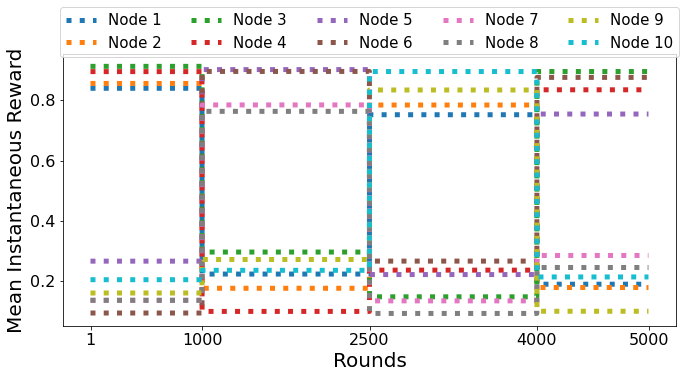

In [19]:
plot_array = np.zeros((nodes, rounds))
for i in range(0, len(change_points)):
    
    for j in range(rounds):
        if j == change_points[i]:
            if j == change_points[len(change_points)-1]:
                for k in range(nodes):
                    plot_array[k,j:rounds] = mean_b_gt[i,k]
            else:
                for k in range(nodes):
                    plot_array[k,j:change_points[i+1]] = mean_b_gt[i,k]

fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(nodes):
#     expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(plot_array[arm,:], label=f"Node {arm+1}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1] + change_points[1:] + [rounds]
plt.xticks(extraticks, fontsize=16) #, rotation=35

plt.yticks(fontsize=16)

ax.set_xlabel('Rounds', fontsize=20)
ax.set_ylabel(fr"Mean Instantaneous Reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.2), prop={'size': 15})
fig.savefig(f"mean_instantaneous_reward.jpg", format = 'jpg', dpi = 300, bbox_inches='tight')

plt.show()

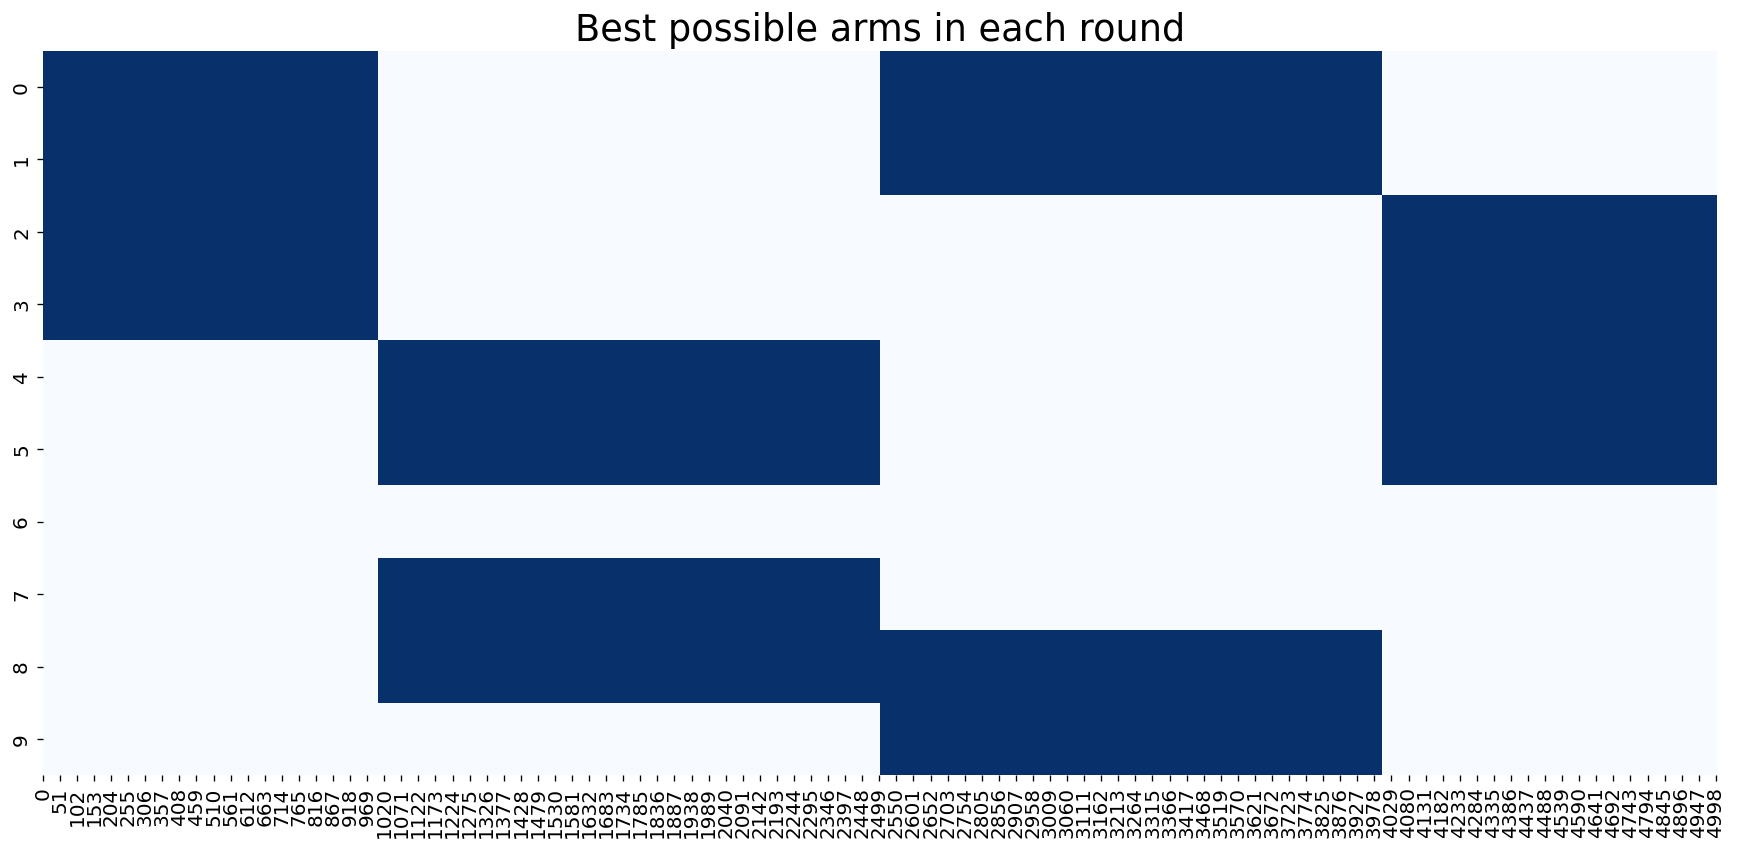

In [20]:
oracle_actions = best_action_choice[0]
for i in range(rounds):
    ch_p_ind = change_point_index(i)
    oracle_actions = np.concatenate((oracle_actions, best_action_choice[ch_p_ind]), axis=1)

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 120)
tttt=sns.heatmap(oracle_actions, cmap='Blues',linewidth=0.001, linecolor='k',cbar=False)

# Decorations
plt.title('Best possible arms in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [21]:
# s is the sparsity of the chosen action vector 
# nodes is the number of arms 

def initial_rounds_actions(nodes,s):

    initial_actions = np.zeros((nodes,nodes))
    initial_actions = initial_actions + np.eye(nodes)
    for i in range(nodes):
        if i <= s:
            for j in range(i):
                initial_actions[i,j] = 1
        elif i > s:
            temp = rand_binary_array(number_of_chosen_arms=s-1, n=i-1)
            temp1 = np.nonzero(temp)
            for j in range(temp1[0].shape[0]):
                temp2 = temp1[0][j]
                initial_actions[i,temp2] = 1
            
#     np.random.shuffle(initial_actions) #!
    needed_initial_matrix=initial_actions.T
    
    return needed_initial_matrix

In [22]:
all_actions_taken = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
initial_rounds = nodes

In [23]:
#Up until this point was editted and fixed <----------------

## NDC-SEM initial rounds

In [24]:
# NDC-SEM variables
f_measure = np.zeros((1, rounds)) 
collected_expected_rewards = np.zeros((1, rounds))
collected_instantaneous_rewards = np.zeros((1, rounds))
instantaneous_regret = np.zeros((1, rounds))
expected_regret = np.zeros((1, rounds))
graph_mse = np.zeros((1, rounds))


#To record number of plays of each state #(B_signals.shape[0],1,num_rounds)
num_plays_state = np.zeros((nodes, 1, rounds)) #T = np.ones((nodes,1)) --> Maybe zeros?

#To record empirical average reward of each state #(B_signals.shape[0],1,num_rounds)
emp_avg_reward_state = np.zeros((nodes, 1, rounds)) #b_bar = np.ones((nodes,1)) --> Maybe zeros?

#To record UCB index of each state #(B_signals.shape[0],1,num_rounds)
UCB_state = np.ones((nodes, 1, rounds)) #b_hat = np.ones((nodes,1))

In [25]:
################ initial rounds ######################

for i in range(initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    x_i = np.transpose(np.asarray([all_actions_taken[:, i]]))  
    z_i = np.multiply(base_reward_i, x_i)
    
    y_i = np.matmul(C_gt, z_i)
    if i == 0:
        Y = y_i
    else:
        Y = np.concatenate((Y, y_i),axis=1)
    
    collected_expected_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt) 
    collected_instantaneous_rewards[0,i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    
    expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0,i]
    instantaneous_regret[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards[0, i]
    
    num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
      t=i, x=all_actions_taken[:, i], num_plays_state=num_plays_state,
      inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
    )

    print('collected reward of round ', i , ' is ', collected_expected_rewards[0,i])


The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward of round  0  is  0.8401672517614813
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The 

## 1. Acting based on NDC-SEM (our algorithm)

In [26]:
# How to learn graph if delay is more than observations?

In [27]:
for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    # Matrix which columns are z_t values up to current moment. 
    # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
    Z_t = np.multiply(all_actions_taken, B[:, 0:all_actions_taken.shape[1]])
#     print('Z_t shape is ', Z_t.shape)

    if f_measure[0, i - 1] == 1:
        # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
        f_measure[0, i] = f_measure[0, i - 1]
    else:     
        w_hat, f_measure[0, i], best_lambda, graph_mse[0, i] = graph_learning(
            current_time=i, A_gt=w_gt, observ=Y, perturb=Z_t, 
            nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
        )
        if f_measure[0,i]>=0.9:
            skiped = 1
        elif f_measure[0,i]<0.9:
            skiped = 0
    
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    x_i = Best_action_func_new(A=w_hat, b=UCB_state[:,:,i - 1], s=super_arm_sparsity)
    all_actions_taken = np.concatenate((all_actions_taken, x_i), axis=1)

    z_i = np.multiply(base_reward_i, x_i)
    y_i = np.matmul(C_gt, z_i)
    Y = np.concatenate((Y, y_i), axis=1)
    
    collected_expected_rewards[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0, i]
    instantaneous_regret[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards[0,i]
    
    if expected_regret[0, i] < 0:
        raise ValueError()
    
    print(f'collected reward round {i} is: ', collected_expected_rewards[0, i])
    
    num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
      t=i, x=x_i, num_plays_state=num_plays_state,
      inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
    )
	


collected reward round 10 is:  1.966473740480981
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 11 is:  2.160689172246265
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm 

collected reward round 27 is:  1.9839241464005295
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 28 is:  0.7855012852856147
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 45 is:  1.361490356822216
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 46 is:  2.048245144296637
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm 

collected reward round 175 is:  3.504801499999035
collected reward round 176 is:  3.504801499999035
collected reward round 177 is:  3.504801499999035
collected reward round 178 is:  3.504801499999035
collected reward round 179 is:  3.504801499999035
collected reward round 180 is:  3.504801499999035
collected reward round 181 is:  3.504801499999035
collected reward round 182 is:  3.504801499999035
collected reward round 183 is:  3.504801499999035
collected reward round 184 is:  3.504801499999035
collected reward round 185 is:  3.504801499999035
collected reward round 186 is:  3.504801499999035
collected reward round 187 is:  3.504801499999035
collected reward round 188 is:  3.504801499999035
collected reward round 189 is:  3.504801499999035
collected reward round 190 is:  3.504801499999035
collected reward round 191 is:  3.504801499999035
collected reward round 192 is:  3.504801499999035
collected reward round 193 is:  3.504801499999035
collected reward round 194 is:  3.504801499999035


collected reward round 356 is:  3.504801499999035
collected reward round 357 is:  3.504801499999035
collected reward round 358 is:  3.504801499999035
collected reward round 359 is:  3.504801499999035
collected reward round 360 is:  3.504801499999035
collected reward round 361 is:  3.504801499999035
collected reward round 362 is:  3.504801499999035
collected reward round 363 is:  3.504801499999035
collected reward round 364 is:  3.504801499999035
collected reward round 365 is:  3.504801499999035
collected reward round 366 is:  3.504801499999035
collected reward round 367 is:  3.504801499999035
collected reward round 368 is:  3.504801499999035
collected reward round 369 is:  3.504801499999035
collected reward round 370 is:  3.504801499999035
collected reward round 371 is:  3.504801499999035
collected reward round 372 is:  3.504801499999035
collected reward round 373 is:  3.504801499999035
collected reward round 374 is:  3.504801499999035
collected reward round 375 is:  3.504801499999035


collected reward round 533 is:  3.504801499999035
collected reward round 534 is:  3.504801499999035
collected reward round 535 is:  3.504801499999035
collected reward round 536 is:  3.504801499999035
collected reward round 537 is:  3.504801499999035
collected reward round 538 is:  3.504801499999035
collected reward round 539 is:  3.504801499999035
collected reward round 540 is:  3.504801499999035
collected reward round 541 is:  3.504801499999035
collected reward round 542 is:  3.504801499999035
collected reward round 543 is:  3.504801499999035
collected reward round 544 is:  3.504801499999035
collected reward round 545 is:  3.504801499999035
collected reward round 546 is:  3.504801499999035
collected reward round 547 is:  3.504801499999035
collected reward round 548 is:  3.504801499999035
collected reward round 549 is:  3.504801499999035
collected reward round 550 is:  3.504801499999035
collected reward round 551 is:  3.504801499999035
collected reward round 552 is:  3.504801499999035


collected reward round 704 is:  3.504801499999035
collected reward round 705 is:  3.504801499999035
collected reward round 706 is:  3.504801499999035
collected reward round 707 is:  3.504801499999035
collected reward round 708 is:  3.504801499999035
collected reward round 709 is:  3.504801499999035
collected reward round 710 is:  3.504801499999035
collected reward round 711 is:  3.504801499999035
collected reward round 712 is:  3.504801499999035
collected reward round 713 is:  3.504801499999035
collected reward round 714 is:  3.504801499999035
collected reward round 715 is:  3.504801499999035
collected reward round 716 is:  3.504801499999035
collected reward round 717 is:  3.504801499999035
collected reward round 718 is:  3.504801499999035
collected reward round 719 is:  3.504801499999035
collected reward round 720 is:  3.504801499999035
collected reward round 721 is:  3.504801499999035
collected reward round 722 is:  3.504801499999035
collected reward round 723 is:  3.504801499999035


collected reward round 870 is:  3.504801499999035
collected reward round 871 is:  3.504801499999035
collected reward round 872 is:  3.504801499999035
collected reward round 873 is:  3.504801499999035
collected reward round 874 is:  3.504801499999035
collected reward round 875 is:  3.504801499999035
collected reward round 876 is:  3.504801499999035
collected reward round 877 is:  3.504801499999035
collected reward round 878 is:  3.504801499999035
collected reward round 879 is:  3.504801499999035
collected reward round 880 is:  3.504801499999035
collected reward round 881 is:  3.504801499999035
collected reward round 882 is:  3.504801499999035
collected reward round 883 is:  3.504801499999035
collected reward round 884 is:  3.504801499999035
collected reward round 885 is:  3.504801499999035
collected reward round 886 is:  3.504801499999035
collected reward round 887 is:  3.504801499999035
collected reward round 888 is:  3.504801499999035
collected reward round 889 is:  3.504801499999035


collected reward round 1033 is:  0.7965173915878101
collected reward round 1034 is:  0.7965173915878101
collected reward round 1035 is:  0.7965173915878101
collected reward round 1036 is:  0.7965173915878101
collected reward round 1037 is:  0.7965173915878101
collected reward round 1038 is:  0.7965173915878101
collected reward round 1039 is:  0.7965173915878101
collected reward round 1040 is:  0.7965173915878101
collected reward round 1041 is:  0.7965173915878101
collected reward round 1042 is:  0.7965173915878101
collected reward round 1043 is:  0.7965173915878101
collected reward round 1044 is:  0.7965173915878101
collected reward round 1045 is:  0.7965173915878101
collected reward round 1046 is:  0.7965173915878101
collected reward round 1047 is:  0.7965173915878101
collected reward round 1048 is:  0.7965173915878101
collected reward round 1049 is:  0.7965173915878101
collected reward round 1050 is:  0.7965173915878101
collected reward round 1051 is:  0.7965173915878101
collected re

collected reward round 1193 is:  3.5001875883869844
collected reward round 1194 is:  3.5001875883869844
collected reward round 1195 is:  3.5001875883869844
collected reward round 1196 is:  3.5001875883869844
collected reward round 1197 is:  3.5001875883869844
collected reward round 1198 is:  3.5001875883869844
collected reward round 1199 is:  3.5001875883869844
collected reward round 1200 is:  3.5001875883869844
collected reward round 1201 is:  3.5001875883869844
collected reward round 1202 is:  3.5001875883869844
collected reward round 1203 is:  3.5001875883869844
collected reward round 1204 is:  3.5001875883869844
collected reward round 1205 is:  3.5001875883869844
collected reward round 1206 is:  3.5001875883869844
collected reward round 1207 is:  3.5001875883869844
collected reward round 1208 is:  3.5001875883869844
collected reward round 1209 is:  3.5001875883869844
collected reward round 1210 is:  3.5001875883869844
collected reward round 1211 is:  3.5001875883869844
collected re

collected reward round 1354 is:  4.678867348679898
collected reward round 1355 is:  4.678867348679898
collected reward round 1356 is:  4.678867348679898
collected reward round 1357 is:  4.678867348679898
collected reward round 1358 is:  4.678867348679898
collected reward round 1359 is:  4.678867348679898
collected reward round 1360 is:  4.678867348679898
collected reward round 1361 is:  4.678867348679898
collected reward round 1362 is:  4.678867348679898
collected reward round 1363 is:  4.678867348679898
collected reward round 1364 is:  4.678867348679898
collected reward round 1365 is:  4.678867348679898
collected reward round 1366 is:  4.678867348679898
collected reward round 1367 is:  4.678867348679898
collected reward round 1368 is:  4.678867348679898
collected reward round 1369 is:  4.678867348679898
collected reward round 1370 is:  4.678867348679898
collected reward round 1371 is:  4.678867348679898
collected reward round 1372 is:  4.678867348679898
collected reward round 1373 is:

collected reward round 1519 is:  3.798138568647487
collected reward round 1520 is:  4.678867348679898
collected reward round 1521 is:  4.678867348679898
collected reward round 1522 is:  3.798138568647487
collected reward round 1523 is:  4.678867348679898
collected reward round 1524 is:  4.678867348679898
collected reward round 1525 is:  4.111266357405418
collected reward round 1526 is:  4.111266357405418
collected reward round 1527 is:  4.111266357405418
collected reward round 1528 is:  4.111266357405418
collected reward round 1529 is:  4.111266357405418
collected reward round 1530 is:  4.111266357405418
collected reward round 1531 is:  4.111266357405418
collected reward round 1532 is:  4.111266357405418
collected reward round 1533 is:  4.111266357405418
collected reward round 1534 is:  4.111266357405418
collected reward round 1535 is:  4.111266357405418
collected reward round 1536 is:  4.111266357405418
collected reward round 1537 is:  4.111266357405418
collected reward round 1538 is:

collected reward round 1682 is:  4.678867348679898
collected reward round 1683 is:  4.678867348679898
collected reward round 1684 is:  4.678867348679898
collected reward round 1685 is:  4.678867348679898
collected reward round 1686 is:  4.678867348679898
collected reward round 1687 is:  4.678867348679898
collected reward round 1688 is:  4.678867348679898
collected reward round 1689 is:  4.678867348679898
collected reward round 1690 is:  4.678867348679898
collected reward round 1691 is:  4.678867348679898
collected reward round 1692 is:  4.678867348679898
collected reward round 1693 is:  4.678867348679898
collected reward round 1694 is:  4.678867348679898
collected reward round 1695 is:  4.678867348679898
collected reward round 1696 is:  4.678867348679898
collected reward round 1697 is:  4.678867348679898
collected reward round 1698 is:  4.678867348679898
collected reward round 1699 is:  4.678867348679898
collected reward round 1700 is:  4.678867348679898
collected reward round 1701 is:

collected reward round 1846 is:  4.678867348679898
collected reward round 1847 is:  4.678867348679898
collected reward round 1848 is:  4.678867348679898
collected reward round 1849 is:  4.678867348679898
collected reward round 1850 is:  4.678867348679898
collected reward round 1851 is:  4.678867348679898
collected reward round 1852 is:  4.678867348679898
collected reward round 1853 is:  4.678867348679898
collected reward round 1854 is:  4.678867348679898
collected reward round 1855 is:  4.678867348679898
collected reward round 1856 is:  4.678867348679898
collected reward round 1857 is:  4.678867348679898
collected reward round 1858 is:  4.678867348679898
collected reward round 1859 is:  4.678867348679898
collected reward round 1860 is:  4.678867348679898
collected reward round 1861 is:  4.678867348679898
collected reward round 1862 is:  4.678867348679898
collected reward round 1863 is:  4.678867348679898
collected reward round 1864 is:  4.678867348679898
collected reward round 1865 is:

collected reward round 2010 is:  4.678867348679898
collected reward round 2011 is:  4.678867348679898
collected reward round 2012 is:  4.678867348679898
collected reward round 2013 is:  4.678867348679898
collected reward round 2014 is:  4.678867348679898
collected reward round 2015 is:  4.678867348679898
collected reward round 2016 is:  4.678867348679898
collected reward round 2017 is:  4.678867348679898
collected reward round 2018 is:  4.678867348679898
collected reward round 2019 is:  4.678867348679898
collected reward round 2020 is:  4.678867348679898
collected reward round 2021 is:  4.678867348679898
collected reward round 2022 is:  4.678867348679898
collected reward round 2023 is:  4.678867348679898
collected reward round 2024 is:  4.678867348679898
collected reward round 2025 is:  4.678867348679898
collected reward round 2026 is:  4.678867348679898
collected reward round 2027 is:  4.678867348679898
collected reward round 2028 is:  4.678867348679898
collected reward round 2029 is:

collected reward round 2172 is:  4.678867348679898
collected reward round 2173 is:  4.678867348679898
collected reward round 2174 is:  4.678867348679898
collected reward round 2175 is:  4.678867348679898
collected reward round 2176 is:  4.678867348679898
collected reward round 2177 is:  4.678867348679898
collected reward round 2178 is:  4.678867348679898
collected reward round 2179 is:  4.678867348679898
collected reward round 2180 is:  4.678867348679898
collected reward round 2181 is:  4.678867348679898
collected reward round 2182 is:  4.678867348679898
collected reward round 2183 is:  4.678867348679898
collected reward round 2184 is:  4.678867348679898
collected reward round 2185 is:  4.678867348679898
collected reward round 2186 is:  4.678867348679898
collected reward round 2187 is:  4.678867348679898
collected reward round 2188 is:  4.678867348679898
collected reward round 2189 is:  4.678867348679898
collected reward round 2190 is:  4.678867348679898
collected reward round 2191 is:

collected reward round 2335 is:  4.678867348679898
collected reward round 2336 is:  4.678867348679898
collected reward round 2337 is:  4.678867348679898
collected reward round 2338 is:  4.678867348679898
collected reward round 2339 is:  4.678867348679898
collected reward round 2340 is:  4.678867348679898
collected reward round 2341 is:  4.678867348679898
collected reward round 2342 is:  4.678867348679898
collected reward round 2343 is:  4.678867348679898
collected reward round 2344 is:  4.678867348679898
collected reward round 2345 is:  4.678867348679898
collected reward round 2346 is:  4.678867348679898
collected reward round 2347 is:  4.678867348679898
collected reward round 2348 is:  4.678867348679898
collected reward round 2349 is:  4.678867348679898
collected reward round 2350 is:  4.678867348679898
collected reward round 2351 is:  4.678867348679898
collected reward round 2352 is:  4.678867348679898
collected reward round 2353 is:  4.678867348679898
collected reward round 2354 is:

collected reward round 2498 is:  4.678867348679898
collected reward round 2499 is:  4.678867348679898
collected reward round 2500 is:  4.50086442609052
collected reward round 2501 is:  4.50086442609052
collected reward round 2502 is:  4.50086442609052
collected reward round 2503 is:  4.50086442609052
collected reward round 2504 is:  4.50086442609052
collected reward round 2505 is:  4.50086442609052
collected reward round 2506 is:  4.50086442609052
collected reward round 2507 is:  4.50086442609052
collected reward round 2508 is:  4.50086442609052
collected reward round 2509 is:  4.50086442609052
collected reward round 2510 is:  4.50086442609052
collected reward round 2511 is:  4.50086442609052
collected reward round 2512 is:  4.50086442609052
collected reward round 2513 is:  4.50086442609052
collected reward round 2514 is:  4.50086442609052
collected reward round 2515 is:  4.50086442609052
collected reward round 2516 is:  4.50086442609052
collected reward round 2517 is:  4.5008644260905

collected reward round 2663 is:  5.6690618810940805
collected reward round 2664 is:  5.6690618810940805
collected reward round 2665 is:  5.6690618810940805
collected reward round 2666 is:  5.6690618810940805
collected reward round 2667 is:  5.6690618810940805
collected reward round 2668 is:  5.6690618810940805
collected reward round 2669 is:  5.6690618810940805
collected reward round 2670 is:  5.6690618810940805
collected reward round 2671 is:  5.6690618810940805
collected reward round 2672 is:  5.6690618810940805
collected reward round 2673 is:  5.6690618810940805
collected reward round 2674 is:  5.6690618810940805
collected reward round 2675 is:  5.6690618810940805
collected reward round 2676 is:  5.6690618810940805
collected reward round 2677 is:  5.6690618810940805
collected reward round 2678 is:  5.6690618810940805
collected reward round 2679 is:  5.6690618810940805
collected reward round 2680 is:  5.6690618810940805
collected reward round 2681 is:  5.6690618810940805
collected re

collected reward round 2824 is:  6.535471613345649
collected reward round 2825 is:  6.535471613345649
collected reward round 2826 is:  6.535471613345649
collected reward round 2827 is:  6.535471613345649
collected reward round 2828 is:  6.535471613345649
collected reward round 2829 is:  6.535471613345649
collected reward round 2830 is:  6.535471613345649
collected reward round 2831 is:  6.535471613345649
collected reward round 2832 is:  6.535471613345649
collected reward round 2833 is:  6.535471613345649
collected reward round 2834 is:  6.535471613345649
collected reward round 2835 is:  6.535471613345649
collected reward round 2836 is:  6.535471613345649
collected reward round 2837 is:  6.535471613345649
collected reward round 2838 is:  6.535471613345649
collected reward round 2839 is:  6.535471613345649
collected reward round 2840 is:  6.535471613345649
collected reward round 2841 is:  6.535471613345649
collected reward round 2842 is:  6.535471613345649
collected reward round 2843 is:

collected reward round 2987 is:  6.535471613345649
collected reward round 2988 is:  6.535471613345649
collected reward round 2989 is:  6.535471613345649
collected reward round 2990 is:  6.535471613345649
collected reward round 2991 is:  6.535471613345649
collected reward round 2992 is:  6.535471613345649
collected reward round 2993 is:  6.535471613345649
collected reward round 2994 is:  6.535471613345649
collected reward round 2995 is:  6.535471613345649
collected reward round 2996 is:  6.535471613345649
collected reward round 2997 is:  6.535471613345649
collected reward round 2998 is:  6.535471613345649
collected reward round 2999 is:  6.535471613345649
collected reward round 3000 is:  6.535471613345649
collected reward round 3001 is:  6.535471613345649
collected reward round 3002 is:  6.535471613345649
collected reward round 3003 is:  6.535471613345649
collected reward round 3004 is:  6.535471613345649
collected reward round 3005 is:  6.535471613345649
collected reward round 3006 is:

collected reward round 3148 is:  6.535471613345649
collected reward round 3149 is:  6.535471613345649
collected reward round 3150 is:  6.535471613345649
collected reward round 3151 is:  6.535471613345649
collected reward round 3152 is:  6.535471613345649
collected reward round 3153 is:  6.535471613345649
collected reward round 3154 is:  6.535471613345649
collected reward round 3155 is:  6.535471613345649
collected reward round 3156 is:  6.535471613345649
collected reward round 3157 is:  6.535471613345649
collected reward round 3158 is:  6.535471613345649
collected reward round 3159 is:  6.535471613345649
collected reward round 3160 is:  6.535471613345649
collected reward round 3161 is:  6.535471613345649
collected reward round 3162 is:  6.535471613345649
collected reward round 3163 is:  6.535471613345649
collected reward round 3164 is:  6.535471613345649
collected reward round 3165 is:  6.535471613345649
collected reward round 3166 is:  6.535471613345649
collected reward round 3167 is:

collected reward round 3309 is:  6.535471613345649
collected reward round 3310 is:  6.535471613345649
collected reward round 3311 is:  6.535471613345649
collected reward round 3312 is:  6.535471613345649
collected reward round 3313 is:  6.535471613345649
collected reward round 3314 is:  6.535471613345649
collected reward round 3315 is:  6.535471613345649
collected reward round 3316 is:  6.535471613345649
collected reward round 3317 is:  6.535471613345649
collected reward round 3318 is:  6.535471613345649
collected reward round 3319 is:  6.535471613345649
collected reward round 3320 is:  6.535471613345649
collected reward round 3321 is:  6.535471613345649
collected reward round 3322 is:  6.535471613345649
collected reward round 3323 is:  6.535471613345649
collected reward round 3324 is:  6.535471613345649
collected reward round 3325 is:  6.535471613345649
collected reward round 3326 is:  6.535471613345649
collected reward round 3327 is:  6.535471613345649
collected reward round 3328 is:

collected reward round 3470 is:  6.535471613345649
collected reward round 3471 is:  6.535471613345649
collected reward round 3472 is:  6.535471613345649
collected reward round 3473 is:  6.535471613345649
collected reward round 3474 is:  6.535471613345649
collected reward round 3475 is:  6.535471613345649
collected reward round 3476 is:  6.535471613345649
collected reward round 3477 is:  6.535471613345649
collected reward round 3478 is:  6.535471613345649
collected reward round 3479 is:  6.535471613345649
collected reward round 3480 is:  6.535471613345649
collected reward round 3481 is:  6.535471613345649
collected reward round 3482 is:  6.535471613345649
collected reward round 3483 is:  6.535471613345649
collected reward round 3484 is:  6.535471613345649
collected reward round 3485 is:  6.535471613345649
collected reward round 3486 is:  6.535471613345649
collected reward round 3487 is:  6.535471613345649
collected reward round 3488 is:  6.535471613345649
collected reward round 3489 is:

collected reward round 3632 is:  6.535471613345649
collected reward round 3633 is:  6.535471613345649
collected reward round 3634 is:  6.535471613345649
collected reward round 3635 is:  6.535471613345649
collected reward round 3636 is:  6.535471613345649
collected reward round 3637 is:  6.535471613345649
collected reward round 3638 is:  6.535471613345649
collected reward round 3639 is:  6.535471613345649
collected reward round 3640 is:  6.535471613345649
collected reward round 3641 is:  6.535471613345649
collected reward round 3642 is:  6.535471613345649
collected reward round 3643 is:  6.535471613345649
collected reward round 3644 is:  6.535471613345649
collected reward round 3645 is:  6.535471613345649
collected reward round 3646 is:  6.535471613345649
collected reward round 3647 is:  6.535471613345649
collected reward round 3648 is:  6.535471613345649
collected reward round 3649 is:  6.535471613345649
collected reward round 3650 is:  6.535471613345649
collected reward round 3651 is:

collected reward round 3794 is:  6.535471613345649
collected reward round 3795 is:  6.535471613345649
collected reward round 3796 is:  6.535471613345649
collected reward round 3797 is:  6.535471613345649
collected reward round 3798 is:  6.535471613345649
collected reward round 3799 is:  6.535471613345649
collected reward round 3800 is:  6.535471613345649
collected reward round 3801 is:  6.535471613345649
collected reward round 3802 is:  6.535471613345649
collected reward round 3803 is:  6.535471613345649
collected reward round 3804 is:  6.535471613345649
collected reward round 3805 is:  6.535471613345649
collected reward round 3806 is:  6.535471613345649
collected reward round 3807 is:  6.535471613345649
collected reward round 3808 is:  6.535471613345649
collected reward round 3809 is:  6.535471613345649
collected reward round 3810 is:  6.535471613345649
collected reward round 3811 is:  6.535471613345649
collected reward round 3812 is:  6.535471613345649
collected reward round 3813 is:

collected reward round 3956 is:  6.535471613345649
collected reward round 3957 is:  6.535471613345649
collected reward round 3958 is:  6.535471613345649
collected reward round 3959 is:  6.535471613345649
collected reward round 3960 is:  6.535471613345649
collected reward round 3961 is:  6.535471613345649
collected reward round 3962 is:  6.535471613345649
collected reward round 3963 is:  6.535471613345649
collected reward round 3964 is:  6.535471613345649
collected reward round 3965 is:  6.535471613345649
collected reward round 3966 is:  6.535471613345649
collected reward round 3967 is:  6.535471613345649
collected reward round 3968 is:  6.535471613345649
collected reward round 3969 is:  6.535471613345649
collected reward round 3970 is:  6.535471613345649
collected reward round 3971 is:  6.535471613345649
collected reward round 3972 is:  6.535471613345649
collected reward round 3973 is:  6.535471613345649
collected reward round 3974 is:  6.535471613345649
collected reward round 3975 is:

collected reward round 4115 is:  1.7474877676075407
collected reward round 4116 is:  1.7474877676075407
collected reward round 4117 is:  1.7474877676075407
collected reward round 4118 is:  1.7474877676075407
collected reward round 4119 is:  1.7474877676075407
collected reward round 4120 is:  1.7474877676075407
collected reward round 4121 is:  1.7474877676075407
collected reward round 4122 is:  1.7474877676075407
collected reward round 4123 is:  1.7474877676075407
collected reward round 4124 is:  1.7474877676075407
collected reward round 4125 is:  1.7474877676075407
collected reward round 4126 is:  1.7474877676075407
collected reward round 4127 is:  1.7474877676075407
collected reward round 4128 is:  1.7474877676075407
collected reward round 4129 is:  1.7474877676075407
collected reward round 4130 is:  1.7474877676075407
collected reward round 4131 is:  2.8938051745938904
collected reward round 4132 is:  2.8938051745938904
collected reward round 4133 is:  2.8938051745938904
collected re

collected reward round 4275 is:  3.810966015438882
collected reward round 4276 is:  3.810966015438882
collected reward round 4277 is:  3.810966015438882
collected reward round 4278 is:  3.810966015438882
collected reward round 4279 is:  3.810966015438882
collected reward round 4280 is:  3.810966015438882
collected reward round 4281 is:  3.810966015438882
collected reward round 4282 is:  3.810966015438882
collected reward round 4283 is:  3.810966015438882
collected reward round 4284 is:  3.810966015438882
collected reward round 4285 is:  3.810966015438882
collected reward round 4286 is:  3.810966015438882
collected reward round 4287 is:  3.810966015438882
collected reward round 4288 is:  3.810966015438882
collected reward round 4289 is:  3.810966015438882
collected reward round 4290 is:  3.810966015438882
collected reward round 4291 is:  3.810966015438882
collected reward round 4292 is:  3.810966015438882
collected reward round 4293 is:  3.810966015438882
collected reward round 4294 is:

collected reward round 4437 is:  3.810966015438882
collected reward round 4438 is:  3.810966015438882
collected reward round 4439 is:  3.810966015438882
collected reward round 4440 is:  3.810966015438882
collected reward round 4441 is:  3.810966015438882
collected reward round 4442 is:  3.810966015438882
collected reward round 4443 is:  3.810966015438882
collected reward round 4444 is:  3.810966015438882
collected reward round 4445 is:  3.810966015438882
collected reward round 4446 is:  3.810966015438882
collected reward round 4447 is:  3.810966015438882
collected reward round 4448 is:  3.810966015438882
collected reward round 4449 is:  3.810966015438882
collected reward round 4450 is:  3.810966015438882
collected reward round 4451 is:  3.810966015438882
collected reward round 4452 is:  3.810966015438882
collected reward round 4453 is:  3.810966015438882
collected reward round 4454 is:  3.810966015438882
collected reward round 4455 is:  3.810966015438882
collected reward round 4456 is:

collected reward round 4598 is:  3.810966015438882
collected reward round 4599 is:  3.810966015438882
collected reward round 4600 is:  3.810966015438882
collected reward round 4601 is:  3.810966015438882
collected reward round 4602 is:  3.810966015438882
collected reward round 4603 is:  3.810966015438882
collected reward round 4604 is:  3.810966015438882
collected reward round 4605 is:  3.810966015438882
collected reward round 4606 is:  3.810966015438882
collected reward round 4607 is:  3.810966015438882
collected reward round 4608 is:  3.810966015438882
collected reward round 4609 is:  3.810966015438882
collected reward round 4610 is:  3.810966015438882
collected reward round 4611 is:  3.810966015438882
collected reward round 4612 is:  3.810966015438882
collected reward round 4613 is:  3.810966015438882
collected reward round 4614 is:  3.810966015438882
collected reward round 4615 is:  3.810966015438882
collected reward round 4616 is:  3.810966015438882
collected reward round 4617 is:

collected reward round 4759 is:  3.810966015438882
collected reward round 4760 is:  3.810966015438882
collected reward round 4761 is:  3.810966015438882
collected reward round 4762 is:  3.810966015438882
collected reward round 4763 is:  3.810966015438882
collected reward round 4764 is:  3.810966015438882
collected reward round 4765 is:  3.810966015438882
collected reward round 4766 is:  3.810966015438882
collected reward round 4767 is:  3.810966015438882
collected reward round 4768 is:  3.810966015438882
collected reward round 4769 is:  3.810966015438882
collected reward round 4770 is:  3.810966015438882
collected reward round 4771 is:  3.810966015438882
collected reward round 4772 is:  3.810966015438882
collected reward round 4773 is:  3.810966015438882
collected reward round 4774 is:  3.810966015438882
collected reward round 4775 is:  3.810966015438882
collected reward round 4776 is:  3.810966015438882
collected reward round 4777 is:  3.810966015438882
collected reward round 4778 is:

collected reward round 4920 is:  3.810966015438882
collected reward round 4921 is:  3.810966015438882
collected reward round 4922 is:  3.810966015438882
collected reward round 4923 is:  3.810966015438882
collected reward round 4924 is:  3.810966015438882
collected reward round 4925 is:  3.810966015438882
collected reward round 4926 is:  3.810966015438882
collected reward round 4927 is:  3.810966015438882
collected reward round 4928 is:  3.810966015438882
collected reward round 4929 is:  3.810966015438882
collected reward round 4930 is:  3.810966015438882
collected reward round 4931 is:  3.810966015438882
collected reward round 4932 is:  3.810966015438882
collected reward round 4933 is:  3.810966015438882
collected reward round 4934 is:  3.810966015438882
collected reward round 4935 is:  3.810966015438882
collected reward round 4936 is:  3.810966015438882
collected reward round 4937 is:  3.810966015438882
collected reward round 4938 is:  3.810966015438882
collected reward round 4939 is:

### Visualize Oracle actions and actions of NDC-SEM

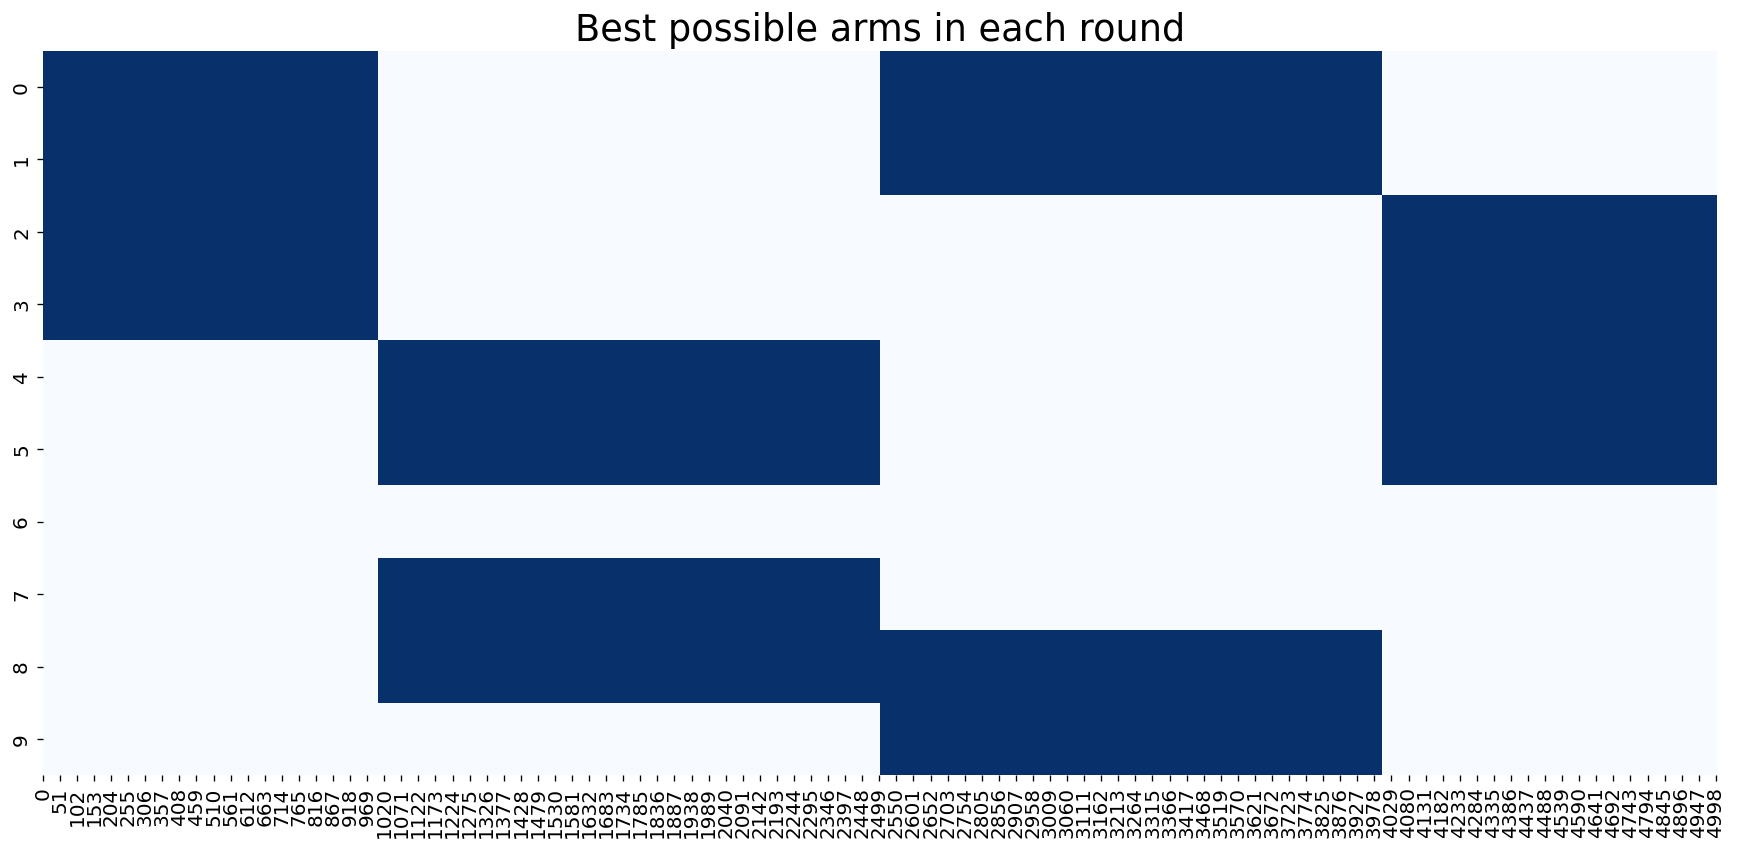

In [28]:
oracle_actions = best_action_choice[0]
for i in range(rounds):
    ch_p_ind = change_point_index(i)
    oracle_actions = np.concatenate((oracle_actions, best_action_choice[ch_p_ind]), axis=1)

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 120)
tttt=sns.heatmap(oracle_actions, cmap='Blues',linewidth=0.001, linecolor='k',cbar=False)

# Decorations
plt.title('Best possible arms in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig3.savefig(f"oracle_actions.jpg", format = 'jpg', dpi =120)

In [29]:
# Plot actions by our algorithm
fig3 = plt.figure(figsize=(18,8), dpi= 1200)
tttt=sns.heatmap(all_actions_taken, cmap='Blues', linewidth=0.01, linecolor='k', cbar=False)

# Decorations
plt.title('Chosen arms by NDC-SEM in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fig3.savefig(f"chosen_actions_d_{Delay}.jpg", format = 'jpg', dpi = 1500)

#### Plot Graph MSE

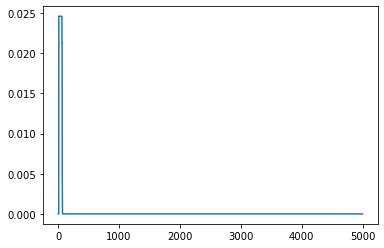

In [30]:
plt.plot(graph_mse[0])

## 2. Acting based on SEM-UCB

In [31]:
def UCB_func_semucb(t, x, num_plays_state, inst_reward, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
        
    delayed_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += inst_reward[k,j] * num_plays_state[k,:,j]

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_counts_state[j])
            
            inside_sqrt = (3 * np.log(t + 1)) / (2 * delayed_counts_state[j])
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp

        else:
            print("The given base arm is not pulled yet")

    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_counts_state[k] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_counts_state[k])
            
            inside_sqrt = (3 * np.log(t + 1)) / (2 * delayed_counts_state[k]) 
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp

        else:
            print("The given (not selected) base arm is not pulled yet")
     
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin


In [32]:
np.random.seed(1)

all_actions_taken_semucb = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
initial_rounds = nodes

best_lambda_semucb = 0.1
skiped_semucb = 0

In [33]:
# Our algorithm variables
f_measure_semucb = np.zeros((1, rounds)) 
collected_expected_rewards_semucb = np.zeros((1, rounds))
collected_instantaneous_rewards_semucb = np.zeros((1, rounds))
instantaneous_regret_semucb = np.zeros((1, rounds))
expected_regret_semucb = np.zeros((1, rounds))


#To record number of plays of each state #(B_signals.shape[0],1,num_rounds)
num_plays_state_semucb = np.zeros((nodes, 1, rounds)) 

#To record empirical average reward of each state #(B_signals.shape[0],1,num_rounds)
emp_avg_reward_state_semucb = np.zeros((nodes, 1, rounds))

#To record UCB index of each state #(B_signals.shape[0],1,num_rounds)
UCB_state_semucb = np.ones((nodes, 1, rounds))

In [34]:
base_reward_0_semucb = np.transpose(np.asarray([B[:,0]]))

Y_semucb = np.matmul(
    C_gt, np.multiply(base_reward_0_semucb, np.transpose(np.asarray([all_actions_taken_semucb[:,0]])))
)

action_0_semucb = np.transpose(np.asarray([all_actions_taken_semucb[:,0]]))

collected_expected_rewards_semucb[0,0] = overall_reward(x=action_0_semucb, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_semucb[0,0] = overall_reward(x=action_0_semucb, b=base_reward_0_semucb, A=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards_semucb[0,0])

expected_regret_semucb[0,0] = best_expected_reward[0] - collected_expected_rewards_semucb[0,0]

instantaneous_regret_semucb[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_semucb, A=w_gt
) - collected_instantaneous_rewards_semucb[0,0]

num_plays_state_semucb[:,:,0], emp_avg_reward_state_semucb[:,:,0], UCB_state_semucb[:,:,0] = UCB_func_semucb(
    t=0, x=all_actions_taken_semucb[:,0], num_plays_state=num_plays_state_semucb,
    inst_reward=B, Delay=Delay,
) 

################ initial rounds SEM-UCB ######################

for i in range(1,initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_semucb = np.transpose(np.asarray([B[:,i]]))
    x_i_semucb = np.transpose(np.asarray([all_actions_taken_semucb[:, i]]))  
    z_i_semucb = np.multiply(base_reward_i_semucb, x_i_semucb)
    
    y_i_semucb = np.matmul(C_gt, z_i_semucb)
    Y_semucb = np.concatenate((Y_semucb, y_i_semucb), axis=1)
    
    collected_expected_rewards_semucb[0,i] = overall_reward(x=x_i_semucb, b=mean_b_gt[ch_p_ind], A=w_gt) 
    collected_instantaneous_rewards_semucb[0,i] = overall_reward(x=x_i_semucb, b=base_reward_i_semucb, A=w_gt)
    
    expected_regret_semucb[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_semucb[0,i]
    instantaneous_regret_semucb[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_semucb, A=w_gt
    ) - collected_instantaneous_rewards_semucb[0, i]
    
    num_plays_state_semucb[:,:,i], emp_avg_reward_state_semucb[:,:,i], UCB_state_semucb[:,:,i] = UCB_func_semucb(
      t=i, x=all_actions_taken_semucb[:, i], num_plays_state=num_plays_state_semucb,
      inst_reward=B, Delay=Delay,
    )

    print('collected reward of round ', i , ' is ', collected_expected_rewards_semucb[0,i])


collected reward of round  0  is  0.8401672517614813
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The 

In [35]:
for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    # Matrix which columns are z_t values up to current moment. 
    # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
    Z_t_semucb = np.multiply(all_actions_taken_semucb, B[:, 0:all_actions_taken_semucb.shape[1]])
#     print('Z_t_semucb shape is ', Z_t_semucb.shape)

    if f_measure_semucb[0, i - 1] == 1:
        # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
        f_measure_semucb[0, i] = f_measure_semucb[0, i - 1]
    else:     
        w_hat_semucb, f_measure_semucb[0, i], best_lambda_semucb, _ = graph_learning(
            current_time=i, A_gt=w_gt, observ=Y_semucb, perturb=Z_t_semucb, 
            nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
        )
        if f_measure_semucb[0,i]>=0.9:
            skiped_semucb = 1
        elif f_measure_semucb[0,i]<0.9:
            skiped_semucb = 0
    
    base_reward_i_semucb = np.transpose(np.asarray([B[:,i]]))
    x_i_semucb = Best_action_func_new(A=w_hat_semucb, b=UCB_state_semucb[:,:,i - 1], s=super_arm_sparsity)
    all_actions_taken_semucb = np.concatenate((all_actions_taken_semucb, x_i_semucb), axis=1)

    z_i_semucb = np.multiply(base_reward_i_semucb, x_i_semucb)
    y_i_semucb = np.matmul(C_gt, z_i_semucb)
    Y_semucb = np.concatenate((Y_semucb, y_i_semucb), axis=1)
    
    collected_expected_rewards_semucb[0, i] = overall_reward(x=x_i_semucb, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_semucb[0, i] = overall_reward(x=x_i_semucb, b=base_reward_i_semucb, A=w_gt)
    expected_regret_semucb[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_semucb[0, i]
    instantaneous_regret_semucb[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_semucb, A=w_gt
    ) - collected_instantaneous_rewards_semucb[0,i]
    
    if expected_regret_semucb[0, i] < 0:
        raise ValueError()
    
    print(f'collected reward round {i} is: ', collected_expected_rewards_semucb[0, i])
    
    num_plays_state_semucb[:,:,i], emp_avg_reward_state_semucb[:,:,i], UCB_state_semucb[:,:,i] = UCB_func_semucb(
      t=i, x=x_i_semucb, num_plays_state=num_plays_state_semucb,
      inst_reward=B, Delay=Delay,
    )
	


collected reward round 10 is:  2.0942869272644407
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 11 is:  1.4916138915408803
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 40 is:  2.115880326065664
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 41 is:  1.9902915334010718
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm

collected reward round 67 is:  2.8252158394114337
collected reward round 68 is:  2.8252158394114337
collected reward round 69 is:  2.687726404720591
collected reward round 70 is:  2.687726404720591
collected reward round 71 is:  2.687726404720591
collected reward round 72 is:  2.687726404720591
collected reward round 73 is:  2.687726404720591
collected reward round 74 is:  2.687726404720591
collected reward round 75 is:  2.687726404720591
collected reward round 76 is:  2.7037700396285165
collected reward round 77 is:  2.7037700396285165
collected reward round 78 is:  2.63100040764615
collected reward round 79 is:  2.63100040764615
collected reward round 80 is:  1.213719643098644
collected reward round 81 is:  2.687726404720591
collected reward round 82 is:  2.687726404720591
collected reward round 83 is:  2.687726404720591
collected reward round 84 is:  2.687726404720591
collected reward round 85 is:  2.687726404720591
collected reward round 86 is:  2.687726404720591
collected reward r

collected reward round 229 is:  3.3673120653081923
collected reward round 230 is:  3.3673120653081923
collected reward round 231 is:  3.3280364741532997
collected reward round 232 is:  3.3280364741532997
collected reward round 233 is:  3.3280364741532997
collected reward round 234 is:  3.3280364741532997
collected reward round 235 is:  3.3280364741532997
collected reward round 236 is:  3.3280364741532997
collected reward round 237 is:  3.3280364741532997
collected reward round 238 is:  3.3280364741532997
collected reward round 239 is:  3.3280364741532997
collected reward round 240 is:  3.3280364741532997
collected reward round 241 is:  3.3280364741532997
collected reward round 242 is:  3.3280364741532997
collected reward round 243 is:  2.6306016028337806
collected reward round 244 is:  3.3280364741532997
collected reward round 245 is:  3.3280364741532997
collected reward round 246 is:  3.3280364741532997
collected reward round 247 is:  3.3280364741532997
collected reward round 248 is: 

collected reward round 393 is:  3.3833557002161174
collected reward round 394 is:  3.3833557002161174
collected reward round 395 is:  3.3833557002161174
collected reward round 396 is:  3.3833557002161174
collected reward round 397 is:  3.3833557002161174
collected reward round 398 is:  3.3833557002161174
collected reward round 399 is:  3.3833557002161174
collected reward round 400 is:  3.3833557002161174
collected reward round 401 is:  3.3833557002161174
collected reward round 402 is:  3.3833557002161174
collected reward round 403 is:  3.3833557002161174
collected reward round 404 is:  3.3833557002161174
collected reward round 405 is:  3.3833557002161174
collected reward round 406 is:  3.3833557002161174
collected reward round 407 is:  3.3833557002161174
collected reward round 408 is:  3.3833557002161174
collected reward round 409 is:  3.3833557002161174
collected reward round 410 is:  3.3833557002161174
collected reward round 411 is:  3.3833557002161174
collected reward round 412 is: 

collected reward round 556 is:  2.817647907712245
collected reward round 557 is:  2.817647907712245
collected reward round 558 is:  2.817647907712245
collected reward round 559 is:  2.817647907712245
collected reward round 560 is:  2.817647907712245
collected reward round 561 is:  2.817647907712245
collected reward round 562 is:  3.3833557002161174
collected reward round 563 is:  3.3833557002161174
collected reward round 564 is:  3.3833557002161174
collected reward round 565 is:  3.3833557002161174
collected reward round 566 is:  3.3833557002161174
collected reward round 567 is:  3.3833557002161174
collected reward round 568 is:  3.3833557002161174
collected reward round 569 is:  3.3833557002161174
collected reward round 570 is:  3.3833557002161174
collected reward round 571 is:  3.3833557002161174
collected reward round 572 is:  3.3833557002161174
collected reward round 573 is:  3.3833557002161174
collected reward round 574 is:  3.3833557002161174
collected reward round 575 is:  3.383

collected reward round 717 is:  3.3673120653081923
collected reward round 718 is:  3.3673120653081923
collected reward round 719 is:  3.3673120653081923
collected reward round 720 is:  3.3673120653081923
collected reward round 721 is:  3.3673120653081923
collected reward round 722 is:  3.3673120653081923
collected reward round 723 is:  3.3673120653081923
collected reward round 724 is:  3.3673120653081923
collected reward round 725 is:  3.3673120653081923
collected reward round 726 is:  3.3673120653081923
collected reward round 727 is:  3.3673120653081923
collected reward round 728 is:  3.3673120653081923
collected reward round 729 is:  3.3673120653081923
collected reward round 730 is:  3.3673120653081923
collected reward round 731 is:  3.3673120653081923
collected reward round 732 is:  3.3833557002161174
collected reward round 733 is:  3.3673120653081923
collected reward round 734 is:  3.3673120653081923
collected reward round 735 is:  3.3833557002161174
collected reward round 736 is: 

collected reward round 878 is:  3.3833557002161174
collected reward round 879 is:  3.3833557002161174
collected reward round 880 is:  3.3833557002161174
collected reward round 881 is:  3.3833557002161174
collected reward round 882 is:  3.3833557002161174
collected reward round 883 is:  3.3833557002161174
collected reward round 884 is:  3.3833557002161174
collected reward round 885 is:  3.3833557002161174
collected reward round 886 is:  3.3833557002161174
collected reward round 887 is:  3.3833557002161174
collected reward round 888 is:  3.3833557002161174
collected reward round 889 is:  3.3833557002161174
collected reward round 890 is:  3.3833557002161174
collected reward round 891 is:  3.3833557002161174
collected reward round 892 is:  3.3833557002161174
collected reward round 893 is:  3.3833557002161174
collected reward round 894 is:  3.3833557002161174
collected reward round 895 is:  3.3833557002161174
collected reward round 896 is:  3.3833557002161174
collected reward round 897 is: 

collected reward round 1038 is:  1.7881684720768136
collected reward round 1039 is:  1.7881684720768136
collected reward round 1040 is:  1.7881684720768136
collected reward round 1041 is:  1.7881684720768136
collected reward round 1042 is:  1.7881684720768136
collected reward round 1043 is:  1.7881684720768136
collected reward round 1044 is:  1.7881684720768136
collected reward round 1045 is:  1.7881684720768136
collected reward round 1046 is:  1.7881684720768136
collected reward round 1047 is:  1.7881684720768136
collected reward round 1048 is:  1.7881684720768136
collected reward round 1049 is:  1.7881684720768136
collected reward round 1050 is:  1.7881684720768136
collected reward round 1051 is:  1.7881684720768136
collected reward round 1052 is:  1.7881684720768136
collected reward round 1053 is:  1.7881684720768136
collected reward round 1054 is:  1.7881684720768136
collected reward round 1055 is:  1.7881684720768136
collected reward round 1056 is:  1.7881684720768136
collected re

collected reward round 1197 is:  2.9418180755638375
collected reward round 1198 is:  2.9418180755638375
collected reward round 1199 is:  2.9418180755638375
collected reward round 1200 is:  2.9418180755638375
collected reward round 1201 is:  2.9418180755638375
collected reward round 1202 is:  2.9418180755638375
collected reward round 1203 is:  2.9418180755638375
collected reward round 1204 is:  2.9418180755638375
collected reward round 1205 is:  2.9418180755638375
collected reward round 1206 is:  2.9418180755638375
collected reward round 1207 is:  2.9418180755638375
collected reward round 1208 is:  2.9418180755638375
collected reward round 1209 is:  2.9418180755638375
collected reward round 1210 is:  2.9418180755638375
collected reward round 1211 is:  2.9418180755638375
collected reward round 1212 is:  2.9418180755638375
collected reward round 1213 is:  2.9418180755638375
collected reward round 1214 is:  2.8946332719506525
collected reward round 1215 is:  2.8946332719506525
collected re

collected reward round 1355 is:  3.4233968044399545
collected reward round 1356 is:  3.4233968044399545
collected reward round 1357 is:  3.4233968044399545
collected reward round 1358 is:  3.4233968044399545
collected reward round 1359 is:  3.4233968044399545
collected reward round 1360 is:  3.4233968044399545
collected reward round 1361 is:  3.4233968044399545
collected reward round 1362 is:  3.4233968044399545
collected reward round 1363 is:  3.4233968044399545
collected reward round 1364 is:  3.4233968044399545
collected reward round 1365 is:  3.4233968044399545
collected reward round 1366 is:  3.4233968044399545
collected reward round 1367 is:  3.4233968044399545
collected reward round 1368 is:  3.4233968044399545
collected reward round 1369 is:  3.4233968044399545
collected reward round 1370 is:  3.4233968044399545
collected reward round 1371 is:  3.4233968044399545
collected reward round 1372 is:  3.4233968044399545
collected reward round 1373 is:  3.4233968044399545
collected re

collected reward round 1513 is:  3.5001875883869844
collected reward round 1514 is:  3.5001875883869844
collected reward round 1515 is:  3.5001875883869844
collected reward round 1516 is:  3.5001875883869844
collected reward round 1517 is:  3.5001875883869844
collected reward round 1518 is:  3.5001875883869844
collected reward round 1519 is:  3.5001875883869844
collected reward round 1520 is:  4.108610891198098
collected reward round 1521 is:  4.108610891198098
collected reward round 1522 is:  4.108610891198098
collected reward round 1523 is:  4.108610891198098
collected reward round 1524 is:  4.108610891198098
collected reward round 1525 is:  4.108610891198098
collected reward round 1526 is:  4.108610891198098
collected reward round 1527 is:  4.108610891198098
collected reward round 1528 is:  4.108610891198098
collected reward round 1529 is:  4.108610891198098
collected reward round 1530 is:  4.108610891198098
collected reward round 1531 is:  4.108610891198098
collected reward round 1

collected reward round 1678 is:  4.678867348679898
collected reward round 1679 is:  4.678867348679898
collected reward round 1680 is:  4.678867348679898
collected reward round 1681 is:  4.678867348679898
collected reward round 1682 is:  4.678867348679898
collected reward round 1683 is:  4.678867348679898
collected reward round 1684 is:  4.678867348679898
collected reward round 1685 is:  4.678867348679898
collected reward round 1686 is:  4.678867348679898
collected reward round 1687 is:  4.678867348679898
collected reward round 1688 is:  4.678867348679898
collected reward round 1689 is:  4.678867348679898
collected reward round 1690 is:  4.678867348679898
collected reward round 1691 is:  4.678867348679898
collected reward round 1692 is:  4.678867348679898
collected reward round 1693 is:  4.678867348679898
collected reward round 1694 is:  4.678867348679898
collected reward round 1695 is:  4.678867348679898
collected reward round 1696 is:  4.678867348679898
collected reward round 1697 is:

collected reward round 1842 is:  4.678867348679898
collected reward round 1843 is:  4.678867348679898
collected reward round 1844 is:  4.678867348679898
collected reward round 1845 is:  4.678867348679898
collected reward round 1846 is:  4.678867348679898
collected reward round 1847 is:  4.678867348679898
collected reward round 1848 is:  4.678867348679898
collected reward round 1849 is:  4.678867348679898
collected reward round 1850 is:  4.678867348679898
collected reward round 1851 is:  4.678867348679898
collected reward round 1852 is:  4.678867348679898
collected reward round 1853 is:  4.678867348679898
collected reward round 1854 is:  4.678867348679898
collected reward round 1855 is:  4.678867348679898
collected reward round 1856 is:  4.678867348679898
collected reward round 1857 is:  4.678867348679898
collected reward round 1858 is:  4.678867348679898
collected reward round 1859 is:  4.678867348679898
collected reward round 1860 is:  4.678867348679898
collected reward round 1861 is:

collected reward round 2007 is:  4.678867348679898
collected reward round 2008 is:  4.678867348679898
collected reward round 2009 is:  4.678867348679898
collected reward round 2010 is:  4.678867348679898
collected reward round 2011 is:  4.678867348679898
collected reward round 2012 is:  4.678867348679898
collected reward round 2013 is:  4.678867348679898
collected reward round 2014 is:  4.678867348679898
collected reward round 2015 is:  4.678867348679898
collected reward round 2016 is:  4.678867348679898
collected reward round 2017 is:  4.678867348679898
collected reward round 2018 is:  4.678867348679898
collected reward round 2019 is:  4.678867348679898
collected reward round 2020 is:  4.678867348679898
collected reward round 2021 is:  4.678867348679898
collected reward round 2022 is:  4.678867348679898
collected reward round 2023 is:  4.678867348679898
collected reward round 2024 is:  4.678867348679898
collected reward round 2025 is:  4.678867348679898
collected reward round 2026 is:

collected reward round 2172 is:  4.678867348679898
collected reward round 2173 is:  4.678867348679898
collected reward round 2174 is:  4.678867348679898
collected reward round 2175 is:  4.678867348679898
collected reward round 2176 is:  4.678867348679898
collected reward round 2177 is:  4.678867348679898
collected reward round 2178 is:  4.678867348679898
collected reward round 2179 is:  4.678867348679898
collected reward round 2180 is:  4.678867348679898
collected reward round 2181 is:  4.678867348679898
collected reward round 2182 is:  4.678867348679898
collected reward round 2183 is:  4.678867348679898
collected reward round 2184 is:  4.678867348679898
collected reward round 2185 is:  4.678867348679898
collected reward round 2186 is:  4.678867348679898
collected reward round 2187 is:  4.678867348679898
collected reward round 2188 is:  4.678867348679898
collected reward round 2189 is:  4.678867348679898
collected reward round 2190 is:  4.678867348679898
collected reward round 2191 is:

collected reward round 2336 is:  4.678867348679898
collected reward round 2337 is:  4.678867348679898
collected reward round 2338 is:  4.678867348679898
collected reward round 2339 is:  4.678867348679898
collected reward round 2340 is:  4.678867348679898
collected reward round 2341 is:  4.678867348679898
collected reward round 2342 is:  4.678867348679898
collected reward round 2343 is:  4.678867348679898
collected reward round 2344 is:  4.678867348679898
collected reward round 2345 is:  4.678867348679898
collected reward round 2346 is:  4.678867348679898
collected reward round 2347 is:  4.678867348679898
collected reward round 2348 is:  4.678867348679898
collected reward round 2349 is:  4.678867348679898
collected reward round 2350 is:  4.678867348679898
collected reward round 2351 is:  4.678867348679898
collected reward round 2352 is:  4.678867348679898
collected reward round 2353 is:  4.678867348679898
collected reward round 2354 is:  4.678867348679898
collected reward round 2355 is:

collected reward round 2497 is:  4.678867348679898
collected reward round 2498 is:  4.678867348679898
collected reward round 2499 is:  4.678867348679898
collected reward round 2500 is:  4.50086442609052
collected reward round 2501 is:  4.50086442609052
collected reward round 2502 is:  4.50086442609052
collected reward round 2503 is:  4.50086442609052
collected reward round 2504 is:  4.50086442609052
collected reward round 2505 is:  4.50086442609052
collected reward round 2506 is:  4.50086442609052
collected reward round 2507 is:  4.50086442609052
collected reward round 2508 is:  4.50086442609052
collected reward round 2509 is:  4.50086442609052
collected reward round 2510 is:  4.50086442609052
collected reward round 2511 is:  4.50086442609052
collected reward round 2512 is:  4.50086442609052
collected reward round 2513 is:  4.50086442609052
collected reward round 2514 is:  4.50086442609052
collected reward round 2515 is:  4.50086442609052
collected reward round 2516 is:  4.500864426090

collected reward round 2662 is:  4.50086442609052
collected reward round 2663 is:  4.50086442609052
collected reward round 2664 is:  4.50086442609052
collected reward round 2665 is:  4.50086442609052
collected reward round 2666 is:  4.50086442609052
collected reward round 2667 is:  4.50086442609052
collected reward round 2668 is:  4.50086442609052
collected reward round 2669 is:  4.50086442609052
collected reward round 2670 is:  4.50086442609052
collected reward round 2671 is:  4.50086442609052
collected reward round 2672 is:  4.50086442609052
collected reward round 2673 is:  4.50086442609052
collected reward round 2674 is:  4.50086442609052
collected reward round 2675 is:  4.50086442609052
collected reward round 2676 is:  4.50086442609052
collected reward round 2677 is:  4.50086442609052
collected reward round 2678 is:  4.50086442609052
collected reward round 2679 is:  4.50086442609052
collected reward round 2680 is:  4.50086442609052
collected reward round 2681 is:  4.50086442609052


collected reward round 2828 is:  4.50086442609052
collected reward round 2829 is:  4.50086442609052
collected reward round 2830 is:  4.50086442609052
collected reward round 2831 is:  4.50086442609052
collected reward round 2832 is:  4.50086442609052
collected reward round 2833 is:  4.50086442609052
collected reward round 2834 is:  4.50086442609052
collected reward round 2835 is:  4.50086442609052
collected reward round 2836 is:  4.50086442609052
collected reward round 2837 is:  4.50086442609052
collected reward round 2838 is:  4.50086442609052
collected reward round 2839 is:  4.50086442609052
collected reward round 2840 is:  4.50086442609052
collected reward round 2841 is:  4.50086442609052
collected reward round 2842 is:  4.50086442609052
collected reward round 2843 is:  4.50086442609052
collected reward round 2844 is:  4.50086442609052
collected reward round 2845 is:  4.50086442609052
collected reward round 2846 is:  4.50086442609052
collected reward round 2847 is:  4.50086442609052


collected reward round 2992 is:  4.427070187739198
collected reward round 2993 is:  4.427070187739198
collected reward round 2994 is:  4.427070187739198
collected reward round 2995 is:  4.427070187739198
collected reward round 2996 is:  4.427070187739198
collected reward round 2997 is:  4.427070187739198
collected reward round 2998 is:  4.427070187739198
collected reward round 2999 is:  4.427070187739198
collected reward round 3000 is:  4.427070187739198
collected reward round 3001 is:  5.031260032367028
collected reward round 3002 is:  5.031260032367028
collected reward round 3003 is:  4.427070187739198
collected reward round 3004 is:  4.427070187739198
collected reward round 3005 is:  4.427070187739198
collected reward round 3006 is:  4.427070187739198
collected reward round 3007 is:  4.427070187739198
collected reward round 3008 is:  4.427070187739198
collected reward round 3009 is:  4.427070187739198
collected reward round 3010 is:  4.427070187739198
collected reward round 3011 is:

collected reward round 3156 is:  5.031260032367028
collected reward round 3157 is:  5.031260032367028
collected reward round 3158 is:  5.031260032367028
collected reward round 3159 is:  5.031260032367028
collected reward round 3160 is:  5.031260032367028
collected reward round 3161 is:  5.031260032367028
collected reward round 3162 is:  5.031260032367028
collected reward round 3163 is:  5.031260032367028
collected reward round 3164 is:  5.031260032367028
collected reward round 3165 is:  5.031260032367028
collected reward round 3166 is:  5.031260032367028
collected reward round 3167 is:  5.031260032367028
collected reward round 3168 is:  5.031260032367028
collected reward round 3169 is:  5.031260032367028
collected reward round 3170 is:  5.031260032367028
collected reward round 3171 is:  5.031260032367028
collected reward round 3172 is:  5.031260032367028
collected reward round 3173 is:  5.031260032367028
collected reward round 3174 is:  5.031260032367028
collected reward round 3175 is:

collected reward round 3317 is:  5.031260032367028
collected reward round 3318 is:  5.031260032367028
collected reward round 3319 is:  5.031260032367028
collected reward round 3320 is:  5.031260032367028
collected reward round 3321 is:  5.031260032367028
collected reward round 3322 is:  5.031260032367028
collected reward round 3323 is:  5.031260032367028
collected reward round 3324 is:  5.031260032367028
collected reward round 3325 is:  5.031260032367028
collected reward round 3326 is:  5.031260032367028
collected reward round 3327 is:  5.031260032367028
collected reward round 3328 is:  5.031260032367028
collected reward round 3329 is:  5.031260032367028
collected reward round 3330 is:  5.031260032367028
collected reward round 3331 is:  5.031260032367028
collected reward round 3332 is:  5.031260032367028
collected reward round 3333 is:  5.031260032367028
collected reward round 3334 is:  5.031260032367028
collected reward round 3335 is:  5.031260032367028
collected reward round 3336 is:

collected reward round 3479 is:  5.031260032367028
collected reward round 3480 is:  5.031260032367028
collected reward round 3481 is:  5.031260032367028
collected reward round 3482 is:  5.031260032367028
collected reward round 3483 is:  5.031260032367028
collected reward round 3484 is:  5.031260032367028
collected reward round 3485 is:  5.031260032367028
collected reward round 3486 is:  5.031260032367028
collected reward round 3487 is:  5.031260032367028
collected reward round 3488 is:  5.031260032367028
collected reward round 3489 is:  5.031260032367028
collected reward round 3490 is:  5.031260032367028
collected reward round 3491 is:  5.031260032367028
collected reward round 3492 is:  5.031260032367028
collected reward round 3493 is:  5.031260032367028
collected reward round 3494 is:  5.031260032367028
collected reward round 3495 is:  5.031260032367028
collected reward round 3496 is:  5.031260032367028
collected reward round 3497 is:  5.031260032367028
collected reward round 3498 is:

collected reward round 3641 is:  5.106427138807282
collected reward round 3642 is:  5.106427138807282
collected reward round 3643 is:  5.106427138807282
collected reward round 3644 is:  5.106427138807282
collected reward round 3645 is:  5.106427138807282
collected reward round 3646 is:  5.106427138807282
collected reward round 3647 is:  5.106427138807282
collected reward round 3648 is:  5.106427138807282
collected reward round 3649 is:  5.106427138807282
collected reward round 3650 is:  5.106427138807282
collected reward round 3651 is:  5.106427138807282
collected reward round 3652 is:  5.106427138807282
collected reward round 3653 is:  5.106427138807282
collected reward round 3654 is:  5.106427138807282
collected reward round 3655 is:  5.106427138807282
collected reward round 3656 is:  5.106427138807282
collected reward round 3657 is:  5.106427138807282
collected reward round 3658 is:  5.106427138807282
collected reward round 3659 is:  5.106427138807282
collected reward round 3660 is:

collected reward round 3802 is:  5.03263290045596
collected reward round 3803 is:  5.03263290045596
collected reward round 3804 is:  5.03263290045596
collected reward round 3805 is:  5.03263290045596
collected reward round 3806 is:  5.03263290045596
collected reward round 3807 is:  5.03263290045596
collected reward round 3808 is:  5.03263290045596
collected reward round 3809 is:  5.03263290045596
collected reward round 3810 is:  5.03263290045596
collected reward round 3811 is:  5.03263290045596
collected reward round 3812 is:  5.121080511015849
collected reward round 3813 is:  5.121080511015849
collected reward round 3814 is:  5.121080511015849
collected reward round 3815 is:  5.121080511015849
collected reward round 3816 is:  5.121080511015849
collected reward round 3817 is:  5.121080511015849
collected reward round 3818 is:  5.121080511015849
collected reward round 3819 is:  5.121080511015849
collected reward round 3820 is:  5.121080511015849
collected reward round 3821 is:  5.121080

collected reward round 3963 is:  5.031260032367028
collected reward round 3964 is:  5.031260032367028
collected reward round 3965 is:  5.031260032367028
collected reward round 3966 is:  5.031260032367028
collected reward round 3967 is:  5.031260032367028
collected reward round 3968 is:  5.031260032367028
collected reward round 3969 is:  5.031260032367028
collected reward round 3970 is:  5.031260032367028
collected reward round 3971 is:  5.031260032367028
collected reward round 3972 is:  5.031260032367028
collected reward round 3973 is:  5.031260032367028
collected reward round 3974 is:  5.031260032367028
collected reward round 3975 is:  5.031260032367028
collected reward round 3976 is:  5.031260032367028
collected reward round 3977 is:  5.031260032367028
collected reward round 3978 is:  5.031260032367028
collected reward round 3979 is:  5.031260032367028
collected reward round 3980 is:  5.031260032367028
collected reward round 3981 is:  5.031260032367028
collected reward round 3982 is:

collected reward round 4124 is:  2.350988345340096
collected reward round 4125 is:  2.350988345340096
collected reward round 4126 is:  2.350988345340096
collected reward round 4127 is:  2.350988345340096
collected reward round 4128 is:  2.350988345340096
collected reward round 4129 is:  2.350988345340096
collected reward round 4130 is:  2.350988345340096
collected reward round 4131 is:  2.350988345340096
collected reward round 4132 is:  2.350988345340096
collected reward round 4133 is:  2.350988345340096
collected reward round 4134 is:  2.350988345340096
collected reward round 4135 is:  2.350988345340096
collected reward round 4136 is:  2.350988345340096
collected reward round 4137 is:  2.350988345340096
collected reward round 4138 is:  2.350988345340096
collected reward round 4139 is:  2.350988345340096
collected reward round 4140 is:  2.350988345340096
collected reward round 4141 is:  2.350988345340096
collected reward round 4142 is:  2.350988345340096
collected reward round 4143 is:

collected reward round 4283 is:  3.3631703953034653
collected reward round 4284 is:  3.3631703953034653
collected reward round 4285 is:  3.3631703953034653
collected reward round 4286 is:  3.3631703953034653
collected reward round 4287 is:  3.3631703953034653
collected reward round 4288 is:  3.3631703953034653
collected reward round 4289 is:  3.3631703953034653
collected reward round 4290 is:  3.3631703953034653
collected reward round 4291 is:  3.3631703953034653
collected reward round 4292 is:  3.3631703953034653
collected reward round 4293 is:  3.3631703953034653
collected reward round 4294 is:  3.3631703953034653
collected reward round 4295 is:  3.3631703953034653
collected reward round 4296 is:  3.3631703953034653
collected reward round 4297 is:  3.3631703953034653
collected reward round 4298 is:  3.3631703953034653
collected reward round 4299 is:  3.3631703953034653
collected reward round 4300 is:  3.3631703953034653
collected reward round 4301 is:  3.3631703953034653
collected re

collected reward round 4442 is:  3.504239919645968
collected reward round 4443 is:  3.504239919645968
collected reward round 4444 is:  3.504239919645968
collected reward round 4445 is:  3.504239919645968
collected reward round 4446 is:  3.504239919645968
collected reward round 4447 is:  3.504239919645968
collected reward round 4448 is:  3.504239919645968
collected reward round 4449 is:  3.504239919645968
collected reward round 4450 is:  3.504239919645968
collected reward round 4451 is:  3.504239919645968
collected reward round 4452 is:  3.504239919645968
collected reward round 4453 is:  3.504239919645968
collected reward round 4454 is:  3.504239919645968
collected reward round 4455 is:  3.504239919645968
collected reward round 4456 is:  3.504239919645968
collected reward round 4457 is:  3.504239919645968
collected reward round 4458 is:  3.504239919645968
collected reward round 4459 is:  3.504239919645968
collected reward round 4460 is:  3.504239919645968
collected reward round 4461 is:

collected reward round 4605 is:  3.504239919645968
collected reward round 4606 is:  3.504239919645968
collected reward round 4607 is:  3.504239919645968
collected reward round 4608 is:  3.504239919645968
collected reward round 4609 is:  3.504239919645968
collected reward round 4610 is:  3.504239919645968
collected reward round 4611 is:  3.504239919645968
collected reward round 4612 is:  3.504239919645968
collected reward round 4613 is:  3.504239919645968
collected reward round 4614 is:  3.504239919645968
collected reward round 4615 is:  3.504239919645968
collected reward round 4616 is:  3.504239919645968
collected reward round 4617 is:  3.504239919645968
collected reward round 4618 is:  3.504239919645968
collected reward round 4619 is:  3.504239919645968
collected reward round 4620 is:  3.504239919645968
collected reward round 4621 is:  3.504239919645968
collected reward round 4622 is:  3.504239919645968
collected reward round 4623 is:  3.504239919645968
collected reward round 4624 is:

collected reward round 4766 is:  3.504239919645968
collected reward round 4767 is:  3.504239919645968
collected reward round 4768 is:  3.504239919645968
collected reward round 4769 is:  3.504239919645968
collected reward round 4770 is:  3.504239919645968
collected reward round 4771 is:  3.504239919645968
collected reward round 4772 is:  3.504239919645968
collected reward round 4773 is:  3.504239919645968
collected reward round 4774 is:  3.504239919645968
collected reward round 4775 is:  3.504239919645968
collected reward round 4776 is:  3.504239919645968
collected reward round 4777 is:  3.504239919645968
collected reward round 4778 is:  3.504239919645968
collected reward round 4779 is:  3.504239919645968
collected reward round 4780 is:  3.504239919645968
collected reward round 4781 is:  3.504239919645968
collected reward round 4782 is:  3.504239919645968
collected reward round 4783 is:  3.504239919645968
collected reward round 4784 is:  3.504239919645968
collected reward round 4785 is:

collected reward round 4928 is:  3.504239919645968
collected reward round 4929 is:  3.504239919645968
collected reward round 4930 is:  3.504239919645968
collected reward round 4931 is:  3.504239919645968
collected reward round 4932 is:  3.504239919645968
collected reward round 4933 is:  3.504239919645968
collected reward round 4934 is:  3.504239919645968
collected reward round 4935 is:  3.504239919645968
collected reward round 4936 is:  3.504239919645968
collected reward round 4937 is:  3.504239919645968
collected reward round 4938 is:  3.504239919645968
collected reward round 4939 is:  3.504239919645968
collected reward round 4940 is:  3.504239919645968
collected reward round 4941 is:  3.504239919645968
collected reward round 4942 is:  3.504239919645968
collected reward round 4943 is:  3.504239919645968
collected reward round 4944 is:  3.504239919645968
collected reward round 4945 is:  3.504239919645968
collected reward round 4946 is:  3.504239919645968
collected reward round 4947 is:

In [36]:
# Plot actions by SEM-UCB
fig3 = plt.figure(figsize=(18,8), dpi= 1000)
tttt=sns.heatmap(all_actions_taken_semucb, cmap='Blues', linewidth=0.01, linecolor='k', cbar=False)

# Decorations
plt.title('Chosen arms by SEM-UCB', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


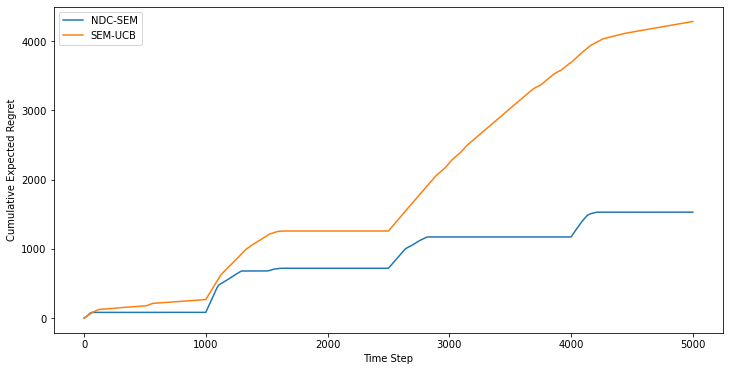

In [37]:
fig = plt.figure(figsize=(12, 6))


plt.plot(np.cumsum(expected_regret[0]), label='NDC-SEM')
plt.plot(np.cumsum(expected_regret_semucb[0]), label='SEM-UCB')



plt.ylabel('Cumulative Expected Regret')
plt.xlabel('Time Step')
plt.legend()
plt.show()

## 3. Acting uniformely at random

In [38]:
# Uniformly at random taken actions 

randomly_taken_actions = create_random_action(n=rounds)
collected_expected_random_rewards = np.zeros((1, rounds))
collected_instantaneous_random_rewards = np.zeros((1, rounds))
expected_random_regret = np.zeros((1, rounds))
instantaneous_random_regret = np.zeros((1, rounds))

for i in range(rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i = np.transpose(np.asarray([B[:, i]]))
    
    x_i = np.transpose(np.asarray([randomly_taken_actions[:, i]]))
    
    collected_instantaneous_random_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    collected_expected_random_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    expected_random_regret[0, i] = best_expected_reward[ch_p_ind] - collected_expected_random_rewards[0,i] 
    instantaneous_random_regret[0 ,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_random_rewards[0,i]


## 4. Acting based on Chen's algorithm (CUCB)

Acting naively based on Chen algorithm for the y feedbacks

In [39]:
np.random.seed(42)

##################   UCB  function as part of decision making strategy
def UCB_func_chen(t, x, num_plays_state, inst_reward, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((nodes, 1))
    UCB_state_builtin = np.ones((nodes, 1))
    
    delayed_counts_state = np.zeros(nodes) # Denominator of empirical reward
    for k in range(nodes):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]
    
    
    emp_avg_reward_state_temp = np.zeros(nodes) # Numerator of emprical reward
    for k in range(nodes):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += inst_reward[k, j] * num_plays_state[k, :, j]
    
    array_indices_of_chosen_base_arms = np.where(x != 0)[0]
    for i in range(array_indices_of_chosen_base_arms.shape[0]):
        j = array_indices_of_chosen_base_arms[i]
        
        if delayed_counts_state[j] != 0:
            emp_avg_reward_state_builtin[j, 0] = emp_avg_reward_state_temp[j] / (delayed_counts_state[j])

            UCB_state_builtin[j, 0] = emp_avg_reward_state_builtin[j, 0] + np.sqrt(
                (3 * np.log(t)) / (2 * (delayed_counts_state[j]))
            )
            UCB_state_builtin[j, 0] = min(1, UCB_state_builtin[j, 0])
        else:
            print(f"The selected arm {j} is not pulled yet")
    ######################################################
    array_indices_of_not_chosen_base_arms = np.where(x == 0)[0]
    for i in range(array_indices_of_not_chosen_base_arms.shape[0]):
        jj = array_indices_of_not_chosen_base_arms[i]
        if delayed_counts_state[jj] != 0:
            emp_avg_reward_state_builtin[jj, 0] = emp_avg_reward_state_temp[jj] / (delayed_counts_state[jj])
            
            UCB_state_builtin[jj, 0] = emp_avg_reward_state_builtin[jj, 0] + np.sqrt(
                (3 * np.log(t )) / (2 * delayed_counts_state[jj])
            )
            UCB_state_builtin[jj, 0] = min(1, UCB_state_builtin[jj, 0])
            
        else:
            print(f"The not selected arm {jj} is not pulled yet")
    
    new_num_plays_state = (np.asanyarray([x])).T.astype(int)
            
    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin

In [40]:
collected_expected_rewards_chen = np.zeros((1, rounds))
collected_instantaneous_rewards_chen = np.zeros((1, rounds))
expected_regret_chen = np.zeros((1, rounds))
instantaneous_regret_chen = np.zeros((1, rounds))

num_plays_state_chen = np.zeros((nodes, 1, rounds))
emp_avg_reward_state_chen = np.zeros((nodes, 1, rounds)) 
UCB_state_chen = np.ones((nodes, 1, rounds)) #b_hat = np.ones((nodes,1))


################## initializaion chen ######################

all_actions_taken_chen = create_random_action(n=initial_rounds)

base_reward_0_chen = np.transpose(np.asarray([B[:, 0]]))
x_0_chen = np.transpose(np.asarray([all_actions_taken_chen[:, 0]]))

Y_chen = np.matmul(C_gt, np.multiply(base_reward_0_chen, x_0_chen))


collected_expected_rewards_chen[0, 0] = overall_reward(x=x_0_chen, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_chen[0, i] = overall_reward(x=x_0_chen, b=base_reward_0_chen, A=w_gt)
expected_regret_chen[0, i] = best_expected_reward[0] - collected_expected_rewards_chen[0, 0]
instantaneous_regret_chen[0, i] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_chen, A=w_gt
) - collected_instantaneous_rewards_chen[0, i]

print('collected reward of round ', 0 , ' is ', collected_expected_rewards_chen[0, 0])
num_plays_state_chen[:,:,0], emp_avg_reward_state_chen[:,:,0], UCB_state_chen[:,:,0] = UCB_func_chen(
    t=0, x=x_0_chen, num_plays_state=num_plays_state_chen, inst_reward=Y_chen, Delay=Delay,
) 

################### acting based on Chen's algorithm ##################

def best_action_Chen(y, s=super_arm_sparsity): 
    ind = np.argsort(y, axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0]=1
    
    if (y == y[0]).all():
            print(f'All UCBs are same, taking random action')
            np.random.shuffle(x)
    
    return x

#######################################################################

for i in range(1, rounds):
    ch_p_ind = change_point_index(i)
    
    if i < initial_rounds:
        # Use random actions from initialization
        x_i = np.transpose(np.asarray([all_actions_taken_chen[:, i]]))
    else:
        x_i = best_action_Chen(y=UCB_state_chen[:,:, i - 1], s = super_arm_sparsity)
        all_actions_taken_chen = np.concatenate((all_actions_taken_chen, x_i), axis=1)
        
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    z_i = np.multiply(base_reward_i, x_i)
    y_i = np.matmul(C_gt, z_i)
    
    Y_chen = np.concatenate((Y_chen, y_i), axis=1)
    
    collected_expected_rewards_chen[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_chen[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    expected_regret_chen[0, i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_chen[0, i]
    instantaneous_regret_chen[0, i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards_chen[0, i]
    
    print(f'collected reward round {i} is: ', collected_expected_rewards_chen[0, i])
    
    (
        num_plays_state_chen[:,:,i],
        emp_avg_reward_state_chen[:,:,i],
        UCB_state_chen[:,:,i],
    ) = UCB_func_chen(
        t=i, x=x_i, num_plays_state=num_plays_state_chen, inst_reward=Y_chen, Delay=Delay,
    )


collected reward of round  0  is  2.613151196914232
The selected arm 1 is not pulled yet
The selected arm 3 is not pulled yet
The selected arm 5 is not pulled yet
The selected arm 8 is not pulled yet
The not selected arm 0 is not pulled yet
The not selected arm 2 is not pulled yet
The not selected arm 4 is not pulled yet
The not selected arm 6 is not pulled yet
The not selected arm 7 is not pulled yet
The not selected arm 9 is not pulled yet
collected reward round 1 is:  2.253369760756507
The selected arm 0 is not pulled yet
The selected arm 1 is not pulled yet
The selected arm 4 is not pulled yet
The selected arm 9 is not pulled yet
The not selected arm 2 is not pulled yet
The not selected arm 3 is not pulled yet
The not selected arm 5 is not pulled yet
The not selected arm 6 is not pulled yet
The not selected arm 7 is not pulled yet
The not selected arm 8 is not pulled yet
collected reward round 2 is:  2.6242342158332383
The selected arm 1 is not pulled yet
The selected arm 2 is not 

collected reward round 165 is:  3.504801499999035
collected reward round 166 is:  3.504801499999035
collected reward round 167 is:  3.504801499999035
collected reward round 168 is:  3.504801499999035
collected reward round 169 is:  3.504801499999035
collected reward round 170 is:  3.504801499999035
collected reward round 171 is:  3.504801499999035
collected reward round 172 is:  3.504801499999035
collected reward round 173 is:  3.504801499999035
collected reward round 174 is:  3.504801499999035
collected reward round 175 is:  3.504801499999035
collected reward round 176 is:  3.504801499999035
collected reward round 177 is:  3.504801499999035
collected reward round 178 is:  3.504801499999035
collected reward round 179 is:  3.504801499999035
collected reward round 180 is:  3.504801499999035
collected reward round 181 is:  3.504801499999035
collected reward round 182 is:  3.504801499999035
collected reward round 183 is:  3.504801499999035
collected reward round 184 is:  3.504801499999035


collected reward round 342 is:  3.504801499999035
collected reward round 343 is:  3.504801499999035
collected reward round 344 is:  3.504801499999035
collected reward round 345 is:  3.504801499999035
collected reward round 346 is:  3.504801499999035
collected reward round 347 is:  3.504801499999035
collected reward round 348 is:  3.504801499999035
collected reward round 349 is:  3.504801499999035
collected reward round 350 is:  3.504801499999035
collected reward round 351 is:  3.504801499999035
collected reward round 352 is:  3.504801499999035
collected reward round 353 is:  3.504801499999035
collected reward round 354 is:  3.504801499999035
collected reward round 355 is:  3.504801499999035
collected reward round 356 is:  3.504801499999035
collected reward round 357 is:  3.504801499999035
collected reward round 358 is:  3.504801499999035
collected reward round 359 is:  3.504801499999035
collected reward round 360 is:  3.504801499999035
collected reward round 361 is:  3.504801499999035


collected reward round 526 is:  3.504801499999035
collected reward round 527 is:  3.504801499999035
collected reward round 528 is:  3.504801499999035
collected reward round 529 is:  3.504801499999035
collected reward round 530 is:  3.504801499999035
collected reward round 531 is:  3.504801499999035
collected reward round 532 is:  3.504801499999035
collected reward round 533 is:  3.504801499999035
collected reward round 534 is:  3.504801499999035
collected reward round 535 is:  3.504801499999035
collected reward round 536 is:  3.504801499999035
collected reward round 537 is:  3.504801499999035
collected reward round 538 is:  3.504801499999035
collected reward round 539 is:  3.504801499999035
collected reward round 540 is:  3.504801499999035
collected reward round 541 is:  3.504801499999035
collected reward round 542 is:  3.504801499999035
collected reward round 543 is:  3.504801499999035
collected reward round 544 is:  3.504801499999035
collected reward round 545 is:  3.504801499999035


collected reward round 691 is:  3.504801499999035
collected reward round 692 is:  3.504801499999035
collected reward round 693 is:  3.504801499999035
collected reward round 694 is:  3.504801499999035
collected reward round 695 is:  3.504801499999035
collected reward round 696 is:  3.504801499999035
collected reward round 697 is:  3.504801499999035
collected reward round 698 is:  3.504801499999035
collected reward round 699 is:  3.504801499999035
collected reward round 700 is:  3.504801499999035
collected reward round 701 is:  3.504801499999035
collected reward round 702 is:  3.504801499999035
collected reward round 703 is:  3.504801499999035
collected reward round 704 is:  3.504801499999035
collected reward round 705 is:  3.504801499999035
collected reward round 706 is:  3.504801499999035
collected reward round 707 is:  3.504801499999035
collected reward round 708 is:  3.504801499999035
collected reward round 709 is:  3.504801499999035
collected reward round 710 is:  3.504801499999035


collected reward round 868 is:  3.504801499999035
collected reward round 869 is:  3.504801499999035
collected reward round 870 is:  3.504801499999035
collected reward round 871 is:  3.504801499999035
collected reward round 872 is:  3.504801499999035
collected reward round 873 is:  3.504801499999035
collected reward round 874 is:  3.504801499999035
collected reward round 875 is:  3.504801499999035
collected reward round 876 is:  3.504801499999035
collected reward round 877 is:  3.504801499999035
collected reward round 878 is:  3.504801499999035
collected reward round 879 is:  3.504801499999035
collected reward round 880 is:  3.504801499999035
collected reward round 881 is:  3.504801499999035
collected reward round 882 is:  3.504801499999035
collected reward round 883 is:  3.504801499999035
collected reward round 884 is:  3.504801499999035
collected reward round 885 is:  3.504801499999035
collected reward round 886 is:  3.504801499999035
collected reward round 887 is:  3.504801499999035


collected reward round 1040 is:  0.7965173915878101
collected reward round 1041 is:  0.7965173915878101
collected reward round 1042 is:  0.7965173915878101
collected reward round 1043 is:  0.7965173915878101
collected reward round 1044 is:  0.7965173915878101
collected reward round 1045 is:  0.7965173915878101
collected reward round 1046 is:  0.7965173915878101
collected reward round 1047 is:  0.7965173915878101
collected reward round 1048 is:  0.7965173915878101
collected reward round 1049 is:  0.7965173915878101
collected reward round 1050 is:  0.7965173915878101
collected reward round 1051 is:  0.7965173915878101
collected reward round 1052 is:  0.7965173915878101
collected reward round 1053 is:  0.7965173915878101
collected reward round 1054 is:  0.7965173915878101
collected reward round 1055 is:  0.7965173915878101
collected reward round 1056 is:  0.7965173915878101
collected reward round 1057 is:  0.7965173915878101
collected reward round 1058 is:  0.7965173915878101
collected re

collected reward round 1202 is:  1.4750406833188827
collected reward round 1203 is:  1.4750406833188827
collected reward round 1204 is:  1.4750406833188827
collected reward round 1205 is:  1.4750406833188827
collected reward round 1206 is:  1.4750406833188827
collected reward round 1207 is:  1.4750406833188827
collected reward round 1208 is:  1.4750406833188827
collected reward round 1209 is:  1.4750406833188827
collected reward round 1210 is:  1.4750406833188827
collected reward round 1211 is:  1.4750406833188827
collected reward round 1212 is:  1.4750406833188827
collected reward round 1213 is:  1.4750406833188827
collected reward round 1214 is:  1.4750406833188827
collected reward round 1215 is:  1.4750406833188827
collected reward round 1216 is:  1.4750406833188827
collected reward round 1217 is:  1.4750406833188827
collected reward round 1218 is:  1.4750406833188827
collected reward round 1219 is:  1.4750406833188827
collected reward round 1220 is:  1.4750406833188827
collected re

collected reward round 1362 is:  1.5222254869320675
collected reward round 1363 is:  1.5222254869320675
collected reward round 1364 is:  1.5222254869320675
collected reward round 1365 is:  1.5222254869320675
collected reward round 1366 is:  1.5222254869320675
collected reward round 1367 is:  1.5222254869320675
collected reward round 1368 is:  1.5222254869320675
collected reward round 1369 is:  1.5222254869320675
collected reward round 1370 is:  1.5222254869320675
collected reward round 1371 is:  1.5222254869320675
collected reward round 1372 is:  1.5222254869320675
collected reward round 1373 is:  1.5222254869320675
collected reward round 1374 is:  1.5222254869320675
collected reward round 1375 is:  1.5222254869320675
collected reward round 1376 is:  1.5222254869320675
collected reward round 1377 is:  1.5222254869320675
collected reward round 1378 is:  1.5990162708790976
collected reward round 1379 is:  1.5990162708790976
collected reward round 1380 is:  1.5990162708790976
collected re

collected reward round 1523 is:  2.77769603117201
collected reward round 1524 is:  2.77769603117201
collected reward round 1525 is:  2.77769603117201
collected reward round 1526 is:  2.77769603117201
collected reward round 1527 is:  2.77769603117201
collected reward round 1528 is:  2.77769603117201
collected reward round 1529 is:  2.77769603117201
collected reward round 1530 is:  2.77769603117201
collected reward round 1531 is:  2.77769603117201
collected reward round 1532 is:  2.77769603117201
collected reward round 1533 is:  2.77769603117201
collected reward round 1534 is:  2.77769603117201
collected reward round 1535 is:  2.77769603117201
collected reward round 1536 is:  2.77769603117201
collected reward round 1537 is:  2.77769603117201
collected reward round 1538 is:  2.77769603117201
collected reward round 1539 is:  2.77769603117201
collected reward round 1540 is:  2.77769603117201
collected reward round 1541 is:  2.77769603117201
collected reward round 1542 is:  2.77769603117201


collected reward round 1692 is:  3.2659655550751983
collected reward round 1693 is:  3.2659655550751983
collected reward round 1694 is:  3.2659655550751983
collected reward round 1695 is:  3.2659655550751983
collected reward round 1696 is:  3.2659655550751983
collected reward round 1697 is:  3.2659655550751983
collected reward round 1698 is:  3.2659655550751983
collected reward round 1699 is:  3.2659655550751983
collected reward round 1700 is:  3.2659655550751983
collected reward round 1701 is:  3.1419899675149834
collected reward round 1702 is:  3.1419899675149834
collected reward round 1703 is:  3.1419899675149834
collected reward round 1704 is:  3.1419899675149834
collected reward round 1705 is:  3.2659655550751983
collected reward round 1706 is:  3.1419899675149834
collected reward round 1707 is:  3.1419899675149834
collected reward round 1708 is:  3.2659655550751983
collected reward round 1709 is:  3.2659655550751983
collected reward round 1710 is:  3.1419899675149834
collected re

collected reward round 1852 is:  3.2659655550751983
collected reward round 1853 is:  3.2659655550751983
collected reward round 1854 is:  3.2659655550751983
collected reward round 1855 is:  3.2659655550751983
collected reward round 1856 is:  3.2659655550751983
collected reward round 1857 is:  3.2659655550751983
collected reward round 1858 is:  3.2659655550751983
collected reward round 1859 is:  3.2659655550751983
collected reward round 1860 is:  3.2659655550751983
collected reward round 1861 is:  3.2659655550751983
collected reward round 1862 is:  3.2659655550751983
collected reward round 1863 is:  3.2659655550751983
collected reward round 1864 is:  3.2659655550751983
collected reward round 1865 is:  3.2659655550751983
collected reward round 1866 is:  3.2659655550751983
collected reward round 1867 is:  3.2659655550751983
collected reward round 1868 is:  3.2659655550751983
collected reward round 1869 is:  3.2659655550751983
collected reward round 1870 is:  3.2659655550751983
collected re

collected reward round 2015 is:  3.2659655550751983
collected reward round 2016 is:  3.2659655550751983
collected reward round 2017 is:  3.2659655550751983
collected reward round 2018 is:  3.2659655550751983
collected reward round 2019 is:  3.2659655550751983
collected reward round 2020 is:  3.2659655550751983
collected reward round 2021 is:  3.2659655550751983
collected reward round 2022 is:  3.2659655550751983
collected reward round 2023 is:  3.2659655550751983
collected reward round 2024 is:  3.2659655550751983
collected reward round 2025 is:  3.2659655550751983
collected reward round 2026 is:  3.2659655550751983
collected reward round 2027 is:  3.2659655550751983
collected reward round 2028 is:  3.2659655550751983
collected reward round 2029 is:  3.2659655550751983
collected reward round 2030 is:  3.2659655550751983
collected reward round 2031 is:  3.2659655550751983
collected reward round 2032 is:  3.2659655550751983
collected reward round 2033 is:  3.2659655550751983
collected re

collected reward round 2177 is:  3.2659655550751983
collected reward round 2178 is:  3.2659655550751983
collected reward round 2179 is:  3.2659655550751983
collected reward round 2180 is:  3.2659655550751983
collected reward round 2181 is:  3.2659655550751983
collected reward round 2182 is:  3.2659655550751983
collected reward round 2183 is:  3.2659655550751983
collected reward round 2184 is:  3.2659655550751983
collected reward round 2185 is:  3.2659655550751983
collected reward round 2186 is:  3.2659655550751983
collected reward round 2187 is:  3.2659655550751983
collected reward round 2188 is:  3.2659655550751983
collected reward round 2189 is:  3.2659655550751983
collected reward round 2190 is:  3.2659655550751983
collected reward round 2191 is:  3.2659655550751983
collected reward round 2192 is:  3.2659655550751983
collected reward round 2193 is:  3.2659655550751983
collected reward round 2194 is:  3.2659655550751983
collected reward round 2195 is:  3.2659655550751983
collected re

collected reward round 2338 is:  3.2659655550751983
collected reward round 2339 is:  3.2659655550751983
collected reward round 2340 is:  3.2659655550751983
collected reward round 2341 is:  3.2659655550751983
collected reward round 2342 is:  3.2659655550751983
collected reward round 2343 is:  3.2659655550751983
collected reward round 2344 is:  3.2659655550751983
collected reward round 2345 is:  3.2659655550751983
collected reward round 2346 is:  3.2659655550751983
collected reward round 2347 is:  3.2659655550751983
collected reward round 2348 is:  3.2659655550751983
collected reward round 2349 is:  3.2659655550751983
collected reward round 2350 is:  3.2659655550751983
collected reward round 2351 is:  3.2659655550751983
collected reward round 2352 is:  3.2659655550751983
collected reward round 2353 is:  3.2659655550751983
collected reward round 2354 is:  3.2659655550751983
collected reward round 2355 is:  3.2659655550751983
collected reward round 2356 is:  3.2659655550751983
collected re

collected reward round 2499 is:  3.2659655550751983
collected reward round 2500 is:  1.5123218742185385
collected reward round 2501 is:  1.5123218742185385
collected reward round 2502 is:  1.5123218742185385
collected reward round 2503 is:  1.5123218742185385
collected reward round 2504 is:  1.5123218742185385
collected reward round 2505 is:  1.5123218742185385
collected reward round 2506 is:  1.5123218742185385
collected reward round 2507 is:  1.5123218742185385
collected reward round 2508 is:  1.5123218742185385
collected reward round 2509 is:  1.5123218742185385
collected reward round 2510 is:  1.5123218742185385
collected reward round 2511 is:  1.5123218742185385
collected reward round 2512 is:  1.5123218742185385
collected reward round 2513 is:  1.5123218742185385
collected reward round 2514 is:  1.5123218742185385
collected reward round 2515 is:  1.5123218742185385
collected reward round 2516 is:  1.5123218742185385
collected reward round 2517 is:  1.5123218742185385
collected re

collected reward round 2660 is:  1.5123218742185385
collected reward round 2661 is:  1.5123218742185385
collected reward round 2662 is:  1.5123218742185385
collected reward round 2663 is:  1.5123218742185385
collected reward round 2664 is:  1.5123218742185385
collected reward round 2665 is:  1.5123218742185385
collected reward round 2666 is:  1.5123218742185385
collected reward round 2667 is:  1.5123218742185385
collected reward round 2668 is:  1.5123218742185385
collected reward round 2669 is:  1.5123218742185385
collected reward round 2670 is:  1.5123218742185385
collected reward round 2671 is:  1.5123218742185385
collected reward round 2672 is:  1.5123218742185385
collected reward round 2673 is:  1.5123218742185385
collected reward round 2674 is:  1.5123218742185385
collected reward round 2675 is:  1.5123218742185385
collected reward round 2676 is:  1.5123218742185385
collected reward round 2677 is:  1.5123218742185385
collected reward round 2678 is:  1.5123218742185385
collected re

collected reward round 2818 is:  5.106427138807282
collected reward round 2819 is:  5.106427138807282
collected reward round 2820 is:  5.106427138807282
collected reward round 2821 is:  5.106427138807282
collected reward round 2822 is:  5.106427138807282
collected reward round 2823 is:  5.106427138807282
collected reward round 2824 is:  5.106427138807282
collected reward round 2825 is:  5.106427138807282
collected reward round 2826 is:  5.106427138807282
collected reward round 2827 is:  5.106427138807282
collected reward round 2828 is:  5.106427138807282
collected reward round 2829 is:  5.106427138807282
collected reward round 2830 is:  5.106427138807282
collected reward round 2831 is:  5.106427138807282
collected reward round 2832 is:  5.106427138807282
collected reward round 2833 is:  5.106427138807282
collected reward round 2834 is:  5.106427138807282
collected reward round 2835 is:  5.106427138807282
collected reward round 2836 is:  5.106427138807282
collected reward round 2837 is:

collected reward round 2982 is:  5.106427138807282
collected reward round 2983 is:  5.106427138807282
collected reward round 2984 is:  5.106427138807282
collected reward round 2985 is:  5.106427138807282
collected reward round 2986 is:  5.106427138807282
collected reward round 2987 is:  5.106427138807282
collected reward round 2988 is:  5.106427138807282
collected reward round 2989 is:  5.106427138807282
collected reward round 2990 is:  5.106427138807282
collected reward round 2991 is:  5.106427138807282
collected reward round 2992 is:  5.106427138807282
collected reward round 2993 is:  5.106427138807282
collected reward round 2994 is:  5.106427138807282
collected reward round 2995 is:  5.106427138807282
collected reward round 2996 is:  5.106427138807282
collected reward round 2997 is:  5.106427138807282
collected reward round 2998 is:  5.106427138807282
collected reward round 2999 is:  5.106427138807282
collected reward round 3000 is:  5.106427138807282
collected reward round 3001 is:

collected reward round 3146 is:  5.106427138807282
collected reward round 3147 is:  5.106427138807282
collected reward round 3148 is:  5.106427138807282
collected reward round 3149 is:  5.106427138807282
collected reward round 3150 is:  5.106427138807282
collected reward round 3151 is:  5.106427138807282
collected reward round 3152 is:  5.106427138807282
collected reward round 3153 is:  5.106427138807282
collected reward round 3154 is:  5.106427138807282
collected reward round 3155 is:  5.106427138807282
collected reward round 3156 is:  5.106427138807282
collected reward round 3157 is:  5.106427138807282
collected reward round 3158 is:  5.106427138807282
collected reward round 3159 is:  5.106427138807282
collected reward round 3160 is:  5.106427138807282
collected reward round 3161 is:  5.106427138807282
collected reward round 3162 is:  5.106427138807282
collected reward round 3163 is:  5.106427138807282
collected reward round 3164 is:  5.031260032367028
collected reward round 3165 is:

collected reward round 3307 is:  5.6690618810940805
collected reward round 3308 is:  5.6690618810940805
collected reward round 3309 is:  5.6690618810940805
collected reward round 3310 is:  5.6690618810940805
collected reward round 3311 is:  5.6690618810940805
collected reward round 3312 is:  5.6690618810940805
collected reward round 3313 is:  5.6690618810940805
collected reward round 3314 is:  5.6690618810940805
collected reward round 3315 is:  5.6690618810940805
collected reward round 3316 is:  5.6690618810940805
collected reward round 3317 is:  5.6690618810940805
collected reward round 3318 is:  5.6690618810940805
collected reward round 3319 is:  5.6690618810940805
collected reward round 3320 is:  5.6690618810940805
collected reward round 3321 is:  5.6690618810940805
collected reward round 3322 is:  5.6690618810940805
collected reward round 3323 is:  5.6690618810940805
collected reward round 3324 is:  5.6690618810940805
collected reward round 3325 is:  5.6690618810940805
collected re

collected reward round 3468 is:  5.6690618810940805
collected reward round 3469 is:  5.6690618810940805
collected reward round 3470 is:  5.6690618810940805
collected reward round 3471 is:  5.6690618810940805
collected reward round 3472 is:  5.6690618810940805
collected reward round 3473 is:  5.6690618810940805
collected reward round 3474 is:  5.6690618810940805
collected reward round 3475 is:  5.6690618810940805
collected reward round 3476 is:  5.6690618810940805
collected reward round 3477 is:  5.6690618810940805
collected reward round 3478 is:  5.6690618810940805
collected reward round 3479 is:  5.6690618810940805
collected reward round 3480 is:  5.6690618810940805
collected reward round 3481 is:  5.6690618810940805
collected reward round 3482 is:  5.6690618810940805
collected reward round 3483 is:  5.6690618810940805
collected reward round 3484 is:  5.6690618810940805
collected reward round 3485 is:  5.6690618810940805
collected reward round 3486 is:  5.6690618810940805
collected re

collected reward round 3628 is:  5.6690618810940805
collected reward round 3629 is:  5.6690618810940805
collected reward round 3630 is:  5.6690618810940805
collected reward round 3631 is:  5.6690618810940805
collected reward round 3632 is:  5.6690618810940805
collected reward round 3633 is:  5.6690618810940805
collected reward round 3634 is:  5.6690618810940805
collected reward round 3635 is:  5.6690618810940805
collected reward round 3636 is:  5.6690618810940805
collected reward round 3637 is:  5.6690618810940805
collected reward round 3638 is:  5.6690618810940805
collected reward round 3639 is:  5.6690618810940805
collected reward round 3640 is:  5.6690618810940805
collected reward round 3641 is:  5.6690618810940805
collected reward round 3642 is:  5.6690618810940805
collected reward round 3643 is:  5.6690618810940805
collected reward round 3644 is:  5.6690618810940805
collected reward round 3645 is:  5.6690618810940805
collected reward round 3646 is:  5.6690618810940805
collected re

collected reward round 3788 is:  5.6690618810940805
collected reward round 3789 is:  5.6690618810940805
collected reward round 3790 is:  5.6690618810940805
collected reward round 3791 is:  5.6690618810940805
collected reward round 3792 is:  5.6690618810940805
collected reward round 3793 is:  5.6690618810940805
collected reward round 3794 is:  5.6690618810940805
collected reward round 3795 is:  5.6690618810940805
collected reward round 3796 is:  5.6690618810940805
collected reward round 3797 is:  5.6690618810940805
collected reward round 3798 is:  5.6690618810940805
collected reward round 3799 is:  5.6690618810940805
collected reward round 3800 is:  5.6690618810940805
collected reward round 3801 is:  5.6690618810940805
collected reward round 3802 is:  5.6690618810940805
collected reward round 3803 is:  5.6690618810940805
collected reward round 3804 is:  5.6690618810940805
collected reward round 3805 is:  5.6690618810940805
collected reward round 3806 is:  5.6690618810940805
collected re

collected reward round 3948 is:  5.6690618810940805
collected reward round 3949 is:  5.6690618810940805
collected reward round 3950 is:  5.6690618810940805
collected reward round 3951 is:  5.6690618810940805
collected reward round 3952 is:  5.6690618810940805
collected reward round 3953 is:  5.6690618810940805
collected reward round 3954 is:  5.6690618810940805
collected reward round 3955 is:  5.6690618810940805
collected reward round 3956 is:  5.6690618810940805
collected reward round 3957 is:  5.6690618810940805
collected reward round 3958 is:  5.6690618810940805
collected reward round 3959 is:  5.6690618810940805
collected reward round 3960 is:  5.6690618810940805
collected reward round 3961 is:  5.6690618810940805
collected reward round 3962 is:  5.6690618810940805
collected reward round 3963 is:  5.6690618810940805
collected reward round 3964 is:  5.6690618810940805
collected reward round 3965 is:  5.6690618810940805
collected reward round 3966 is:  5.6690618810940805
collected re

collected reward round 4109 is:  2.142299226136448
collected reward round 4110 is:  2.142299226136448
collected reward round 4111 is:  2.142299226136448
collected reward round 4112 is:  2.142299226136448
collected reward round 4113 is:  2.142299226136448
collected reward round 4114 is:  2.142299226136448
collected reward round 4115 is:  2.142299226136448
collected reward round 4116 is:  2.142299226136448
collected reward round 4117 is:  2.142299226136448
collected reward round 4118 is:  2.142299226136448
collected reward round 4119 is:  2.142299226136448
collected reward round 4120 is:  2.142299226136448
collected reward round 4121 is:  2.142299226136448
collected reward round 4122 is:  2.142299226136448
collected reward round 4123 is:  2.142299226136448
collected reward round 4124 is:  2.142299226136448
collected reward round 4125 is:  2.142299226136448
collected reward round 4126 is:  2.142299226136448
collected reward round 4127 is:  2.142299226136448
collected reward round 4128 is:

collected reward round 4270 is:  2.142299226136448
collected reward round 4271 is:  2.142299226136448
collected reward round 4272 is:  2.142299226136448
collected reward round 4273 is:  2.142299226136448
collected reward round 4274 is:  2.142299226136448
collected reward round 4275 is:  2.142299226136448
collected reward round 4276 is:  2.142299226136448
collected reward round 4277 is:  2.142299226136448
collected reward round 4278 is:  2.142299226136448
collected reward round 4279 is:  2.142299226136448
collected reward round 4280 is:  2.142299226136448
collected reward round 4281 is:  2.142299226136448
collected reward round 4282 is:  2.142299226136448
collected reward round 4283 is:  2.142299226136448
collected reward round 4284 is:  2.142299226136448
collected reward round 4285 is:  2.142299226136448
collected reward round 4286 is:  2.142299226136448
collected reward round 4287 is:  2.142299226136448
collected reward round 4288 is:  2.142299226136448
collected reward round 4289 is:

collected reward round 4431 is:  2.529483377234027
collected reward round 4432 is:  2.529483377234027
collected reward round 4433 is:  2.529483377234027
collected reward round 4434 is:  2.529483377234027
collected reward round 4435 is:  2.529483377234027
collected reward round 4436 is:  2.529483377234027
collected reward round 4437 is:  2.529483377234027
collected reward round 4438 is:  2.529483377234027
collected reward round 4439 is:  2.529483377234027
collected reward round 4440 is:  2.529483377234027
collected reward round 4441 is:  2.529483377234027
collected reward round 4442 is:  2.529483377234027
collected reward round 4443 is:  2.529483377234027
collected reward round 4444 is:  2.529483377234027
collected reward round 4445 is:  2.529483377234027
collected reward round 4446 is:  2.529483377234027
collected reward round 4447 is:  2.529483377234027
collected reward round 4448 is:  2.529483377234027
collected reward round 4449 is:  2.529483377234027
collected reward round 4450 is:

collected reward round 4593 is:  2.529483377234027
collected reward round 4594 is:  2.529483377234027
collected reward round 4595 is:  2.529483377234027
collected reward round 4596 is:  2.529483377234027
collected reward round 4597 is:  2.529483377234027
collected reward round 4598 is:  2.529483377234027
collected reward round 4599 is:  2.529483377234027
collected reward round 4600 is:  2.529483377234027
collected reward round 4601 is:  2.529483377234027
collected reward round 4602 is:  2.529483377234027
collected reward round 4603 is:  2.529483377234027
collected reward round 4604 is:  2.529483377234027
collected reward round 4605 is:  2.529483377234027
collected reward round 4606 is:  2.529483377234027
collected reward round 4607 is:  2.529483377234027
collected reward round 4608 is:  2.529483377234027
collected reward round 4609 is:  2.529483377234027
collected reward round 4610 is:  2.529483377234027
collected reward round 4611 is:  2.529483377234027
collected reward round 4612 is:

collected reward round 4754 is:  2.529483377234027
collected reward round 4755 is:  2.529483377234027
collected reward round 4756 is:  2.529483377234027
collected reward round 4757 is:  2.529483377234027
collected reward round 4758 is:  2.529483377234027
collected reward round 4759 is:  2.529483377234027
collected reward round 4760 is:  2.529483377234027
collected reward round 4761 is:  2.529483377234027
collected reward round 4762 is:  2.529483377234027
collected reward round 4763 is:  2.529483377234027
collected reward round 4764 is:  2.529483377234027
collected reward round 4765 is:  2.529483377234027
collected reward round 4766 is:  2.529483377234027
collected reward round 4767 is:  2.529483377234027
collected reward round 4768 is:  2.529483377234027
collected reward round 4769 is:  2.529483377234027
collected reward round 4770 is:  2.529483377234027
collected reward round 4771 is:  2.529483377234027
collected reward round 4772 is:  2.529483377234027
collected reward round 4773 is:

collected reward round 4917 is:  2.529483377234027
collected reward round 4918 is:  2.529483377234027
collected reward round 4919 is:  2.529483377234027
collected reward round 4920 is:  2.529483377234027
collected reward round 4921 is:  2.529483377234027
collected reward round 4922 is:  2.529483377234027
collected reward round 4923 is:  2.529483377234027
collected reward round 4924 is:  2.529483377234027
collected reward round 4925 is:  2.529483377234027
collected reward round 4926 is:  2.529483377234027
collected reward round 4927 is:  2.529483377234027
collected reward round 4928 is:  2.529483377234027
collected reward round 4929 is:  2.529483377234027
collected reward round 4930 is:  2.529483377234027
collected reward round 4931 is:  2.529483377234027
collected reward round 4932 is:  2.529483377234027
collected reward round 4933 is:  2.529483377234027
collected reward round 4934 is:  2.529483377234027
collected reward round 4935 is:  2.529483377234027
collected reward round 4936 is:

## 5. Implementation of CTS with normalized y_{i}

In [41]:
###################### the following must be executed at the beginning of each decision making point 
#posterior_cts = np.zeros((nodes,1))
#for i in range(nodes):
#    posterior_cts[i,0] = np.random.beta(a_it[i,0], b_it[i,0], size=1)
    
############################################ 
# def CTS_update(a_it, b_it, action_vector, x_mean_cts, t, T_cts):

#     action_vector = np.asarray([action_vector]).T 
#     for i in range(nodes):
        
#         if action_vector[i,0]!=0:
#             x_mean_cts[i,0]=(x_mean_cts[i,0] * T_cts[i,0] + B[i,t]) / (T_cts[i,0]+1)
#             T_cts[i,0]+=1
#             temp80 = np.random.binomial(size=1,n=1,p=x_mean_cts[i,0])
#             a_it[i,0] = a_it[i,0] + temp80
#             b_it[i,0] = b_it[i,0] + 1-temp80

#     return a_it, b_it, x_mean_cts, T_cts
    

In [42]:
def biggest_y_i(s=super_arm_sparsity):
    b_max_i = np.transpose(np.asarray([np.amax(B, axis=1)]))
    b_diag = np.diagflat(b_max_i) 
    C = np.matmul(C_gt, b_diag)
    C_sorted = np.sort(C)
    temp_C_biggest = C_sorted[:,-s:]
    temp_biggest_sum = np.cumsum(temp_C_biggest,axis=1)
    y_max_i = (np.transpose(np.asarray([temp_biggest_sum[:,-1]])))
    
    return y_max_i


def best_action_pcts(y, s = super_arm_sparsity): 
    
    ind = np.argsort(y, axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i], 0]=1
    
    return x

def PCTS_update(a_it, b_it, action_vector, x_mean_pcts, t, num_plays_state, Delay):
    global Y_pcts_normal 
    
    delayed_counts_state = np.ones(nodes) # Denominator of empirical reward
    for k in range(nodes):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]
    
    
    emp_avg_reward_state_temp = np.zeros(nodes) # Numerator of emprical reward
    for k in range(nodes):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += Y_pcts_normal[k, j] * num_plays_state[k, :, j]
    
    
    action_vector = np.asarray([action_vector]).T 
    for i in range(nodes):
        
        if action_vector[i, 0] != 0:            
            x_mean_pcts[i, 0] = emp_avg_reward_state_temp[i] / (delayed_counts_state[i])
            
            temp80 = np.random.binomial(size=1, n=1, p=x_mean_pcts[i,0])
            a_it[i, 0] = a_it[i, 0] + temp80
            b_it[i, 0] = b_it[i, 0] + (1 - temp80)
    
    new_num_plays_state = (np.asanyarray([action_vector])).T.astype(int)
    
    return new_num_plays_state, a_it, b_it, x_mean_pcts

#### acting based on Huyuk's algorithm (CTS) for the y feedbacks


In [43]:
np.random.seed(42)

########## CTS  function as part of decision making strategy ##########################

y_i_max = biggest_y_i();

collected_rewards_pcts = np.zeros((1,rounds)) 

collected_expected_rewards_pcts = np.zeros((1, rounds))
collected_instantaneous_rewards_pcts = np.zeros((1, rounds))
expected_regret_pcts = np.zeros((1, rounds))
instantaneous_regret_pcts = np.zeros((1, rounds))

a_it = np.ones((nodes,1))
b_it = np.ones((nodes,1))
num_plays_state_pcts = np.zeros((nodes, 1, rounds))

################## initial rounds PCTS ######################

all_actions_taken_pcts = create_random_action(n=initial_rounds)
base_reward_0_pcts = np.transpose(np.asarray([B[:,0]]))

x_0_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,0]]))
z_0_pcts = np.multiply(base_reward_0_pcts, x_0_pcts)
y_0_pcts = np.matmul(C_gt, z_0_pcts)

Y_pcts = y_0_pcts
Y_pcts_normal = np.divide(y_0_pcts, y_i_max)

x_mean_pcts = np.ones((nodes, 1))*0.5 #np.asarray([B[:,0]]).T

#for i in range(Y_pcts.shape[0]):
#    y_hat_pcts[i,0] = Y_pcts[i,0]


collected_expected_rewards_pcts[0,0] = overall_reward(x=x_0_pcts, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_pcts[0,0] = overall_reward(x=x_0_pcts, b=base_reward_0_pcts, A=w_gt)
expected_regret_pcts[0,0] = best_expected_reward[0] - collected_expected_rewards_pcts[0,0]
instantaneous_regret_pcts[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_pcts, A=w_gt
) - collected_instantaneous_rewards_pcts[0,0]
print('collected reward of round  ', 0  ,' is: ', collected_expected_rewards_pcts[0,0])


num_plays_state_pcts[:,:,0], a_it, b_it, x_mean_pcts = PCTS_update(
    a_it=a_it, b_it=b_it, action_vector=x_0_pcts.T, 
    x_mean_pcts=x_mean_pcts, t=0, num_plays_state=num_plays_state_pcts, Delay=Delay,
) 

################ initial rounds pcts ######################

for i in range(1, initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_pcts = np.transpose(np.asarray([B[:,i]]))

    x_i_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,i]]))
    z_i_pcts = np.multiply(base_reward_i_pcts, x_i_pcts)
    y_i_pcts = np.matmul(C_gt, z_i_pcts)
    Y_pcts = np.concatenate((Y_pcts, y_i_pcts), axis=1)
    
    y_i_pcts_normal = np.divide(y_i_pcts, y_i_max)
    Y_pcts_normal = np.concatenate((Y_pcts_normal, y_i_pcts_normal), axis=1)
    
    collected_expected_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=base_reward_i_pcts, A=w_gt)
    expected_regret_pcts[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_pcts[0,i]
    instantaneous_regret_pcts[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_pcts, A=w_gt
    ) - collected_instantaneous_rewards_pcts[0,i]
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_pcts[0,i])

    
    num_plays_state_pcts[:,:,i], a_it, b_it, x_mean_pcts = PCTS_update(
        a_it=a_it, b_it=b_it, action_vector=x_i_pcts.T,
        x_mean_pcts=x_mean_pcts, t=i, num_plays_state=num_plays_state_pcts, Delay=Delay,
    ) 

################### acting based on CTS algorithm ##################
####################################################################

for i in range(initial_rounds,rounds):
    ch_p_ind = change_point_index(i)
    
#     temporary_pcts = np.multiply(all_actions_taken_pcts,B[:,0:all_actions_taken_pcts.shape[1]])
    posterior_pcts = np.zeros((nodes,1))
    for jj in range(nodes):
        posterior_pcts[jj, 0] = np.random.beta(a_it[jj,0], b_it[jj,0], size=1)
    
    x_i_pcts = best_action_pcts(y=posterior_pcts, s = super_arm_sparsity)
    all_actions_taken_pcts = np.concatenate((all_actions_taken_pcts, x_i_pcts), axis=1)
    
    base_reward_i_pcts = np.transpose(np.asarray([B[:, i]]))
    
    z_i_pcts = np.multiply(base_reward_i_pcts, x_i_pcts)
    y_i_pcts = np.matmul(C_gt, z_i_pcts)
    Y_pcts = np.concatenate((Y_pcts, y_i_pcts), axis=1)
    
    y_i_pcts_normal = np.divide(y_i_pcts, y_i_max)
    Y_pcts_normal = np.concatenate((Y_pcts_normal, y_i_pcts_normal), axis=1)
    
    collected_expected_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=base_reward_i_pcts, A=w_gt)
    expected_regret_pcts[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_pcts[0,i]
    instantaneous_regret_pcts[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_pcts, A=w_gt
    ) - collected_instantaneous_rewards_pcts[0,i]
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_pcts[0,i])

    num_plays_state_pcts[:,:,i], a_it, b_it, x_mean_pcts = PCTS_update(
        a_it=a_it, b_it=b_it, action_vector=x_i_pcts.T, 
        x_mean_pcts=x_mean_pcts, t=i, num_plays_state=num_plays_state_pcts, Delay=Delay,
    ) 


collected reward of round   0  is:  2.613151196914232
collected reward of round   1  is:  2.253369760756507
collected reward of round   2  is:  2.6242342158332383
collected reward of round   3  is:  2.014751103469163
collected reward of round   4  is:  2.0412780491368276
collected reward of round   5  is:  1.4813326125081514
collected reward of round   6  is:  2.2354934809021114
collected reward of round   7  is:  2.2112768831696514
collected reward of round   8  is:  2.7056026845749868
collected reward of round   9  is:  2.1849328391012026
collected reward of round   10  is:  2.365414983893765
collected reward of round   11  is:  2.064893810329908
collected reward of round   12  is:  2.817647907712245
collected reward of round   13  is:  1.4017967887128737
collected reward of round   14  is:  1.5557057885875
collected reward of round   15  is:  1.9107557096057939
collected reward of round   16  is:  2.744878275729879
collected reward of round   17  is:  3.3105860682337513
collected re

collected reward of round   158  is:  2.1232462260378426
collected reward of round   159  is:  2.7056026845749868
collected reward of round   160  is:  2.1232462260378426
collected reward of round   161  is:  2.8823677104207217
collected reward of round   162  is:  2.1232462260378426
collected reward of round   163  is:  2.1232462260378426
collected reward of round   164  is:  2.1232462260378426
collected reward of round   165  is:  2.7056026845749868
collected reward of round   166  is:  2.1296136130383845
collected reward of round   167  is:  2.1232462260378426
collected reward of round   168  is:  2.7056026845749868
collected reward of round   169  is:  2.1232462260378426
collected reward of round   170  is:  2.1232462260378426
collected reward of round   171  is:  2.1232462260378426
collected reward of round   172  is:  2.8823677104207217
collected reward of round   173  is:  2.1232462260378426
collected reward of round   174  is:  2.1232462260378426
collected reward of round   175

collected reward of round   335  is:  2.8077654334918853
collected reward of round   336  is:  2.8823677104207217
collected reward of round   337  is:  2.8077654334918853
collected reward of round   338  is:  2.8823677104207217
collected reward of round   339  is:  2.8823677104207217
collected reward of round   340  is:  2.8823677104207217
collected reward of round   341  is:  2.8823677104207217
collected reward of round   342  is:  2.8823677104207217
collected reward of round   343  is:  2.8823677104207217
collected reward of round   344  is:  2.8823677104207217
collected reward of round   345  is:  2.8823677104207217
collected reward of round   346  is:  2.8823677104207217
collected reward of round   347  is:  2.8823677104207217
collected reward of round   348  is:  3.3105860682337513
collected reward of round   349  is:  2.8823677104207217
collected reward of round   350  is:  2.8823677104207217
collected reward of round   351  is:  2.8823677104207217
collected reward of round   352

collected reward of round   502  is:  2.8823677104207217
collected reward of round   503  is:  2.8823677104207217
collected reward of round   504  is:  2.8823677104207217
collected reward of round   505  is:  2.8823677104207217
collected reward of round   506  is:  2.8823677104207217
collected reward of round   507  is:  3.3105860682337513
collected reward of round   508  is:  2.8823677104207217
collected reward of round   509  is:  2.8823677104207217
collected reward of round   510  is:  2.8823677104207217
collected reward of round   511  is:  2.8823677104207217
collected reward of round   512  is:  2.8823677104207217
collected reward of round   513  is:  2.8823677104207217
collected reward of round   514  is:  2.8823677104207217
collected reward of round   515  is:  2.8823677104207217
collected reward of round   516  is:  2.8823677104207217
collected reward of round   517  is:  2.8823677104207217
collected reward of round   518  is:  2.8823677104207217
collected reward of round   519

collected reward of round   650  is:  2.8823677104207217
collected reward of round   651  is:  2.8823677104207217
collected reward of round   652  is:  2.8823677104207217
collected reward of round   653  is:  3.504801499999035
collected reward of round   654  is:  2.8823677104207217
collected reward of round   655  is:  2.8823677104207217
collected reward of round   656  is:  2.8823677104207217
collected reward of round   657  is:  2.8823677104207217
collected reward of round   658  is:  2.8823677104207217
collected reward of round   659  is:  3.504801499999035
collected reward of round   660  is:  2.8823677104207217
collected reward of round   661  is:  2.8823677104207217
collected reward of round   662  is:  3.3105860682337513
collected reward of round   663  is:  2.8823677104207217
collected reward of round   664  is:  2.8823677104207217
collected reward of round   665  is:  2.8823677104207217
collected reward of round   666  is:  2.8823677104207217
collected reward of round   667  

collected reward of round   806  is:  3.504801499999035
collected reward of round   807  is:  3.504801499999035
collected reward of round   808  is:  3.504801499999035
collected reward of round   809  is:  3.504801499999035
collected reward of round   810  is:  3.504801499999035
collected reward of round   811  is:  3.504801499999035
collected reward of round   812  is:  3.504801499999035
collected reward of round   813  is:  3.504801499999035
collected reward of round   814  is:  3.504801499999035
collected reward of round   815  is:  3.504801499999035
collected reward of round   816  is:  3.504801499999035
collected reward of round   817  is:  3.504801499999035
collected reward of round   818  is:  3.504801499999035
collected reward of round   819  is:  3.504801499999035
collected reward of round   820  is:  3.504801499999035
collected reward of round   821  is:  3.504801499999035
collected reward of round   822  is:  3.504801499999035
collected reward of round   823  is:  3.50480149

collected reward of round   962  is:  3.504801499999035
collected reward of round   963  is:  3.504801499999035
collected reward of round   964  is:  3.504801499999035
collected reward of round   965  is:  3.504801499999035
collected reward of round   966  is:  3.504801499999035
collected reward of round   967  is:  3.504801499999035
collected reward of round   968  is:  3.504801499999035
collected reward of round   969  is:  3.504801499999035
collected reward of round   970  is:  3.504801499999035
collected reward of round   971  is:  3.504801499999035
collected reward of round   972  is:  3.504801499999035
collected reward of round   973  is:  3.504801499999035
collected reward of round   974  is:  3.504801499999035
collected reward of round   975  is:  3.504801499999035
collected reward of round   976  is:  3.504801499999035
collected reward of round   977  is:  3.504801499999035
collected reward of round   978  is:  3.504801499999035
collected reward of round   979  is:  3.50480149

collected reward of round   1108  is:  0.7965173915878101
collected reward of round   1109  is:  0.7965173915878101
collected reward of round   1110  is:  0.7965173915878101
collected reward of round   1111  is:  0.7965173915878101
collected reward of round   1112  is:  0.7965173915878101
collected reward of round   1113  is:  0.7965173915878101
collected reward of round   1114  is:  0.7965173915878101
collected reward of round   1115  is:  0.7965173915878101
collected reward of round   1116  is:  0.7965173915878101
collected reward of round   1117  is:  0.7965173915878101
collected reward of round   1118  is:  0.7965173915878101
collected reward of round   1119  is:  0.7965173915878101
collected reward of round   1120  is:  0.7965173915878101
collected reward of round   1121  is:  0.7965173915878101
collected reward of round   1122  is:  0.7965173915878101
collected reward of round   1123  is:  0.7965173915878101
collected reward of round   1124  is:  0.7965173915878101
collected rewa

collected reward of round   1255  is:  0.7965173915878101
collected reward of round   1256  is:  0.7965173915878101
collected reward of round   1257  is:  0.7965173915878101
collected reward of round   1258  is:  0.7965173915878101
collected reward of round   1259  is:  0.7965173915878101
collected reward of round   1260  is:  0.7965173915878101
collected reward of round   1261  is:  0.7965173915878101
collected reward of round   1262  is:  0.7965173915878101
collected reward of round   1263  is:  0.7965173915878101
collected reward of round   1264  is:  0.7965173915878101
collected reward of round   1265  is:  0.7965173915878101
collected reward of round   1266  is:  0.7965173915878101
collected reward of round   1267  is:  0.7965173915878101
collected reward of round   1268  is:  0.7965173915878101
collected reward of round   1269  is:  0.7965173915878101
collected reward of round   1270  is:  0.7965173915878101
collected reward of round   1271  is:  0.7965173915878101
collected rewa

collected reward of round   1402  is:  0.7965173915878101
collected reward of round   1403  is:  0.7965173915878101
collected reward of round   1404  is:  0.7965173915878101
collected reward of round   1405  is:  0.7965173915878101
collected reward of round   1406  is:  0.7965173915878101
collected reward of round   1407  is:  0.7965173915878101
collected reward of round   1408  is:  0.7965173915878101
collected reward of round   1409  is:  0.7965173915878101
collected reward of round   1410  is:  0.7965173915878101
collected reward of round   1411  is:  0.7965173915878101
collected reward of round   1412  is:  0.7965173915878101
collected reward of round   1413  is:  0.7965173915878101
collected reward of round   1414  is:  0.7965173915878101
collected reward of round   1415  is:  0.7965173915878101
collected reward of round   1416  is:  0.7965173915878101
collected reward of round   1417  is:  0.7965173915878101
collected reward of round   1418  is:  0.7965173915878101
collected rewa

collected reward of round   1549  is:  0.7965173915878101
collected reward of round   1550  is:  0.7965173915878101
collected reward of round   1551  is:  0.7965173915878101
collected reward of round   1552  is:  0.7965173915878101
collected reward of round   1553  is:  0.7965173915878101
collected reward of round   1554  is:  0.7965173915878101
collected reward of round   1555  is:  0.7965173915878101
collected reward of round   1556  is:  0.7965173915878101
collected reward of round   1557  is:  0.7965173915878101
collected reward of round   1558  is:  0.7965173915878101
collected reward of round   1559  is:  0.7965173915878101
collected reward of round   1560  is:  0.7965173915878101
collected reward of round   1561  is:  0.7965173915878101
collected reward of round   1562  is:  0.7965173915878101
collected reward of round   1563  is:  0.7965173915878101
collected reward of round   1564  is:  0.7965173915878101
collected reward of round   1565  is:  0.7965173915878101
collected rewa

collected reward of round   1692  is:  0.7965173915878101
collected reward of round   1693  is:  0.7965173915878101
collected reward of round   1694  is:  0.7965173915878101
collected reward of round   1695  is:  0.7965173915878101
collected reward of round   1696  is:  0.7965173915878101
collected reward of round   1697  is:  0.7965173915878101
collected reward of round   1698  is:  0.7965173915878101
collected reward of round   1699  is:  0.7965173915878101
collected reward of round   1700  is:  0.7965173915878101
collected reward of round   1701  is:  0.7965173915878101
collected reward of round   1702  is:  0.7965173915878101
collected reward of round   1703  is:  0.7965173915878101
collected reward of round   1704  is:  0.7965173915878101
collected reward of round   1705  is:  0.7965173915878101
collected reward of round   1706  is:  0.7965173915878101
collected reward of round   1707  is:  0.7965173915878101
collected reward of round   1708  is:  0.7965173915878101
collected rewa

collected reward of round   1838  is:  0.7965173915878101
collected reward of round   1839  is:  0.7965173915878101
collected reward of round   1840  is:  0.7965173915878101
collected reward of round   1841  is:  0.7965173915878101
collected reward of round   1842  is:  0.7965173915878101
collected reward of round   1843  is:  0.7965173915878101
collected reward of round   1844  is:  0.7965173915878101
collected reward of round   1845  is:  0.7965173915878101
collected reward of round   1846  is:  0.7965173915878101
collected reward of round   1847  is:  0.7965173915878101
collected reward of round   1848  is:  0.7965173915878101
collected reward of round   1849  is:  0.7965173915878101
collected reward of round   1850  is:  0.7965173915878101
collected reward of round   1851  is:  0.7965173915878101
collected reward of round   1852  is:  0.7965173915878101
collected reward of round   1853  is:  0.7965173915878101
collected reward of round   1854  is:  0.7965173915878101
collected rewa

collected reward of round   1983  is:  0.7965173915878101
collected reward of round   1984  is:  0.7965173915878101
collected reward of round   1985  is:  0.7965173915878101
collected reward of round   1986  is:  0.7965173915878101
collected reward of round   1987  is:  0.7965173915878101
collected reward of round   1988  is:  0.7965173915878101
collected reward of round   1989  is:  0.7965173915878101
collected reward of round   1990  is:  0.7965173915878101
collected reward of round   1991  is:  0.7965173915878101
collected reward of round   1992  is:  0.7965173915878101
collected reward of round   1993  is:  0.7965173915878101
collected reward of round   1994  is:  0.7965173915878101
collected reward of round   1995  is:  0.7965173915878101
collected reward of round   1996  is:  0.7965173915878101
collected reward of round   1997  is:  0.7965173915878101
collected reward of round   1998  is:  0.7965173915878101
collected reward of round   1999  is:  0.7965173915878101
collected rewa

collected reward of round   2128  is:  0.7965173915878101
collected reward of round   2129  is:  0.7965173915878101
collected reward of round   2130  is:  0.7965173915878101
collected reward of round   2131  is:  0.7965173915878101
collected reward of round   2132  is:  0.7965173915878101
collected reward of round   2133  is:  0.7965173915878101
collected reward of round   2134  is:  0.7965173915878101
collected reward of round   2135  is:  0.7965173915878101
collected reward of round   2136  is:  0.7965173915878101
collected reward of round   2137  is:  0.7965173915878101
collected reward of round   2138  is:  0.7965173915878101
collected reward of round   2139  is:  0.7965173915878101
collected reward of round   2140  is:  0.7965173915878101
collected reward of round   2141  is:  0.7965173915878101
collected reward of round   2142  is:  0.7965173915878101
collected reward of round   2143  is:  0.7965173915878101
collected reward of round   2144  is:  0.7965173915878101
collected rewa

collected reward of round   2272  is:  0.7965173915878101
collected reward of round   2273  is:  0.7965173915878101
collected reward of round   2274  is:  0.7965173915878101
collected reward of round   2275  is:  0.7965173915878101
collected reward of round   2276  is:  0.7965173915878101
collected reward of round   2277  is:  0.7965173915878101
collected reward of round   2278  is:  0.7965173915878101
collected reward of round   2279  is:  0.7965173915878101
collected reward of round   2280  is:  0.7965173915878101
collected reward of round   2281  is:  0.7965173915878101
collected reward of round   2282  is:  0.7965173915878101
collected reward of round   2283  is:  0.7965173915878101
collected reward of round   2284  is:  0.7965173915878101
collected reward of round   2285  is:  0.7965173915878101
collected reward of round   2286  is:  0.7965173915878101
collected reward of round   2287  is:  0.7965173915878101
collected reward of round   2288  is:  0.7965173915878101
collected rewa

collected reward of round   2417  is:  0.7965173915878101
collected reward of round   2418  is:  0.7965173915878101
collected reward of round   2419  is:  0.7965173915878101
collected reward of round   2420  is:  0.7965173915878101
collected reward of round   2421  is:  0.7965173915878101
collected reward of round   2422  is:  0.7965173915878101
collected reward of round   2423  is:  0.7965173915878101
collected reward of round   2424  is:  0.7965173915878101
collected reward of round   2425  is:  0.7965173915878101
collected reward of round   2426  is:  0.7965173915878101
collected reward of round   2427  is:  0.7965173915878101
collected reward of round   2428  is:  0.7965173915878101
collected reward of round   2429  is:  0.7965173915878101
collected reward of round   2430  is:  0.7965173915878101
collected reward of round   2431  is:  0.7965173915878101
collected reward of round   2432  is:  0.7965173915878101
collected reward of round   2433  is:  0.7965173915878101
collected rewa

collected reward of round   2561  is:  1.9218868086466485
collected reward of round   2562  is:  1.9218868086466485
collected reward of round   2563  is:  1.9218868086466485
collected reward of round   2564  is:  1.9218868086466485
collected reward of round   2565  is:  1.9218868086466485
collected reward of round   2566  is:  1.9218868086466485
collected reward of round   2567  is:  1.9218868086466485
collected reward of round   2568  is:  1.9218868086466485
collected reward of round   2569  is:  1.9218868086466485
collected reward of round   2570  is:  1.9218868086466485
collected reward of round   2571  is:  1.9218868086466485
collected reward of round   2572  is:  1.9218868086466485
collected reward of round   2573  is:  1.9218868086466485
collected reward of round   2574  is:  1.9218868086466485
collected reward of round   2575  is:  1.9218868086466485
collected reward of round   2576  is:  1.9218868086466485
collected reward of round   2577  is:  1.9218868086466485
collected rewa

collected reward of round   2706  is:  1.9218868086466485
collected reward of round   2707  is:  1.9218868086466485
collected reward of round   2708  is:  1.9218868086466485
collected reward of round   2709  is:  1.9218868086466485
collected reward of round   2710  is:  1.9218868086466485
collected reward of round   2711  is:  1.9218868086466485
collected reward of round   2712  is:  1.9218868086466485
collected reward of round   2713  is:  1.9218868086466485
collected reward of round   2714  is:  1.9218868086466485
collected reward of round   2715  is:  1.9218868086466485
collected reward of round   2716  is:  1.9218868086466485
collected reward of round   2717  is:  1.9218868086466485
collected reward of round   2718  is:  1.9218868086466485
collected reward of round   2719  is:  1.9218868086466485
collected reward of round   2720  is:  1.9218868086466485
collected reward of round   2721  is:  1.9218868086466485
collected reward of round   2722  is:  1.9218868086466485
collected rewa

collected reward of round   2851  is:  1.9218868086466485
collected reward of round   2852  is:  1.9218868086466485
collected reward of round   2853  is:  1.9218868086466485
collected reward of round   2854  is:  1.9218868086466485
collected reward of round   2855  is:  1.9218868086466485
collected reward of round   2856  is:  1.9218868086466485
collected reward of round   2857  is:  1.9218868086466485
collected reward of round   2858  is:  1.9218868086466485
collected reward of round   2859  is:  1.9218868086466485
collected reward of round   2860  is:  1.9218868086466485
collected reward of round   2861  is:  1.9218868086466485
collected reward of round   2862  is:  1.9218868086466485
collected reward of round   2863  is:  1.9218868086466485
collected reward of round   2864  is:  1.9218868086466485
collected reward of round   2865  is:  1.9218868086466485
collected reward of round   2866  is:  1.9218868086466485
collected reward of round   2867  is:  1.9218868086466485
collected rewa

collected reward of round   2996  is:  1.9218868086466485
collected reward of round   2997  is:  1.9218868086466485
collected reward of round   2998  is:  1.9218868086466485
collected reward of round   2999  is:  1.9218868086466485
collected reward of round   3000  is:  1.9218868086466485
collected reward of round   3001  is:  1.9218868086466485
collected reward of round   3002  is:  1.9218868086466485
collected reward of round   3003  is:  1.9218868086466485
collected reward of round   3004  is:  1.9218868086466485
collected reward of round   3005  is:  1.9218868086466485
collected reward of round   3006  is:  1.9218868086466485
collected reward of round   3007  is:  1.9218868086466485
collected reward of round   3008  is:  1.9218868086466485
collected reward of round   3009  is:  1.9218868086466485
collected reward of round   3010  is:  1.9218868086466485
collected reward of round   3011  is:  1.9218868086466485
collected reward of round   3012  is:  1.9218868086466485
collected rewa

collected reward of round   3140  is:  1.9218868086466485
collected reward of round   3141  is:  1.9218868086466485
collected reward of round   3142  is:  1.9218868086466485
collected reward of round   3143  is:  1.9218868086466485
collected reward of round   3144  is:  1.9218868086466485
collected reward of round   3145  is:  1.9218868086466485
collected reward of round   3146  is:  1.9218868086466485
collected reward of round   3147  is:  1.9218868086466485
collected reward of round   3148  is:  1.9218868086466485
collected reward of round   3149  is:  1.9218868086466485
collected reward of round   3150  is:  1.9218868086466485
collected reward of round   3151  is:  1.9218868086466485
collected reward of round   3152  is:  1.9218868086466485
collected reward of round   3153  is:  1.9218868086466485
collected reward of round   3154  is:  1.9218868086466485
collected reward of round   3155  is:  1.9218868086466485
collected reward of round   3156  is:  1.9218868086466485
collected rewa

collected reward of round   3284  is:  1.9218868086466485
collected reward of round   3285  is:  1.9218868086466485
collected reward of round   3286  is:  1.9218868086466485
collected reward of round   3287  is:  1.9218868086466485
collected reward of round   3288  is:  1.9218868086466485
collected reward of round   3289  is:  1.9218868086466485
collected reward of round   3290  is:  1.9218868086466485
collected reward of round   3291  is:  1.9218868086466485
collected reward of round   3292  is:  1.9218868086466485
collected reward of round   3293  is:  1.9218868086466485
collected reward of round   3294  is:  1.9218868086466485
collected reward of round   3295  is:  1.9218868086466485
collected reward of round   3296  is:  1.9218868086466485
collected reward of round   3297  is:  1.9218868086466485
collected reward of round   3298  is:  1.9218868086466485
collected reward of round   3299  is:  1.9218868086466485
collected reward of round   3300  is:  1.9218868086466485
collected rewa

collected reward of round   3426  is:  1.9218868086466485
collected reward of round   3427  is:  1.9218868086466485
collected reward of round   3428  is:  1.9218868086466485
collected reward of round   3429  is:  1.9218868086466485
collected reward of round   3430  is:  1.9218868086466485
collected reward of round   3431  is:  1.9218868086466485
collected reward of round   3432  is:  1.9218868086466485
collected reward of round   3433  is:  1.9218868086466485
collected reward of round   3434  is:  1.9218868086466485
collected reward of round   3435  is:  1.9218868086466485
collected reward of round   3436  is:  1.9218868086466485
collected reward of round   3437  is:  1.9218868086466485
collected reward of round   3438  is:  1.9218868086466485
collected reward of round   3439  is:  1.9218868086466485
collected reward of round   3440  is:  1.9218868086466485
collected reward of round   3441  is:  1.9218868086466485
collected reward of round   3442  is:  1.9218868086466485
collected rewa

collected reward of round   3571  is:  1.9218868086466485
collected reward of round   3572  is:  1.9218868086466485
collected reward of round   3573  is:  1.9218868086466485
collected reward of round   3574  is:  1.9218868086466485
collected reward of round   3575  is:  1.9218868086466485
collected reward of round   3576  is:  1.9218868086466485
collected reward of round   3577  is:  1.9218868086466485
collected reward of round   3578  is:  1.9218868086466485
collected reward of round   3579  is:  1.9218868086466485
collected reward of round   3580  is:  1.9218868086466485
collected reward of round   3581  is:  1.9218868086466485
collected reward of round   3582  is:  1.9218868086466485
collected reward of round   3583  is:  1.9218868086466485
collected reward of round   3584  is:  1.9218868086466485
collected reward of round   3585  is:  1.9218868086466485
collected reward of round   3586  is:  1.9218868086466485
collected reward of round   3587  is:  1.9218868086466485
collected rewa

collected reward of round   3714  is:  1.9218868086466485
collected reward of round   3715  is:  1.9218868086466485
collected reward of round   3716  is:  1.9218868086466485
collected reward of round   3717  is:  1.9218868086466485
collected reward of round   3718  is:  1.9218868086466485
collected reward of round   3719  is:  1.9218868086466485
collected reward of round   3720  is:  1.9218868086466485
collected reward of round   3721  is:  1.9218868086466485
collected reward of round   3722  is:  1.9218868086466485
collected reward of round   3723  is:  1.9218868086466485
collected reward of round   3724  is:  1.9218868086466485
collected reward of round   3725  is:  1.9218868086466485
collected reward of round   3726  is:  1.9218868086466485
collected reward of round   3727  is:  1.9218868086466485
collected reward of round   3728  is:  1.9218868086466485
collected reward of round   3729  is:  1.9218868086466485
collected reward of round   3730  is:  1.9218868086466485
collected rewa

collected reward of round   3857  is:  1.9218868086466485
collected reward of round   3858  is:  1.9218868086466485
collected reward of round   3859  is:  1.9218868086466485
collected reward of round   3860  is:  1.9218868086466485
collected reward of round   3861  is:  1.9218868086466485
collected reward of round   3862  is:  1.9218868086466485
collected reward of round   3863  is:  1.9218868086466485
collected reward of round   3864  is:  1.9218868086466485
collected reward of round   3865  is:  1.9218868086466485
collected reward of round   3866  is:  1.9218868086466485
collected reward of round   3867  is:  1.9218868086466485
collected reward of round   3868  is:  1.9218868086466485
collected reward of round   3869  is:  1.9218868086466485
collected reward of round   3870  is:  1.9218868086466485
collected reward of round   3871  is:  1.9218868086466485
collected reward of round   3872  is:  1.9218868086466485
collected reward of round   3873  is:  1.9218868086466485
collected rewa

collected reward of round   3999  is:  1.9218868086466485
collected reward of round   4000  is:  2.0999024412581515
collected reward of round   4001  is:  2.0999024412581515
collected reward of round   4002  is:  2.0999024412581515
collected reward of round   4003  is:  2.0999024412581515
collected reward of round   4004  is:  2.0999024412581515
collected reward of round   4005  is:  2.0999024412581515
collected reward of round   4006  is:  2.0999024412581515
collected reward of round   4007  is:  2.0999024412581515
collected reward of round   4008  is:  2.0999024412581515
collected reward of round   4009  is:  2.0999024412581515
collected reward of round   4010  is:  2.0999024412581515
collected reward of round   4011  is:  2.0999024412581515
collected reward of round   4012  is:  2.0999024412581515
collected reward of round   4013  is:  2.0999024412581515
collected reward of round   4014  is:  2.0999024412581515
collected reward of round   4015  is:  2.0999024412581515
collected rewa

collected reward of round   4143  is:  2.0999024412581515
collected reward of round   4144  is:  2.0999024412581515
collected reward of round   4145  is:  2.0999024412581515
collected reward of round   4146  is:  2.0999024412581515
collected reward of round   4147  is:  2.0999024412581515
collected reward of round   4148  is:  2.0999024412581515
collected reward of round   4149  is:  2.0999024412581515
collected reward of round   4150  is:  2.0999024412581515
collected reward of round   4151  is:  2.0999024412581515
collected reward of round   4152  is:  2.0999024412581515
collected reward of round   4153  is:  2.0999024412581515
collected reward of round   4154  is:  2.0999024412581515
collected reward of round   4155  is:  2.0999024412581515
collected reward of round   4156  is:  2.0999024412581515
collected reward of round   4157  is:  2.0999024412581515
collected reward of round   4158  is:  2.0999024412581515
collected reward of round   4159  is:  2.0999024412581515
collected rewa

collected reward of round   4286  is:  2.0999024412581515
collected reward of round   4287  is:  2.0999024412581515
collected reward of round   4288  is:  2.0999024412581515
collected reward of round   4289  is:  2.0999024412581515
collected reward of round   4290  is:  2.0999024412581515
collected reward of round   4291  is:  2.0999024412581515
collected reward of round   4292  is:  2.0999024412581515
collected reward of round   4293  is:  2.0999024412581515
collected reward of round   4294  is:  2.0999024412581515
collected reward of round   4295  is:  2.0999024412581515
collected reward of round   4296  is:  2.0999024412581515
collected reward of round   4297  is:  2.0999024412581515
collected reward of round   4298  is:  2.0999024412581515
collected reward of round   4299  is:  2.0999024412581515
collected reward of round   4300  is:  2.0999024412581515
collected reward of round   4301  is:  2.0999024412581515
collected reward of round   4302  is:  2.0999024412581515
collected rewa

collected reward of round   4429  is:  2.0999024412581515
collected reward of round   4430  is:  2.0999024412581515
collected reward of round   4431  is:  2.0999024412581515
collected reward of round   4432  is:  2.0999024412581515
collected reward of round   4433  is:  2.0999024412581515
collected reward of round   4434  is:  2.0999024412581515
collected reward of round   4435  is:  2.0999024412581515
collected reward of round   4436  is:  2.0999024412581515
collected reward of round   4437  is:  2.0999024412581515
collected reward of round   4438  is:  2.0999024412581515
collected reward of round   4439  is:  2.0999024412581515
collected reward of round   4440  is:  2.0999024412581515
collected reward of round   4441  is:  2.0999024412581515
collected reward of round   4442  is:  2.0999024412581515
collected reward of round   4443  is:  2.0999024412581515
collected reward of round   4444  is:  2.0999024412581515
collected reward of round   4445  is:  2.0999024412581515
collected rewa

collected reward of round   4571  is:  2.0999024412581515
collected reward of round   4572  is:  2.0999024412581515
collected reward of round   4573  is:  2.0999024412581515
collected reward of round   4574  is:  2.0999024412581515
collected reward of round   4575  is:  2.0999024412581515
collected reward of round   4576  is:  2.0999024412581515
collected reward of round   4577  is:  2.0999024412581515
collected reward of round   4578  is:  2.0999024412581515
collected reward of round   4579  is:  2.0999024412581515
collected reward of round   4580  is:  2.0999024412581515
collected reward of round   4581  is:  2.0999024412581515
collected reward of round   4582  is:  2.0999024412581515
collected reward of round   4583  is:  2.0999024412581515
collected reward of round   4584  is:  2.0999024412581515
collected reward of round   4585  is:  2.0999024412581515
collected reward of round   4586  is:  2.0999024412581515
collected reward of round   4587  is:  2.0999024412581515
collected rewa

collected reward of round   4714  is:  2.0999024412581515
collected reward of round   4715  is:  2.0999024412581515
collected reward of round   4716  is:  2.0999024412581515
collected reward of round   4717  is:  2.0999024412581515
collected reward of round   4718  is:  2.0999024412581515
collected reward of round   4719  is:  2.0999024412581515
collected reward of round   4720  is:  2.0999024412581515
collected reward of round   4721  is:  2.0999024412581515
collected reward of round   4722  is:  2.0999024412581515
collected reward of round   4723  is:  2.0999024412581515
collected reward of round   4724  is:  2.0999024412581515
collected reward of round   4725  is:  2.0999024412581515
collected reward of round   4726  is:  2.0999024412581515
collected reward of round   4727  is:  2.0999024412581515
collected reward of round   4728  is:  2.0999024412581515
collected reward of round   4729  is:  2.0999024412581515
collected reward of round   4730  is:  2.0999024412581515
collected rewa

collected reward of round   4857  is:  2.0999024412581515
collected reward of round   4858  is:  2.0999024412581515
collected reward of round   4859  is:  2.0999024412581515
collected reward of round   4860  is:  2.0999024412581515
collected reward of round   4861  is:  2.0999024412581515
collected reward of round   4862  is:  2.0999024412581515
collected reward of round   4863  is:  2.0999024412581515
collected reward of round   4864  is:  2.0999024412581515
collected reward of round   4865  is:  2.0999024412581515
collected reward of round   4866  is:  2.0999024412581515
collected reward of round   4867  is:  2.0999024412581515
collected reward of round   4868  is:  2.0999024412581515
collected reward of round   4869  is:  2.0999024412581515
collected reward of round   4870  is:  2.0999024412581515
collected reward of round   4871  is:  2.0999024412581515
collected reward of round   4872  is:  2.0999024412581515
collected reward of round   4873  is:  2.0999024412581515
collected rewa

collected reward of round   4999  is:  2.0999024412581515


## 5. FTRL with hybrid regularizer in Zimmert's paper 

In [44]:
################## initial rounds ######################

y_i_max = biggest_y_i()

collected_expected_rewards_zimmer = np.zeros((1,rounds))
collected_instantaneous_rewards_zimmer = np.zeros((1,rounds))
expected_regret_zimmer = np.zeros((1,rounds))
instantaneous_regret_zimmer = np.zeros((1,rounds))

loss_zimmer = np.zeros((nodes, rounds))
feedback_zimmer = np.zeros((nodes, rounds))
L_zimmer = np.zeros((nodes,1))

##########################################

In [45]:
6#  Optimization problem

def FTRL(L_zimmer, t, gamma, s=super_arm_sparsity):

    x        = cp.Variable((nodes, 1))
    #temp_mag = cp.atoms.elementwise.abs.abs(1-x)
    #temp_12  = cp.atoms.elementwise.log.log(temp_mag)
    #temp_11  = cp.atoms.affine.binary_operators.multiply(temp_mag,temp_12)
    temp_10  = cp.atoms.elementwise.entr.entr(1 - x)
    
    
    temp_reg = -1 * cp.atoms.elementwise.sqrt.sqrt(x) - gamma * temp_10
    
    reg      = cp.sum(temp_reg)
    temp_obj = cp.sum(cp.multiply(x[:, 0], L_zimmer[:, 0]))
    cost     = temp_obj + np.sqrt(t)*reg
    obj      = cp.Minimize(cost)
    constr   = [cp.sum(x) == s,x >= 0,x <= 1]
    prob     = cp.Problem(obj,constr)
    opt_val  = prob.solve()
    x_output = x.value

    return x_output
	
def best_action_zimmer(x):
    best_action = np.zeros((nodes,1))
    for i in range(len(x)):
        k = x[i]
        best_action[k,0] = 1
        
    return best_action

def L_update(x, feedback, L_zimmer=L_zimmer):
    
    for i in range(x.shape[0]):
        if x[i,0] > 10E-6:
            L_temp = ((feedback[i] + 1) / x[i,0]) - 1
            L_zimmer[i, 0] += L_temp
    return L_zimmer

In [46]:
EPS = 10E-12
#d = # this is the dimension of the vector that is the result of the optimization problem
#m = # this is the number of elements we want to pick at last
''' The following function gets the result of the optimization problem as its input and returns a 
list containing the indices of the arms that are supposed to be sampled accroding to the sampling rule'''
#x = # this is an array of shape (d,)

def sample_action(x):
    # m-set problem
    m = super_arm_sparsity
    d = nodes
    order = np.argsort(-x) # index of the decreasing order of elements
    included = np.copy(x[order]) # copies the ordered values of 'x' into 'included' 
    remaining = 1.0 - included 
    outer_samples = [w for w in split_sample(included, remaining)]          
    weights = list(map(lambda x: x[0], outer_samples))  
    weights = np.asarray(weights)
    weights = np.where(weights<0,0,weights)
    #print('The cummulative sum is ', np.max(np.cumsum(weights)))
    if np.max(np.cumsum(weights))>1.0:
        temp_s_1 = np.argsort(weights)
        temp_s_2 = temp_s_1[-1]
        weights[temp_s_2] = weights[temp_s_2]-(np.max(np.cumsum(weights))-1.0)
        #print('The cummulative sum is ', np.max(np.cumsum(weights)))
    weights = list(weights)
    '''
    here in the above line we take the weights that the function split_sample extracted for us and 
    use it in the next line 
    '''
    _, left, right = outer_samples[np.random.choice(len(outer_samples), p=weights)]  
    # probabilities in weights must sum up to one 
    # for the function np.random.choice the first and the second argument must have the same size 
    
    if left == right - 1:
        sample = range(m)
    else:
        candidates = [i for i in range(left, right)]  
        np.random.shuffle(candidates)  
        sample = [i for i in range(left)] + candidates[:m - left]  
    action = [order[i] for i in sample] # 
    return action


def split_sample(included, remaining):
    m = super_arm_sparsity
    d = nodes
    prop = 1.0
    left, right = 0, nodes
    i = nodes
    while left < right:
        i -= 1
        active = (m - left) / (right - left)
        inactive = 1.0 - active
        if active == 0 or inactive == 0:

            yield (prop, left, right) 
            return   
        weight = min(included[right - 1] / active, remaining[left] / inactive) 
        yield weight, left, right 
        prop -= weight 
        assert prop >= -EPS  
        included -= weight * active
        remaining -= weight * inactive
        while right > 0 and included[right - 1] <= EPS:
            right -= 1
        while left < d and remaining[left] <= EPS:
            left += 1
        assert right - left <= i 
        
    if prop > 0.0:
        yield (prop, m, m + 1)

In [47]:
np.random.seed(42)

# For the initialization phase 

all_actions_zimmer = np.zeros((nodes, initial_rounds))
for i in range(initial_rounds):
    temp_z_1 = np.asarray(
        [all_actions_zimmer[:,i]]
    ) + create_random_action(number_of_chosen_arms=super_arm_sparsity,n=1)
    all_actions_zimmer[:,i] = temp_z_1[:,0]
# np.where(all_actions_zimmer==0,0,1)
for i in range(nodes):
    all_actions_zimmer[i, i]=1
    
#########################################

base_reward_0_zimmer = np.transpose(np.asarray([B[:, 0]]))
x_0_zimmer = np.transpose(np.asarray([all_actions_zimmer[:, 0]]))
z_0_zimmer = np.multiply(base_reward_0_zimmer, x_0_zimmer)

Y = np.matmul(C_gt, z_0_zimmer)
Y_N = np.divide(Y, y_i_max)
loss_zimmer[:, 0] = 1 - Y_N[:,0]
#print('1 is ',x_0_zimmer.shape)
#print('2 is ',loss_zimmer[:,0].shape)
feedback_zimmer[:, 0] = np.multiply(loss_zimmer[:, 0], x_0_zimmer[:, 0])

collected_expected_rewards_zimmer[0,0] = overall_reward(x=x_0_zimmer, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_zimmer[0,0] = overall_reward(x=x_0_zimmer, b=base_reward_0_zimmer, A=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards_zimmer[0,0])
expected_regret_zimmer[0,0] = best_expected_reward[0] - collected_expected_rewards_zimmer[0,0]
instantaneous_regret_zimmer[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_zimmer, A=w_gt
) - collected_instantaneous_rewards_zimmer[0, 0]

################ initial rounds ######################

for i in range(1,initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_zimmer = np.transpose(np.asarray([B[:,i]]))
    x_i_zimmer = np.transpose(np.asarray([all_actions_zimmer[:,i]]))
    z_i_zimmer = np.multiply(base_reward_i_zimmer, x_i_zimmer)
    y_i_zimmer = np.matmul(C_gt, z_i_zimmer)
    Y = np.concatenate((Y,y_i_zimmer), axis=1)
    
    y_i_zimmer_normal = np.divide(y_i_zimmer, y_i_max)
    Y_N = np.concatenate((Y_N, y_i_zimmer_normal),axis=1) 
    
    loss_zimmer[:,i] = 1 - Y_N[:, i]
    feedback_zimmer[:, i] = np.multiply(loss_zimmer[:,i], x_i_zimmer[:,0])
    
    collected_expected_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=base_reward_i_zimmer, A=w_gt)
    expected_regret_zimmer[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_zimmer[0,i]
    instantaneous_regret_zimmer[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_zimmer, A=w_gt
    ) - collected_instantaneous_rewards_zimmer[0,i]
    print('collected reward of round ', i , ' is ', collected_expected_rewards_zimmer[0,i])
	
	

collected reward of round  0  is  3.453318448675714
collected reward of round  1  is  2.253369760756507
collected reward of round  2  is  2.6242342158332383
collected reward of round  3  is  2.014751103469163
collected reward of round  4  is  2.0412780491368276
collected reward of round  5  is  1.4813326125081514
collected reward of round  6  is  2.3718584743435316
collected reward of round  7  is  2.4271777004063493
collected reward of round  8  is  2.7056026845749868
collected reward of round  9  is  2.1849328391012026


In [48]:
################### acting based on the decisions taken by the agent 

for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    if i > Delay:
        # taking the best action
        prob_vector = FTRL(L_zimmer=L_zimmer, t=i, gamma=0.7, s=super_arm_sparsity)
        #print(' p is: ',prob_vector)
        best_action_list = sample_action(prob_vector[:,0])
        x_i_zimmer = best_action_zimmer(best_action_list)
    else:
        x_i_zimmer = create_random_action(number_of_chosen_arms=super_arm_sparsity, n=1)
        
    all_actions_zimmer = np.concatenate((all_actions_zimmer, x_i_zimmer), axis=1)
    
    # taking the Y
    base_reward_i_zimmer = np.transpose(np.asarray([B[:,i]]))
    z_i_zimmer = np.multiply(base_reward_i_zimmer, x_i_zimmer)
    y_i_zimmer = np.matmul(C_gt, z_i_zimmer)
    Y = np.concatenate((Y, y_i_zimmer), axis=1)
    
    y_i_zimmer_normal = np.divide(y_i_zimmer, y_i_max)
    Y_N = np.concatenate((Y_N, y_i_zimmer_normal), axis=1)
    
    loss_zimmer[:,i] = 1 - Y_N[:,i]
    #print('1  ',x_i_zimmer.shape)
    #print('2',loss_zimmer[:,i].shape)
    feedback_zimmer[:,i] = np.multiply(loss_zimmer[:, i], x_i_zimmer[:,0])
    if i > Delay:
        L_zimmer = L_update(x=prob_vector, feedback=feedback_zimmer[:, i - Delay], L_zimmer=L_zimmer)
    #temp_z_14 = np.transpose(np.asarray([all_actions_zimmer[:,i]]))
    #print('arms in round : ', i , ' are ' , np.where(x_i_zimmer!=0))
    
    collected_expected_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=mean_b_gt[ch_p_ind], A=w_gt)
    print('The reward of round ', i, ' is ', collected_expected_rewards_zimmer[0,i])
    #print('------------------------------------------------------------------')
    collected_instantaneous_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=base_reward_i_zimmer, A=w_gt)
    expected_regret_zimmer[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_zimmer[0,i]
    instantaneous_regret_zimmer[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_zimmer, A=w_gt
    ) - collected_instantaneous_rewards_zimmer[0,i]
    #print('collected reward of round ', i , ' is ', collected_expected_rewards_zimmer[0,i])
    

The reward of round  10  is  2.736907344632354
The reward of round  11  is  2.310095757830948
The reward of round  12  is  2.7056026845749868
The reward of round  13  is  2.0942869272644407
The reward of round  14  is  2.178368679015301
The reward of round  15  is  2.778372316557353
The reward of round  16  is  1.3904846689443797
The reward of round  17  is  2.6702759988010425
The reward of round  18  is  2.258101275895938
The reward of round  19  is  2.745680015616156
The reward of round  20  is  2.0486439491090063
The reward of round  21  is  1.9107557096057939
The reward of round  22  is  1.361490356822216
The reward of round  23  is  1.4184454547461447
The reward of round  24  is  1.9728411274815232
The reward of round  25  is  1.9617422253415497
The reward of round  26  is  2.1103305621723663
The reward of round  27  is  1.5316912225820503
The reward of round  28  is  2.7037700396285165
The reward of round  29  is  2.131923960973589
The reward of round  30  is  1.966473740480981
T

/Users/sbokupripeku/miniforge3/envs/combi_bandits/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/sbokupripeku/miniforge3/envs/combi_bandits/lib/python3.10/site-packages/cvxpy/atoms/elementwise/power.py:181: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))


The reward of round  74  is  2.314827272970379
The reward of round  75  is  2.314827272970379
The reward of round  76  is  2.314827272970379
The reward of round  77  is  2.314827272970379
The reward of round  78  is  2.314827272970379
The reward of round  79  is  2.314827272970379
The reward of round  80  is  2.314827272970379
The reward of round  81  is  2.314827272970379
The reward of round  82  is  2.314827272970379
The reward of round  83  is  2.314827272970379
The reward of round  84  is  2.314827272970379
The reward of round  85  is  2.314827272970379
The reward of round  86  is  2.314827272970379
The reward of round  87  is  2.314827272970379
The reward of round  88  is  2.314827272970379
The reward of round  89  is  2.314827272970379
The reward of round  90  is  2.314827272970379
The reward of round  91  is  2.314827272970379
The reward of round  92  is  2.314827272970379
The reward of round  93  is  2.314827272970379
The reward of round  94  is  2.314827272970379
The reward of

The reward of round  267  is  2.314827272970379
The reward of round  268  is  2.314827272970379
The reward of round  269  is  2.314827272970379
The reward of round  270  is  2.314827272970379
The reward of round  271  is  2.314827272970379
The reward of round  272  is  2.314827272970379
The reward of round  273  is  2.314827272970379
The reward of round  274  is  2.314827272970379
The reward of round  275  is  2.314827272970379
The reward of round  276  is  2.314827272970379
The reward of round  277  is  2.314827272970379
The reward of round  278  is  2.314827272970379
The reward of round  279  is  2.314827272970379
The reward of round  280  is  2.314827272970379
The reward of round  281  is  2.314827272970379
The reward of round  282  is  2.314827272970379
The reward of round  283  is  2.314827272970379
The reward of round  284  is  2.314827272970379
The reward of round  285  is  2.314827272970379
The reward of round  286  is  2.314827272970379
The reward of round  287  is  2.31482727

The reward of round  452  is  2.314827272970379
The reward of round  453  is  2.314827272970379
The reward of round  454  is  2.314827272970379
The reward of round  455  is  2.314827272970379
The reward of round  456  is  2.314827272970379
The reward of round  457  is  2.314827272970379
The reward of round  458  is  2.314827272970379
The reward of round  459  is  2.314827272970379
The reward of round  460  is  2.314827272970379
The reward of round  461  is  2.314827272970379
The reward of round  462  is  2.314827272970379
The reward of round  463  is  2.314827272970379
The reward of round  464  is  2.314827272970379
The reward of round  465  is  2.314827272970379
The reward of round  466  is  2.314827272970379
The reward of round  467  is  2.314827272970379
The reward of round  468  is  2.314827272970379
The reward of round  469  is  2.314827272970379
The reward of round  470  is  2.314827272970379
The reward of round  471  is  2.314827272970379
The reward of round  472  is  2.31482727

The reward of round  635  is  2.314827272970379
The reward of round  636  is  2.314827272970379
The reward of round  637  is  2.314827272970379
The reward of round  638  is  2.314827272970379
The reward of round  639  is  2.314827272970379
The reward of round  640  is  2.314827272970379
The reward of round  641  is  2.314827272970379
The reward of round  642  is  2.314827272970379
The reward of round  643  is  2.314827272970379
The reward of round  644  is  2.314827272970379
The reward of round  645  is  2.314827272970379
The reward of round  646  is  2.314827272970379
The reward of round  647  is  2.314827272970379
The reward of round  648  is  2.314827272970379
The reward of round  649  is  2.314827272970379
The reward of round  650  is  2.314827272970379
The reward of round  651  is  2.314827272970379
The reward of round  652  is  2.314827272970379
The reward of round  653  is  2.314827272970379
The reward of round  654  is  2.314827272970379
The reward of round  655  is  2.31482727

The reward of round  826  is  2.314827272970379
The reward of round  827  is  2.314827272970379
The reward of round  828  is  2.314827272970379
The reward of round  829  is  2.314827272970379
The reward of round  830  is  2.314827272970379
The reward of round  831  is  2.314827272970379
The reward of round  832  is  2.314827272970379
The reward of round  833  is  2.314827272970379
The reward of round  834  is  2.314827272970379
The reward of round  835  is  2.314827272970379
The reward of round  836  is  2.314827272970379
The reward of round  837  is  2.314827272970379
The reward of round  838  is  2.314827272970379
The reward of round  839  is  2.314827272970379
The reward of round  840  is  2.314827272970379
The reward of round  841  is  2.314827272970379
The reward of round  842  is  2.314827272970379
The reward of round  843  is  2.314827272970379
The reward of round  844  is  2.314827272970379
The reward of round  845  is  2.314827272970379
The reward of round  846  is  2.31482727

The reward of round  1014  is  1.9371137079712124
The reward of round  1015  is  1.9371137079712124
The reward of round  1016  is  1.9371137079712124
The reward of round  1017  is  1.9371137079712124
The reward of round  1018  is  1.9371137079712124
The reward of round  1019  is  1.9371137079712124
The reward of round  1020  is  1.9371137079712124
The reward of round  1021  is  1.9371137079712124
The reward of round  1022  is  1.9371137079712124
The reward of round  1023  is  1.9371137079712124
The reward of round  1024  is  1.9371137079712124
The reward of round  1025  is  1.9371137079712124
The reward of round  1026  is  1.9371137079712124
The reward of round  1027  is  1.9371137079712124
The reward of round  1028  is  1.9371137079712124
The reward of round  1029  is  1.9371137079712124
The reward of round  1030  is  1.9371137079712124
The reward of round  1031  is  1.9371137079712124
The reward of round  1032  is  1.9371137079712124
The reward of round  1033  is  1.9371137079712124


The reward of round  1199  is  1.9371137079712124
The reward of round  1200  is  1.9371137079712124
The reward of round  1201  is  1.9371137079712124
The reward of round  1202  is  1.9371137079712124
The reward of round  1203  is  1.9371137079712124
The reward of round  1204  is  1.9371137079712124
The reward of round  1205  is  1.9371137079712124
The reward of round  1206  is  1.9371137079712124
The reward of round  1207  is  1.9371137079712124
The reward of round  1208  is  1.9371137079712124
The reward of round  1209  is  1.9371137079712124
The reward of round  1210  is  1.9371137079712124
The reward of round  1211  is  1.9371137079712124
The reward of round  1212  is  1.9371137079712124
The reward of round  1213  is  1.9371137079712124
The reward of round  1214  is  1.9371137079712124
The reward of round  1215  is  1.9371137079712124
The reward of round  1216  is  1.9371137079712124
The reward of round  1217  is  1.9371137079712124
The reward of round  1218  is  1.9371137079712124


The reward of round  1384  is  1.9371137079712124
The reward of round  1385  is  1.9371137079712124
The reward of round  1386  is  1.9371137079712124
The reward of round  1387  is  1.9371137079712124
The reward of round  1388  is  1.9371137079712124
The reward of round  1389  is  1.9371137079712124
The reward of round  1390  is  1.9371137079712124
The reward of round  1391  is  1.9371137079712124
The reward of round  1392  is  1.9371137079712124
The reward of round  1393  is  1.9371137079712124
The reward of round  1394  is  1.9371137079712124
The reward of round  1395  is  1.9371137079712124
The reward of round  1396  is  1.9371137079712124
The reward of round  1397  is  1.9371137079712124
The reward of round  1398  is  1.9371137079712124
The reward of round  1399  is  1.9371137079712124
The reward of round  1400  is  1.9371137079712124
The reward of round  1401  is  1.9371137079712124
The reward of round  1402  is  1.9371137079712124
The reward of round  1403  is  1.9371137079712124


The reward of round  1571  is  1.9371137079712124
The reward of round  1572  is  1.9371137079712124
The reward of round  1573  is  1.9371137079712124
The reward of round  1574  is  1.9371137079712124
The reward of round  1575  is  1.9371137079712124
The reward of round  1576  is  1.9371137079712124
The reward of round  1577  is  1.9371137079712124
The reward of round  1578  is  1.9371137079712124
The reward of round  1579  is  1.9371137079712124
The reward of round  1580  is  1.9371137079712124
The reward of round  1581  is  1.9371137079712124
The reward of round  1582  is  1.9371137079712124
The reward of round  1583  is  1.9371137079712124
The reward of round  1584  is  1.9371137079712124
The reward of round  1585  is  1.9371137079712124
The reward of round  1586  is  1.9371137079712124
The reward of round  1587  is  1.9371137079712124
The reward of round  1588  is  1.9371137079712124
The reward of round  1589  is  1.9371137079712124
The reward of round  1590  is  1.9371137079712124


The reward of round  1753  is  1.9371137079712124
The reward of round  1754  is  1.9371137079712124
The reward of round  1755  is  1.9371137079712124
The reward of round  1756  is  1.9371137079712124
The reward of round  1757  is  1.9371137079712124
The reward of round  1758  is  1.9371137079712124
The reward of round  1759  is  1.9371137079712124
The reward of round  1760  is  1.9371137079712124
The reward of round  1761  is  1.9371137079712124
The reward of round  1762  is  1.9371137079712124
The reward of round  1763  is  1.9371137079712124
The reward of round  1764  is  1.9371137079712124
The reward of round  1765  is  1.9371137079712124
The reward of round  1766  is  1.9371137079712124
The reward of round  1767  is  1.9371137079712124
The reward of round  1768  is  1.9371137079712124
The reward of round  1769  is  1.9371137079712124
The reward of round  1770  is  1.9371137079712124
The reward of round  1771  is  1.9371137079712124
The reward of round  1772  is  1.9371137079712124


The reward of round  1942  is  1.9371137079712124
The reward of round  1943  is  1.9371137079712124
The reward of round  1944  is  1.9371137079712124
The reward of round  1945  is  1.9371137079712124
The reward of round  1946  is  1.9371137079712124
The reward of round  1947  is  1.9371137079712124
The reward of round  1948  is  1.9371137079712124
The reward of round  1949  is  1.9371137079712124
The reward of round  1950  is  1.9371137079712124
The reward of round  1951  is  1.9371137079712124
The reward of round  1952  is  1.9371137079712124
The reward of round  1953  is  1.9371137079712124
The reward of round  1954  is  1.9371137079712124
The reward of round  1955  is  1.9371137079712124
The reward of round  1956  is  1.9371137079712124
The reward of round  1957  is  1.9371137079712124
The reward of round  1958  is  1.9371137079712124
The reward of round  1959  is  1.9371137079712124
The reward of round  1960  is  1.9371137079712124
The reward of round  1961  is  1.9371137079712124


The reward of round  2108  is  1.9371137079712124
The reward of round  2109  is  1.9371137079712124
The reward of round  2110  is  1.9371137079712124
The reward of round  2111  is  1.9371137079712124
The reward of round  2112  is  1.9371137079712124
The reward of round  2113  is  1.9371137079712124
The reward of round  2114  is  1.9371137079712124
The reward of round  2115  is  1.9371137079712124
The reward of round  2116  is  1.9371137079712124
The reward of round  2117  is  1.9371137079712124
The reward of round  2118  is  1.9371137079712124
The reward of round  2119  is  1.9371137079712124
The reward of round  2120  is  1.9371137079712124
The reward of round  2121  is  1.9371137079712124
The reward of round  2122  is  1.9371137079712124
The reward of round  2123  is  1.9371137079712124
The reward of round  2124  is  1.9371137079712124
The reward of round  2125  is  1.9371137079712124
The reward of round  2126  is  1.9371137079712124
The reward of round  2127  is  1.9371137079712124


The reward of round  2279  is  1.9371137079712124
The reward of round  2280  is  1.9371137079712124
The reward of round  2281  is  1.9371137079712124
The reward of round  2282  is  1.9371137079712124
The reward of round  2283  is  1.9371137079712124
The reward of round  2284  is  1.9371137079712124
The reward of round  2285  is  1.9371137079712124
The reward of round  2286  is  1.9371137079712124
The reward of round  2287  is  1.9371137079712124
The reward of round  2288  is  1.9371137079712124
The reward of round  2289  is  1.9371137079712124
The reward of round  2290  is  1.9371137079712124
The reward of round  2291  is  1.9371137079712124
The reward of round  2292  is  1.9371137079712124
The reward of round  2293  is  1.9371137079712124
The reward of round  2294  is  1.9371137079712124
The reward of round  2295  is  1.9371137079712124
The reward of round  2296  is  1.9371137079712124
The reward of round  2297  is  1.9371137079712124
The reward of round  2298  is  1.9371137079712124


The reward of round  2456  is  1.9371137079712124
The reward of round  2457  is  1.9371137079712124
The reward of round  2458  is  1.9371137079712124
The reward of round  2459  is  1.9371137079712124
The reward of round  2460  is  1.9371137079712124
The reward of round  2461  is  1.9371137079712124
The reward of round  2462  is  1.9371137079712124
The reward of round  2463  is  1.9371137079712124
The reward of round  2464  is  1.9371137079712124
The reward of round  2465  is  1.9371137079712124
The reward of round  2466  is  1.9371137079712124
The reward of round  2467  is  1.9371137079712124
The reward of round  2468  is  1.9371137079712124
The reward of round  2469  is  1.9371137079712124
The reward of round  2470  is  1.9371137079712124
The reward of round  2471  is  1.9371137079712124
The reward of round  2472  is  1.9371137079712124
The reward of round  2473  is  1.9371137079712124
The reward of round  2474  is  1.9371137079712124
The reward of round  2475  is  1.9371137079712124


The reward of round  2639  is  1.8013544284655594
The reward of round  2640  is  1.8013544284655594
The reward of round  2641  is  1.8013544284655594
The reward of round  2642  is  1.8013544284655594
The reward of round  2643  is  1.8013544284655594
The reward of round  2644  is  1.8013544284655594
The reward of round  2645  is  1.8013544284655594
The reward of round  2646  is  1.8013544284655594
The reward of round  2647  is  1.8013544284655594
The reward of round  2648  is  1.8013544284655594
The reward of round  2649  is  1.8013544284655594
The reward of round  2650  is  1.8013544284655594
The reward of round  2651  is  1.8013544284655594
The reward of round  2652  is  1.8013544284655594
The reward of round  2653  is  1.8013544284655594
The reward of round  2654  is  1.8013544284655594
The reward of round  2655  is  1.8013544284655594
The reward of round  2656  is  1.8013544284655594
The reward of round  2657  is  1.8013544284655594
The reward of round  2658  is  1.8013544284655594


The reward of round  2816  is  1.8013544284655594
The reward of round  2817  is  1.8013544284655594
The reward of round  2818  is  1.8013544284655594
The reward of round  2819  is  1.8013544284655594
The reward of round  2820  is  1.8013544284655594
The reward of round  2821  is  1.8013544284655594
The reward of round  2822  is  1.8013544284655594
The reward of round  2823  is  1.8013544284655594
The reward of round  2824  is  1.8013544284655594
The reward of round  2825  is  1.8013544284655594
The reward of round  2826  is  1.8013544284655594
The reward of round  2827  is  1.8013544284655594
The reward of round  2828  is  1.8013544284655594
The reward of round  2829  is  1.8013544284655594
The reward of round  2830  is  1.8013544284655594
The reward of round  2831  is  1.8013544284655594
The reward of round  2832  is  1.8013544284655594
The reward of round  2833  is  1.8013544284655594
The reward of round  2834  is  1.8013544284655594
The reward of round  2835  is  1.8013544284655594


The reward of round  3001  is  1.8013544284655594
The reward of round  3002  is  1.8013544284655594
The reward of round  3003  is  1.8013544284655594
The reward of round  3004  is  1.8013544284655594
The reward of round  3005  is  1.8013544284655594
The reward of round  3006  is  1.8013544284655594
The reward of round  3007  is  1.8013544284655594
The reward of round  3008  is  1.8013544284655594
The reward of round  3009  is  1.8013544284655594
The reward of round  3010  is  1.8013544284655594
The reward of round  3011  is  1.8013544284655594
The reward of round  3012  is  1.8013544284655594
The reward of round  3013  is  1.8013544284655594
The reward of round  3014  is  1.8013544284655594
The reward of round  3015  is  1.8013544284655594
The reward of round  3016  is  1.8013544284655594
The reward of round  3017  is  1.8013544284655594
The reward of round  3018  is  1.8013544284655594
The reward of round  3019  is  1.8013544284655594
The reward of round  3020  is  1.8013544284655594


The reward of round  3190  is  1.8013544284655594
The reward of round  3191  is  1.8013544284655594
The reward of round  3192  is  1.8013544284655594
The reward of round  3193  is  1.8013544284655594
The reward of round  3194  is  1.8013544284655594
The reward of round  3195  is  1.8013544284655594
The reward of round  3196  is  1.8013544284655594
The reward of round  3197  is  1.8013544284655594
The reward of round  3198  is  1.8013544284655594
The reward of round  3199  is  1.8013544284655594
The reward of round  3200  is  1.8013544284655594
The reward of round  3201  is  1.8013544284655594
The reward of round  3202  is  1.8013544284655594
The reward of round  3203  is  1.8013544284655594
The reward of round  3204  is  1.8013544284655594
The reward of round  3205  is  1.8013544284655594
The reward of round  3206  is  1.8013544284655594
The reward of round  3207  is  1.8013544284655594
The reward of round  3208  is  1.8013544284655594
The reward of round  3209  is  1.8013544284655594


The reward of round  3356  is  1.8013544284655594
The reward of round  3357  is  1.8013544284655594
The reward of round  3358  is  1.8013544284655594
The reward of round  3359  is  1.8013544284655594
The reward of round  3360  is  1.8013544284655594
The reward of round  3361  is  1.8013544284655594
The reward of round  3362  is  1.8013544284655594
The reward of round  3363  is  1.8013544284655594
The reward of round  3364  is  1.8013544284655594
The reward of round  3365  is  1.8013544284655594
The reward of round  3366  is  1.8013544284655594
The reward of round  3367  is  1.8013544284655594
The reward of round  3368  is  1.8013544284655594
The reward of round  3369  is  1.8013544284655594
The reward of round  3370  is  1.8013544284655594
The reward of round  3371  is  1.8013544284655594
The reward of round  3372  is  1.8013544284655594
The reward of round  3373  is  1.8013544284655594
The reward of round  3374  is  1.8013544284655594
The reward of round  3375  is  1.8013544284655594


The reward of round  3537  is  1.8013544284655594
The reward of round  3538  is  1.8013544284655594
The reward of round  3539  is  1.8013544284655594
The reward of round  3540  is  1.8013544284655594
The reward of round  3541  is  1.8013544284655594
The reward of round  3542  is  1.8013544284655594
The reward of round  3543  is  1.8013544284655594
The reward of round  3544  is  1.8013544284655594
The reward of round  3545  is  1.8013544284655594
The reward of round  3546  is  1.8013544284655594
The reward of round  3547  is  1.8013544284655594
The reward of round  3548  is  1.8013544284655594
The reward of round  3549  is  1.8013544284655594
The reward of round  3550  is  1.8013544284655594
The reward of round  3551  is  1.8013544284655594
The reward of round  3552  is  1.8013544284655594
The reward of round  3553  is  1.8013544284655594
The reward of round  3554  is  1.8013544284655594
The reward of round  3555  is  1.8013544284655594
The reward of round  3556  is  1.8013544284655594


The reward of round  3710  is  1.8013544284655594
The reward of round  3711  is  1.8013544284655594
The reward of round  3712  is  1.8013544284655594
The reward of round  3713  is  1.8013544284655594
The reward of round  3714  is  1.8013544284655594
The reward of round  3715  is  1.8013544284655594
The reward of round  3716  is  1.8013544284655594
The reward of round  3717  is  1.8013544284655594
The reward of round  3718  is  1.8013544284655594
The reward of round  3719  is  1.8013544284655594
The reward of round  3720  is  1.8013544284655594
The reward of round  3721  is  1.8013544284655594
The reward of round  3722  is  1.8013544284655594
The reward of round  3723  is  1.8013544284655594
The reward of round  3724  is  1.8013544284655594
The reward of round  3725  is  1.8013544284655594
The reward of round  3726  is  1.8013544284655594
The reward of round  3727  is  1.8013544284655594
The reward of round  3728  is  1.8013544284655594
The reward of round  3729  is  1.8013544284655594


The reward of round  3876  is  1.8013544284655594
The reward of round  3877  is  1.8013544284655594
The reward of round  3878  is  1.8013544284655594
The reward of round  3879  is  1.8013544284655594
The reward of round  3880  is  1.8013544284655594
The reward of round  3881  is  1.8013544284655594
The reward of round  3882  is  1.8013544284655594
The reward of round  3883  is  1.8013544284655594
The reward of round  3884  is  1.8013544284655594
The reward of round  3885  is  1.8013544284655594
The reward of round  3886  is  1.8013544284655594
The reward of round  3887  is  1.8013544284655594
The reward of round  3888  is  1.8013544284655594
The reward of round  3889  is  1.8013544284655594
The reward of round  3890  is  1.8013544284655594
The reward of round  3891  is  1.8013544284655594
The reward of round  3892  is  1.8013544284655594
The reward of round  3893  is  1.8013544284655594
The reward of round  3894  is  1.8013544284655594
The reward of round  3895  is  1.8013544284655594


The reward of round  4040  is  2.4220955617807864
The reward of round  4041  is  2.4220955617807864
The reward of round  4042  is  2.4220955617807864
The reward of round  4043  is  2.4220955617807864
The reward of round  4044  is  2.4220955617807864
The reward of round  4045  is  2.4220955617807864
The reward of round  4046  is  2.4220955617807864
The reward of round  4047  is  2.4220955617807864
The reward of round  4048  is  2.4220955617807864
The reward of round  4049  is  2.4220955617807864
The reward of round  4050  is  2.4220955617807864
The reward of round  4051  is  2.4220955617807864
The reward of round  4052  is  2.4220955617807864
The reward of round  4053  is  2.4220955617807864
The reward of round  4054  is  2.4220955617807864
The reward of round  4055  is  2.4220955617807864
The reward of round  4056  is  2.4220955617807864
The reward of round  4057  is  2.4220955617807864
The reward of round  4058  is  2.4220955617807864
The reward of round  4059  is  2.4220955617807864


The reward of round  4223  is  2.4220955617807864
The reward of round  4224  is  2.4220955617807864
The reward of round  4225  is  2.4220955617807864
The reward of round  4226  is  2.4220955617807864
The reward of round  4227  is  2.4220955617807864
The reward of round  4228  is  2.4220955617807864
The reward of round  4229  is  2.4220955617807864
The reward of round  4230  is  2.4220955617807864
The reward of round  4231  is  2.4220955617807864
The reward of round  4232  is  2.4220955617807864
The reward of round  4233  is  2.4220955617807864
The reward of round  4234  is  2.4220955617807864
The reward of round  4235  is  2.4220955617807864
The reward of round  4236  is  2.4220955617807864
The reward of round  4237  is  2.4220955617807864
The reward of round  4238  is  2.4220955617807864
The reward of round  4239  is  2.4220955617807864
The reward of round  4240  is  2.4220955617807864
The reward of round  4241  is  2.4220955617807864
The reward of round  4242  is  2.4220955617807864


The reward of round  4387  is  2.4220955617807864
The reward of round  4388  is  2.4220955617807864
The reward of round  4389  is  2.4220955617807864
The reward of round  4390  is  2.4220955617807864
The reward of round  4391  is  2.4220955617807864
The reward of round  4392  is  2.4220955617807864
The reward of round  4393  is  2.4220955617807864
The reward of round  4394  is  2.4220955617807864
The reward of round  4395  is  2.4220955617807864
The reward of round  4396  is  2.4220955617807864
The reward of round  4397  is  2.4220955617807864
The reward of round  4398  is  2.4220955617807864
The reward of round  4399  is  2.4220955617807864
The reward of round  4400  is  2.4220955617807864
The reward of round  4401  is  2.4220955617807864
The reward of round  4402  is  2.4220955617807864
The reward of round  4403  is  2.4220955617807864
The reward of round  4404  is  2.4220955617807864
The reward of round  4405  is  2.4220955617807864
The reward of round  4406  is  2.4220955617807864


The reward of round  4559  is  2.4220955617807864
The reward of round  4560  is  2.4220955617807864
The reward of round  4561  is  2.4220955617807864
The reward of round  4562  is  2.4220955617807864
The reward of round  4563  is  2.4220955617807864
The reward of round  4564  is  2.4220955617807864
The reward of round  4565  is  2.4220955617807864
The reward of round  4566  is  2.4220955617807864
The reward of round  4567  is  2.4220955617807864
The reward of round  4568  is  2.4220955617807864
The reward of round  4569  is  2.4220955617807864
The reward of round  4570  is  2.4220955617807864
The reward of round  4571  is  2.4220955617807864
The reward of round  4572  is  2.4220955617807864
The reward of round  4573  is  2.4220955617807864
The reward of round  4574  is  2.4220955617807864
The reward of round  4575  is  2.4220955617807864
The reward of round  4576  is  2.4220955617807864
The reward of round  4577  is  2.4220955617807864
The reward of round  4578  is  2.4220955617807864


The reward of round  4748  is  2.4220955617807864
The reward of round  4749  is  2.4220955617807864
The reward of round  4750  is  2.4220955617807864
The reward of round  4751  is  2.4220955617807864
The reward of round  4752  is  2.4220955617807864
The reward of round  4753  is  2.4220955617807864
The reward of round  4754  is  2.4220955617807864
The reward of round  4755  is  2.4220955617807864
The reward of round  4756  is  2.4220955617807864
The reward of round  4757  is  2.4220955617807864
The reward of round  4758  is  2.4220955617807864
The reward of round  4759  is  2.4220955617807864
The reward of round  4760  is  2.4220955617807864
The reward of round  4761  is  2.4220955617807864
The reward of round  4762  is  2.4220955617807864
The reward of round  4763  is  2.4220955617807864
The reward of round  4764  is  2.4220955617807864
The reward of round  4765  is  2.4220955617807864
The reward of round  4766  is  2.4220955617807864
The reward of round  4767  is  2.4220955617807864


The reward of round  4926  is  2.4220955617807864
The reward of round  4927  is  2.4220955617807864
The reward of round  4928  is  2.4220955617807864
The reward of round  4929  is  2.4220955617807864
The reward of round  4930  is  2.4220955617807864
The reward of round  4931  is  2.4220955617807864
The reward of round  4932  is  2.4220955617807864
The reward of round  4933  is  2.4220955617807864
The reward of round  4934  is  2.4220955617807864
The reward of round  4935  is  2.4220955617807864
The reward of round  4936  is  2.4220955617807864
The reward of round  4937  is  2.4220955617807864
The reward of round  4938  is  2.4220955617807864
The reward of round  4939  is  2.4220955617807864
The reward of round  4940  is  2.4220955617807864
The reward of round  4941  is  2.4220955617807864
The reward of round  4942  is  2.4220955617807864
The reward of round  4943  is  2.4220955617807864
The reward of round  4944  is  2.4220955617807864
The reward of round  4945  is  2.4220955617807864


### Save data

In [49]:
filename_exp_regret = f"cumulative_expected_regret_saving_d_{Delay}.csv"

In [50]:
filename_inst_regret = f"cumulative_instantaneous_regret_saving_d_{Delay}.csv"

In [51]:
filename_arms = f"all_actions_taken_d_{Delay}.pickle"

In [52]:
expected_regrets = {
    'NDC-SEM': expected_regret[0],
    'SEM-UCB': expected_regret_semucb[0],
    'FTRL': expected_regret_zimmer[0],
    'CUCB': expected_regret_chen[0],
    'Random': expected_random_regret[0],
    'CTS': expected_regret_pcts[0],
}

In [53]:
exp_regret_df = pd.DataFrame(expected_regrets)

In [54]:
exp_regret_df.to_csv(filename_exp_regret, sep=',')

In [55]:
instantaneous_regrets = {
    'NDC-SEM': instantaneous_regret[0],
    'SEM-UCB': instantaneous_regret_semucb[0],
    'FTRL': instantaneous_regret_zimmer[0],
    'CUCB': instantaneous_regret_chen[0],
    'Random': instantaneous_random_regret[0],
    'CTS': instantaneous_regret_pcts[0],
}

In [56]:
inst_regret_df = pd.DataFrame(instantaneous_regrets)

In [57]:
inst_regret_df.to_csv(filename_inst_regret, sep=',')

In [58]:
all_algorithm_actions = {
    'NDC-SEM': all_actions_taken,
    'SEM-UCB': all_actions_taken_semucb,
    'FTRL': all_actions_zimmer,
    'CUCB': all_actions_taken_chen,
    'CTS': all_actions_taken_pcts,
}

In [59]:
with open(filename_arms, 'wb') as f:
    pickle.dump(all_algorithm_actions, f)

### Load data for plotting

In [60]:
exp_regret_df = pd.read_csv(filename_exp_regret)

In [61]:
exp_regret_df

Unnamed: 0   NDC-SEM   SEM-UCB      FTRL      CUCB    Random       CTS
0              0  2.664634  2.664634  0.051483  0.000000  1.531960  0.891650
1              1  1.808423  1.808423  1.251432  1.251432  2.216480  1.251432
2              2  0.895486  0.895486  0.880567  0.880567  0.946970  0.880567
3              3  0.000000  0.000000  1.490050  1.490050  0.834924  1.490050
4              4 -0.266489 -0.266489  1.463523  1.463523  1.308786  1.463523
...          ...       ...       ...       ...       ...       ...       ...
4995        4995  0.000000  0.306726  1.388870  1.281483  1.654365  1.711064
4996        4996  0.000000  0.306726  1.388870  1.281483  0.447796  1.711064
4997        4997  0.000000  0.306726  1.388870  1.281483  2.158499  1.711064
4998        4998  0.000000  0.306726  1.388870  0.705816  1.889559  1.711064
4999        4999  0.000000  0.306726  1.388870  0.705816  0.387184  1.711064

[5000 rows x 7 columns]

In [62]:
inst_regret_df = pd.read_csv(filename_inst_regret)

In [63]:
inst_regret_df

Unnamed: 0  NDC-SEM  SEM-UCB      FTRL      CUCB    Random       CTS
0              0      3.0      3.0 -3.468314  0.000000 -1.468314 -2.468314
1              1      2.0      2.0  0.582575  0.582575  2.582575  0.582575
2              2      1.0      1.0  2.000000  2.000000  2.000000  2.000000
3              3      0.0      0.0  2.000000  2.000000  2.000000  2.000000
4              4      0.0      0.0  2.000000  2.000000  1.000000  2.000000
...          ...      ...      ...       ...       ...       ...       ...
4995        4995      0.0      1.0  2.512362  2.000000  2.512362  2.512362
4996        4996      0.0      0.0  1.512362  1.000000  1.000000  1.512362
4997        4997      0.0      1.0  2.512362  1.000000  1.512362  1.512362
4998        4998      0.0      1.0  2.512362  1.000000  3.512362  2.512362
4999        4999      0.0      0.0  1.512362  1.000000  1.000000  1.512362

[5000 rows x 7 columns]

In [64]:
with open(filename_arms, 'rb') as f:
    all_algorithm_actions = pickle.load(f)

## Visualizations

### Cumulative expected regret

In [65]:
aaaa = np.cumsum(exp_regret_df['NDC-SEM'])#np.cumsum(expected_regret)
bbbb = np.cumsum(exp_regret_df['SEM-UCB'])#np.cumsum(expected_regret_semucb)
cccc = np.cumsum(exp_regret_df['FTRL'])#np.cumsum(expected_regret_zimmer)
dddd = np.cumsum(exp_regret_df['CUCB'])#np.cumsum(expected_regret_chen)
eeee = np.cumsum(exp_regret_df['Random'])#np.cumsum(expected_random_regret)
ffff = np.cumsum(exp_regret_df['CTS'])#np.cumsum(expected_regret_pcts)


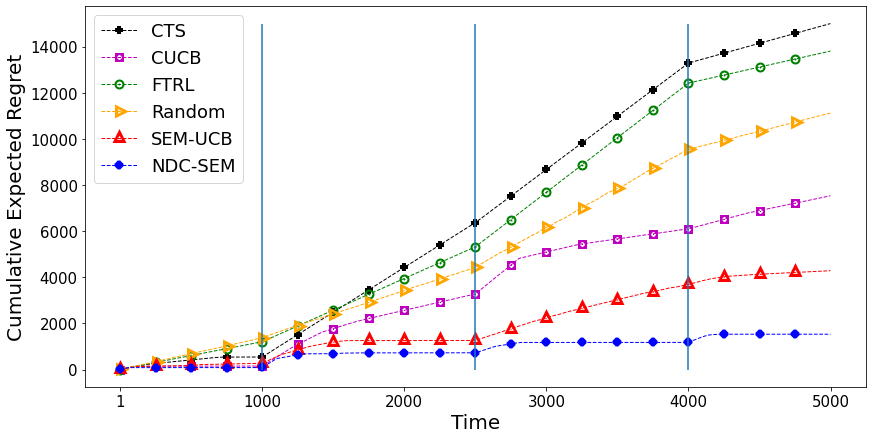

In [66]:
Y1 = aaaa[0:rounds]
Y2 = cccc[0:rounds]
Y3 = dddd[0:rounds]
Y4 = eeee[0:rounds]
Y5 = ffff[0:rounds]
Y6 = bbbb[0:rounds]

###################### saving the final results in a csv file ################
# expected_average_regret_saving=np.zeros((6, Y1.shape[0]))
# expected_average_regret_saving[0,:]=Y1
# expected_average_regret_saving[1,:]=Y2
# expected_average_regret_saving[2,:]=Y3
# expected_average_regret_saving[3,:]=Y4
# expected_average_regret_saving[4,:]=Y5
# expected_average_regret_saving[5,:]=Y6
# np.savetxt(f"cumulative_expected_regret_saving_d_{Delay}.csv", expected_average_regret_saving, delimiter=",")

###############################################################################

fig = plt.figure(figsize=[14, 7])

plt.plot(np.arange(rounds),np.transpose(Y5),'--',color = 'k', linewidth=1, marker = '+', mew = '8', ms='4', markevery=250,label='CTS');
plt.plot(np.arange(rounds),np.transpose(Y3),'--',color = 'm', linewidth=1, marker = 's', mew = '8', ms='1', markevery=250,label='CUCB');
plt.plot(np.arange(rounds),np.transpose(Y2),'--',color = 'g', linewidth=1, marker = '.', mew = '8', ms='4', markevery=250,label='FTRL');
plt.plot(np.arange(rounds),np.transpose(Y4),'--',color = 'orange', linewidth=1, marker = '>', mew = '8', ms='1', markevery=250,label='Random');
plt.plot(np.arange(rounds),np.transpose(Y6),'--',color = 'r', linewidth=1, marker = '^', mew = '8', ms='1', markevery=250,label='SEM-UCB');
plt.plot(np.arange(rounds),np.transpose(Y1),'--',color = 'b', linewidth=1, marker = 'x', mew = '8', ms='4', markevery=250,label='NDC-SEM');



max_y = 0
for array in [Y1, Y2, Y3, Y5]:
    if np.max(array) > max_y:
        max_y = np.max(array)

plt.vlines(change_points[1:], ymin=0, ymax=max_y)

#plt.legend();
#axis_font = {'fontname':'Arial', 'size':'19'}
plt.xlabel('Time', fontsize=20)
plt.xticks([1] + list(plt.xticks()[0][2:-1]), fontsize=15)

plt.ylabel("Cumulative Expected Regret",fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 18});
plt.show;
fig.savefig(f"cumulative_expected_regret_d_{Delay}.jpg", format = 'jpg', dpi = 300)




### Cumulative instantaneous regret

In [67]:
aaaa = np.cumsum(inst_regret_df['NDC-SEM'])
bbbb = np.cumsum(inst_regret_df['SEM-UCB'])
cccc = np.cumsum(inst_regret_df['FTRL'])
dddd = np.cumsum(inst_regret_df['CUCB'])
eeee = np.cumsum(inst_regret_df['Random'])
ffff = np.cumsum(inst_regret_df['CTS'])


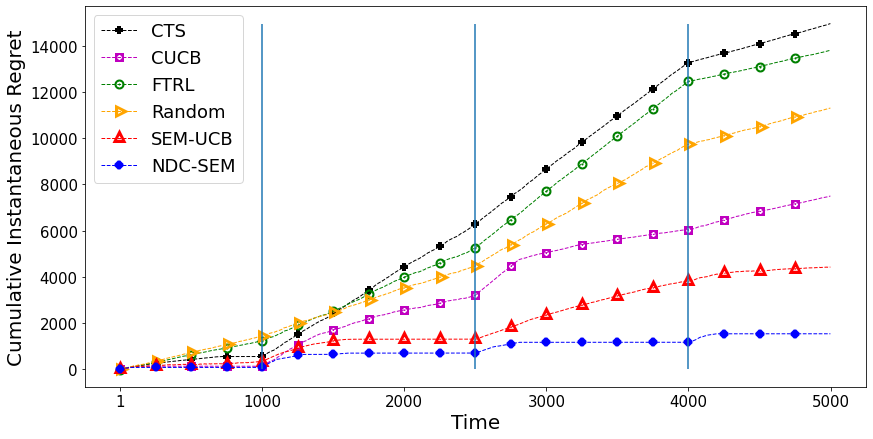

In [68]:
Y1 = aaaa[0:rounds]
Y2 = cccc[0:rounds]
Y3 = dddd[0:rounds]
Y4 = eeee[0:rounds]
Y5 = ffff[0:rounds]
Y6 = bbbb[0:rounds]

fig = plt.figure(figsize=[14, 7])

plt.plot(np.arange(rounds),np.transpose(Y5),'--',color = 'k', linewidth=1, marker = '+', mew = '8', ms='4', markevery=250,label='CTS');
plt.plot(np.arange(rounds),np.transpose(Y3),'--',color = 'm', linewidth=1, marker = 's', mew = '8', ms='1', markevery=250,label='CUCB');
plt.plot(np.arange(rounds),np.transpose(Y2),'--',color = 'g', linewidth=1, marker = '.', mew = '8', ms='4', markevery=250,label='FTRL');
plt.plot(np.arange(rounds),np.transpose(Y4),'--',color = 'orange', linewidth=1, marker = '>', mew = '8', ms='1', markevery=250,label='Random');
plt.plot(np.arange(rounds),np.transpose(Y6),'--',color = 'r', linewidth=1, marker = '^', mew = '8', ms='1', markevery=250,label='SEM-UCB');
plt.plot(np.arange(rounds),np.transpose(Y1),'--',color = 'b', linewidth=1, marker = 'x', mew = '8', ms='4', markevery=250,label='NDC-SEM');



max_y = 0
for array in [Y1, Y2, Y3, Y5]:
    if np.max(array) > max_y:
        max_y = np.max(array)

plt.vlines(change_points[1:], ymin=0, ymax=max_y)

#plt.legend();
#axis_font = {'fontname':'Arial', 'size':'19'}
plt.xlabel('Time', fontsize=20)
plt.xticks([1] + list(plt.xticks()[0][2:-1]), fontsize=15)

plt.ylabel("Cumulative Instantaneous Regret",fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 18});
plt.show;
fig.savefig(f"cumulative_instantaneous_regret_d_{Delay}.jpg", format = 'jpg', dpi = 300)




### Chosen arms oracle comparison

In [69]:
def oracle_superarms_ratios(actions_by_alg, best_actions_for_interval, intervals):
    """For each interval return how many (relative to oracle) chosen superarms were optimal."""
    assert actions_by_alg.shape[0] == nodes
    time_horizon = actions_by_alg.shape[1]
    
    ratios = np.zeros(len(intervals))
    
    for interval_ind, interval in enumerate(intervals):
        best_action = best_actions_for_interval[interval_ind]
        interval_length = interval[1] - interval[0]
        for t in range(interval[0], interval[1]):
            alg_action = actions_by_alg[:, t]
            
            ratios[interval_ind] += int(np.all(alg_action == best_action[:, 0]))
        print(ratios[interval_ind])
        ratios[interval_ind] /= interval_length
    
    return ratios

In [70]:
def oracle_base_arms_ratios(actions_by_alg, best_actions_for_interval, intervals):
    """For each interval return how many (relative to oracle) chosen base were optimal."""
    assert actions_by_alg.shape[0] == nodes
    time_horizon = actions_by_alg.shape[1]
    
    ratios = np.zeros(len(intervals))
    
    for interval_ind, interval in enumerate(intervals):
        best_action = best_actions_for_interval[interval_ind]
        interval_length = interval[1] - interval[0]
        for t in range(interval[0], interval[1]):
            alg_action = actions_by_alg[:, t]
            
            ratios[interval_ind] += np.count_nonzero(alg_action == best_action[:, 0])
        
        ratios[interval_ind] /= interval_length * nodes
    
    return ratios

In [71]:
all_change_points = change_points + [rounds]

In [72]:
intervals = list(zip(all_change_points, all_change_points[1:]))

In [73]:
intervals

[(0, 1000), (1000, 2500), (2500, 4000), (4000, 5000)]

#### Set which algorithms to plot

In [74]:
labels = ['NDC-SEM', 'SEM-UCB', 'FTRL']

In [75]:
all_algorithm_actions_to_plot = [
    all_algorithm_actions[label] for label in labels
]

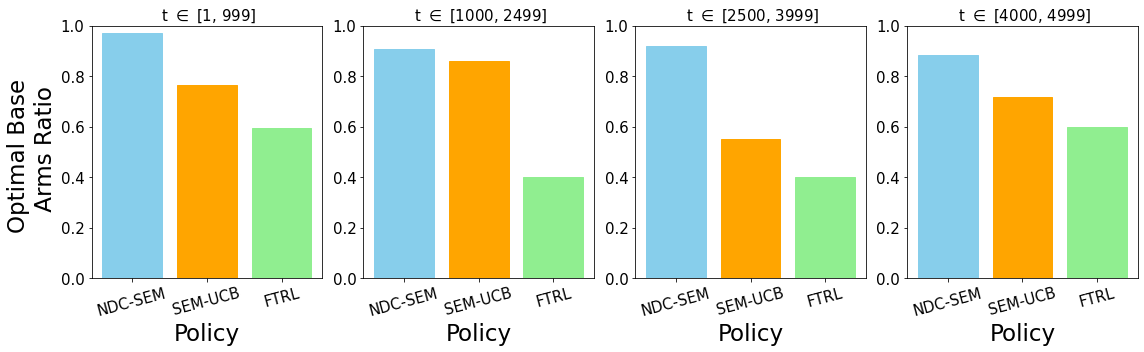

In [76]:
fig, axs = plt.subplots(1, len(intervals), figsize=(16, 5))

alg_in_interval_raio = np.zeros((len(labels), len(intervals)))
for i, alg_action in enumerate(all_algorithm_actions_to_plot):
    alg_in_interval_raio[i, :] = oracle_base_arms_ratios(alg_action, best_action_choice, intervals)

for j, interval in enumerate(intervals):
    ax = axs[j]
    
    barlist = ax.bar(labels, alg_in_interval_raio[:, j])
    
    ax.set_title(fr" t $\in$ [{interval[0] or 1}, {interval[1]-1}]", fontsize=15)
    
    if j == 0:
        ax.set_ylabel('Optimal Base \n Arms Ratio', fontsize=23)
    ax.set_xlabel('Policy', fontsize=23)
#     ax.set_xticklabels(labels, rotation=20, fontsize=14)
    
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15, rotation=15)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
    ax.set_ylim(0, 1)
    
    barlist[0].set_color('skyblue')
    barlist[1].set_color('orange')
    barlist[2].set_color('lightgreen')

    

plt.tight_layout()
fig.savefig(f"optimal_base_arms_d_{Delay}.jpg", format = 'jpg', dpi = 300)

0
924.0
1099.0
1184.0
790.0
1
4.0
899.0
0.0
0.0
2
0.0
0.0
0.0
0.0


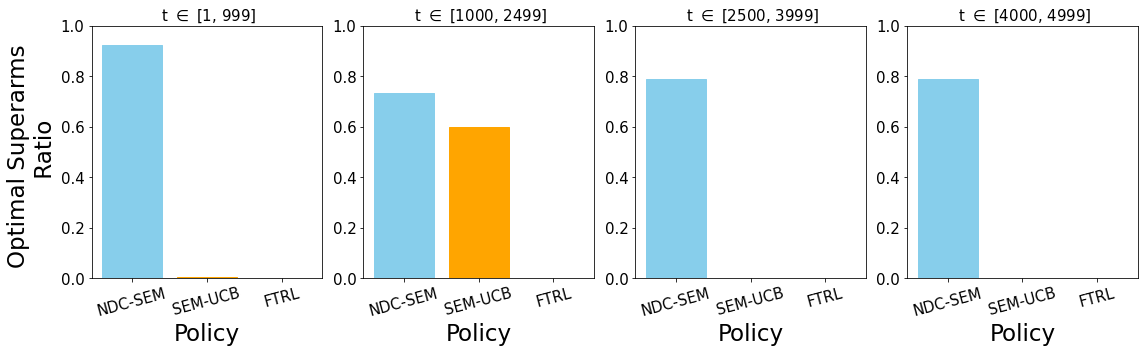

In [77]:
fig, axs = plt.subplots(1, len(intervals), figsize=(16, 5))

alg_in_interval_raio = np.zeros((len(labels), len(intervals)))
for i, alg_action in enumerate(all_algorithm_actions_to_plot):
    print(i)
    alg_in_interval_raio[i, :] = oracle_superarms_ratios(alg_action, best_action_choice, intervals)

for j, interval in enumerate(intervals):
    ax = axs[j]
    
    barlist = ax.bar(labels, alg_in_interval_raio[:, j])
    
    ax.set_title(fr" t $\in$ [{interval[0] or 1}, {interval[1]-1}]", fontsize=15)
    
    if j == 0:
        ax.set_ylabel('Optimal Superarms \n Ratio', fontsize=23)
    ax.set_xlabel('Policy', fontsize=23)
#     ax.set_xticklabels(labels, rotation=20, fontsize=14)
    
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15, rotation=15)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
    ax.set_ylim(0, 1)
    
    barlist[0].set_color('skyblue')
    barlist[1].set_color('orange')
    barlist[2].set_color('lightgreen')

    

plt.tight_layout()
fig.savefig(f"optimal_superarms_d_{Delay}.jpg", format = 'jpg', dpi = 300)

In [78]:
print(f"Experiment took {time() - start_ts} s")

Experiment took 1666.0472688674927 s


In [79]:
np.sum(expected_regret)

1529.7753253443045

In [80]:
# regret was 8440.688284345555